In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
from datetime import datetime
import json
import pickle

In [2]:
SP22 = 'sp22'
SP21 = 'sp21'

## Load in tables containing student id, student level

In [3]:
def get_levels(file):
    levels = pd.read_csv(file)
    advanced = levels[levels['level'] == 'advanced']
    intermediate = levels[levels['level'] == 'intermediate']
    beginner = levels[levels['level'] == 'beginner']
    
    return {'advanced': advanced, 'intermediate': intermediate, 'beginner': beginner}

level_dfs = {'sp22': get_levels('sp22-levels.csv'), 'sp21': get_levels('sp21-levels.csv')}


level_dfs['sp21']['advanced'].head()

Unnamed: 0  okpy_id  ranking                         languages  \
17           17  56539.0        5        Python, Java, C/C++, Swift   
18           18  55891.0        4  Python, JavaScript, Scratch/SNAP   
94           94  56322.0        3        Python, Java, Scratch/SNAP   
154         154  56609.0        4                      Python, Java   
196         196  56522.0        4   Python, Java, C/C++, JavaScript   

                                         prior courses  \
17   AP Computer Science A, Other High School progr...   
18                      AP Computer Science Principles   
94                                                 NaN   
154                     AP Computer Science Principles   
196                              AP Computer Science A   

                         age     level  
17   12 years old or younger  advanced  
18   12 years old or younger  advanced  
94   12 years old or younger  advanced  
154  12 years old or younger  advanced  
196  12 years old or younger  advanced

In [4]:
def get_assignment_df_level(level, assignment_df, sp22: bool):
    """
    Select entries in assignment_df that match.
    """
    sem = SP22 if sp22 else SP21
    filtered = None
    if level == 'advanced':
        advanced_ids = list(level_dfs[sem]["advanced"]['okpy_id'])
        
        filtered = assignment_df[[sid in advanced_ids for sid in assignment_df['student_id']]]

    elif level == 'intermediate':
        intermediate_ids = list(level_dfs[sem]["intermediate"]['okpy_id'])
        
        filtered = assignment_df[[sid in intermediate_ids for sid in assignment_df['student_id']]]
    
    else:
        beginner_ids = list(level_dfs[sem]["beginner"]['okpy_id'])
        
        filtered = assignment_df[[sid in beginner_ids for sid in assignment_df['student_id']]]
    
    return filtered


In [5]:
assignment_dfs = {}

In [6]:
def load_assignment_df(name, refresh=False):
    if name in assignment_dfs and not refresh:
        return assignment_dfs[name]

    sp22 = 'sp22' in name
    columns = ['timestamp','message_type','data','student_id','is_submission','assignment']
#     columns = ['assignment_id','assignment', 'backup_id', 'timestamp', 'student_id', 'is_submission', 'message_type', 'data']
    if sp22:
        columns = ['assignment_id','assignment', 'backup_id', 'timestamp', 'student_id', 'is_submission', 'message_type', 'data']

    assignment_df = pd.read_csv(name, usecols=[i for i in range(len(columns))]) # 2 is data
    assignment_df.columns = columns

    assignment_dfs[name] = assignment_df

    return assignment_dfs[name]

In [7]:
sp22_labs = ['lab01-sp22.csv', 'lab02-sp22.csv', 'lab04-sp22.csv', 'lab05-sp22.csv', 'lab06-sp22.csv']
sp22_hws = ['hw01-sp22.csv', 'hw02-sp22.csv', 'hw03-sp22.csv', 'hw04-sp22.csv']
sp21_labs = ['lab01.csv', 'lab02.csv', 'lab04.csv', 'lab05.csv', 'lab06.csv']
sp21_hws = ['hw01.csv', 'hw02.csv', 'hw03.csv', 'hw04.csv']
names = sp22_labs + sp22_hws + sp21_labs + sp21_hws
_ = load_assignment_df('lab01-sp22.csv')
_ = load_assignment_df('lab02-sp22.csv')
load_assignment_df('lab04-sp22.csv')

assignment_id            assignment  backup_id            timestamp  \
0                9878  cal/cs61a/sp22/lab04   32930705  2022-02-07 21:10:51   
1                9878  cal/cs61a/sp22/lab04   32930705  2022-02-07 21:10:51   
2                9878  cal/cs61a/sp22/lab04   32930712  2022-02-07 21:12:23   
3                9878  cal/cs61a/sp22/lab04   32930712  2022-02-07 21:12:23   
4                9878  cal/cs61a/sp22/lab04   32930712  2022-02-07 21:12:23   
...               ...                   ...        ...                  ...   
133843           9878  cal/cs61a/sp22/lab04   33744662  2022-03-07 23:11:41   
133844           9878  cal/cs61a/sp22/lab04   33744662  2022-03-07 23:11:41   
133845           9878  cal/cs61a/sp22/lab04   33745095  2022-03-07 23:24:47   
133846           9878  cal/cs61a/sp22/lab04   33745095  2022-03-07 23:24:47   
133847           9878  cal/cs61a/sp22/lab04   33745095  2022-03-07 23:24:47   

        student_id  is_submission message_type  \
0            35348              0      problem   
1            35348              0       action   
2            35348              0       action   
3            35348              0      problem   
4            35348              0    analytics   
...            ...            ...          ...   
133843       71289              0       action   
133844       71289              0    analytics   
133845       71289              0       action   
133846       71289              0    analytics   
133847       71289              0      problem   

                                                     data  
0                                          "line_stepper"  
1                                                  "stop"  
2                                                 "start"  
3                                          "line_stepper"  
4       {"question": ["line_stepper"], "time-utc": "20...  
...                                                   ...  
133843                                             "stop"  
133844  {"time-utc": "2022-03-07 23:11:41.871914", "hi...  
133845                                            "start"  
133846  {"action": "start", "time-utc": "2022-03-07 23...  
133847                                     "line_stepper"  

[133848 rows x 8 columns]

In [8]:
assignment_level_dfs = {}
def refresh_assignment_level_dfs(names=None):
    if not names:
        names = list(assignment_dfs)
    for name in names:
        beginner_df = get_assignment_df_level("beginner", assignment_dfs[name], 'sp22' in name)
        intermediate_df = get_assignment_df_level("intermediate", assignment_dfs[name], 'sp22' in name)
        advanced_df = get_assignment_df_level("advanced", assignment_dfs[name], 'sp22' in name)
        assignment_level_dfs[name] = {
            "beginner": beginner_df,
            "intermediate": intermediate_df,
            "advanced": advanced_df
        }
refresh_assignment_level_dfs()

In [9]:
sp21_df_filters = {}
sp21_df_filters["has_apcs"] = pd.read_csv('has_apcs_df_sp21.csv', usecols=[1])
sp21_df_filters["has_python"] = pd.read_csv('has_python_df_sp21.csv', usecols=[1])
sp21_df_filters["no_languages_before"] = pd.read_csv('no_languages_before_df_sp21.csv', usecols=[1])
sp21_df_filters["no_python_but_other_languages"] = pd.read_csv('no_python_but_other_languages_df_sp21.csv', usecols=[1])
sp22_df_filters = {}
sp22_df_filters["has_apcs"] = pd.read_csv('has_apcs_df_sp22.csv', usecols=[1])
sp22_df_filters["has_python"] = pd.read_csv('has_python_df_sp22.csv', usecols=[1])
sp22_df_filters["no_languages_before"] = pd.read_csv('no_languages_before_df_sp22.csv', usecols=[1])
sp22_df_filters["no_python_but_other_languages"] = pd.read_csv('no_python_but_other_languages_df_sp22.csv', usecols=[1])
for group in sp21_df_filters:
    sp21_df_filters[group] = sp21_df_filters[group].rename(columns={"id_email": "okpy_id"})

In [28]:
import pdb
def reject_outliers(data, m = 10.):
#     print(len(data))
    d = np.abs(data - np.median(data))
#     print(d)
    mdev = np.median(d)
#     print(mdev)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

def reject_outliers_using_iqr(data, m = 10.):
    Q3 = np.percentile(data, 75)
    Q1 = np.percentile(data, 25)
    median = np.percentile(data, 50)
    IQR = (Q3 - Q1) * 1.5
    lower, upper =  Q1 - IQR, Q3 + IQR
    print(f"Q1, Q3, range = {Q1}, {Q3}, ({lower}, {upper})")
    result = data[np.where((data >= lower) & (data <= upper))]
    return result

def get_questions(assignment_df):
    questions = set()
    for row in assignment_df.itertuples():
        data = json.loads(row.data)
        if len(list(data)) != 1 or type(data) != dict:
            continue
        question = list(data)[0]
        questions.add(question)
    
    questions = [q for q in list(questions) if q.lower() != "total" and ".py" not in q]
    return questions

def generate_num_attempts(assignment_df, questions):
    assignments = assignment_df.assignment.unique()
    assignment_now = 'cal/cs61a/sp22/lab02' # edit this
    students = assignment_df.student_id.unique()
    
    is_assignment = assignment_df.assignment == assignment_now
    assignment_data = assignment_df[is_assignment]
    assignment_students = assignment_data.student_id.unique()

    grading_students = assignment_df[assignment_df.message_type == 'grading'].student_id.unique()
    no_grading_students = [student for student in assignment_students if student not in grading_students]
    
    # compute number of attempts per question / edit questions here

    num_attempts_per_question = {question: {student: 0 for student in grading_students} for question in questions}
    for student in grading_students:
        for row in assignment_df[(assignment_df.student_id == student) & (assignment_df.message_type == 'grading')].itertuples():
        
            data = json.loads(row.data)
            if len(list(data)) != 1:
                continue
            question = list(data)[0]
            if question in num_attempts_per_question:
                num_attempts_per_question[question][student] += 1
    
#     for q in questions:
#         temp = np.array(list(num_attempts_per_question[q].values()))
#         plt.figure()
#         print(q + " Number of Attempts Summary Statistics")
#         plt.hist(list(temp))
#         plt.show()
#         print(pd.DataFrame(temp).describe())
    return num_attempts_per_question

def plot_num_attempts_per_question(num_attempts_per_question, questions=None, use_iqr=False):
    if questions is None:
        questions = list(num_attempts_per_question)
    for q in questions:
        print()
        print(f"{q.upper()}")
        temp = np.array(list(num_attempts_per_question[q].values()))
    #     print(len(temp))
        if use_iqr:
            temp = reject_outliers_using_iqr(temp)
        else:
            temp = reject_outliers(temp)
        plt.figure()
        print("Number of Attempts")
        plt.hist(list(temp))
        plt.show()
        temp_final = pd.DataFrame(list(temp))
        print()
        print("Summary Statistics")
        print(temp_final.describe())
        print()


In [11]:
sp22_df_filters['no_languages_before']

okpy_id
0     60431
1     71289
2     71146
3     71249
4     69014
5     71617
6     71236
7     71339
8     71015
9     71097
10    56138
11    57558
12    71251
13    71346
14    70991
15    65817
16    71619
17    66274
18    70683
19    71131
20    71367
21    65662
22    71243
23    70984
24    71425
25    71322
26    71199
27    27384
28    71170
29    70971
30    71038
31    56333
32    62363
33    71423
34    65904
35    66371
36    71164
37    71177
38    71158
39    71329
40    71615
41    71077
42    71080
43    51291
44    71055
45    71421
46    71255
47    75579

In [12]:
assignment_df = assignment_dfs['lab01-sp22.csv']
ids_df = sp22_df_filters['has_apcs']
ids = list(ids_df['okpy_id'])

filtered = assignment_df[[sid in ids for sid in assignment_df['student_id']]]
filtered['student_id'].unique()

array([71454, 71257, 71286, 71422, 71162, 71281, 70866, 71438, 65732,
       68299, 70973, 54050, 65154, 70788, 71274, 71378, 71334, 71414,
       65676, 71443, 71358, 71036, 71305, 71039, 64735])

In [18]:
def num_attempts_graphs(name):
    load_assignment_df(name)
    questions = get_questions(assignment_dfs[name])
    print(f"Generating num attempts for {name}, using {questions}")
    num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
    plot_num_attempts_per_question(num_attempts_per_question, questions)
    
def num_attempts_graphs_by_level(name):
    load_assignment_df(name)
    refresh_assignment_level_dfs([name])

    questions = get_questions(assignment_dfs[name])
    print()
    print(f"Generating num attempts for {name}, stratified by level, using {questions}")
    for level in assignment_level_dfs[name]:
        print(f"{level.upper()}")
        num_attempts_per_question = generate_num_attempts(assignment_level_dfs[name][level], questions)
        plot_num_attempts_per_question(num_attempts_per_question, questions)

def filter_assignment_df_using_ids(assignment_df, ids_df):
    ids = list(ids_df['okpy_id'])

    filtered = assignment_df[[sid in ids for sid in assignment_df['student_id']]]
    return filtered
        
def num_attempts_graphs_using_df(name, ids_df, group_name):
    load_assignment_df(name)
    questions = get_questions(assignment_dfs[name])
    print()
    print(f"Generating num attempts for {name}, for people in {group_name.upper()}, using {questions}")
    filtered_assignment_df = filter_assignment_df_using_ids(assignment_dfs[name], ids_df)
    num_attempts_per_question = generate_num_attempts(filtered_assignment_df, questions)
    plot_num_attempts_per_question(num_attempts_per_question, questions)

def print_comma_separated_summary_statistics(name, questions, outlier_threshold=10, use_iqr=False):
    load_assignment_df(name)
    num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
    summaries = {}
    for q in questions:
        temp = np.array(list(num_attempts_per_question[q].values()))
    #     print(len(temp))
        if use_iqr:
            temp = reject_outliers_using_iqr(temp)
        else:
            temp = reject_outliers(temp, outlier_threshold)
        temp_final = pd.DataFrame(list(temp))
        summary = temp_final.describe()
        summaries[q] = summary

    for q in questions:
        summary_list = summaries[q].values.tolist()
        summary_list = [str(s[0]) for s in summary_list]
        print(q)
        print(','.join(summary_list))


Generating num attempts for hw02-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['restrict_domain', 'again', 'product', 'accumulate', 'summation_using_accumulate', 'restrict_range', 'product_using_accumulate', 'restrict_both', 'hailstone', 'count_until_larger', 'filter_sequence']

RESTRICT_DOMAIN
Number of Attempts


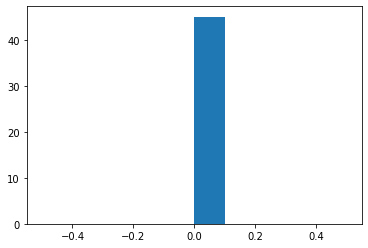


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


AGAIN
Number of Attempts


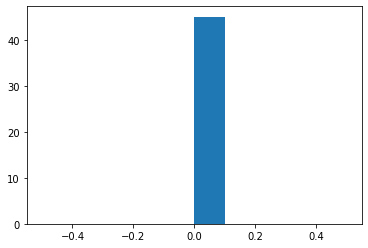


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PRODUCT
Number of Attempts


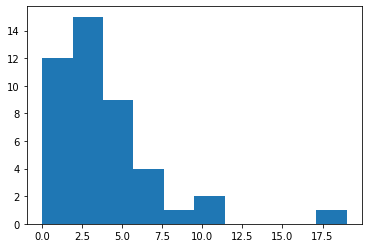


Summary Statistics
               0
count  44.000000
mean    3.704545
std     3.474690
min     0.000000
25%     1.000000
50%     3.000000
75%     5.000000
max    19.000000


ACCUMULATE
Number of Attempts


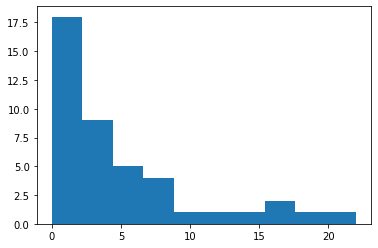


Summary Statistics
               0
count  43.000000
mean    5.162791
std     5.358261
min     0.000000
25%     2.000000
50%     3.000000
75%     6.500000
max    22.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


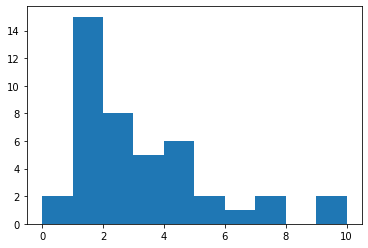


Summary Statistics
               0
count  43.000000
mean    2.767442
std     2.307722
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    10.000000


RESTRICT_RANGE
Number of Attempts


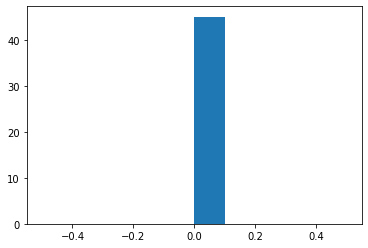


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PRODUCT_USING_ACCUMULATE
Number of Attempts


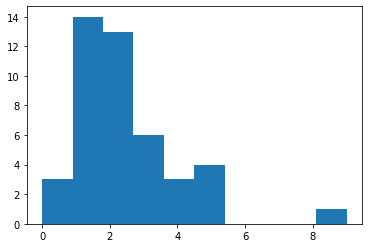


Summary Statistics
              0
count  44.00000
mean    2.25000
std     1.71349
min     0.00000
25%     1.00000
50%     2.00000
75%     3.00000
max     9.00000


RESTRICT_BOTH
Number of Attempts


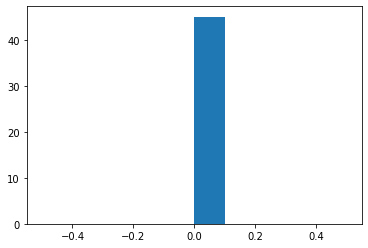


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


HAILSTONE
Number of Attempts


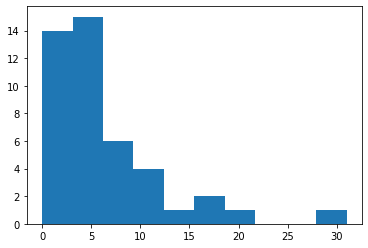


Summary Statistics
               0
count  44.000000
mean    6.477273
std     6.032812
min     0.000000
25%     3.000000
50%     5.000000
75%     8.250000
max    31.000000


COUNT_UNTIL_LARGER
Number of Attempts


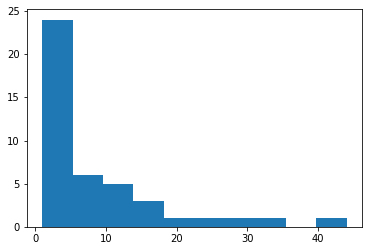


Summary Statistics
               0
count  43.000000
mean    8.069767
std     9.567792
min     1.000000
25%     2.000000
50%     4.000000
75%    11.000000
max    44.000000


FILTER_SEQUENCE
Number of Attempts


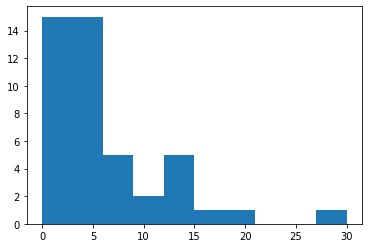


Summary Statistics
               0
count  45.000000
mean    5.755556
std     5.962594
min     0.000000
25%     1.000000
50%     4.000000
75%     8.000000
max    30.000000



In [19]:
num_attempts_graphs_using_df('hw02-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

## Lab 01

Generating num attempts for lab01-sp22.csv, using ['k_occurrence', 'falling', 'debugging-quiz', 'double_eights', 'sum_digits', 'Control', 'add_in_range', 'Veritasiness', 'begin', 'digit_pos_match']

K_OCCURRENCE
Number of Attempts


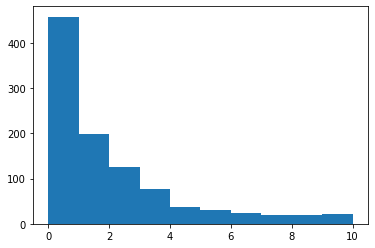


Summary Statistics
                 0
count  1013.000000
mean      1.610069
std       2.261767
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max      10.000000


FALLING
Number of Attempts


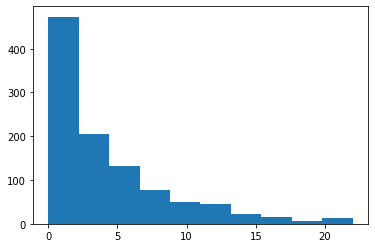


Summary Statistics
                 0
count  1042.000000
mean      4.316699
std       4.358512
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      22.000000


DEBUGGING-QUIZ
Number of Attempts


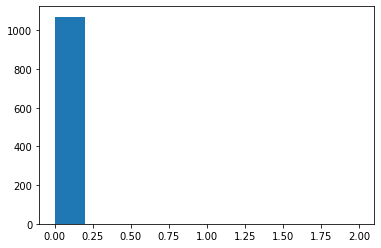


Summary Statistics
                 0
count  1072.000000
mean      0.002799
std       0.068269
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


DOUBLE_EIGHTS
Number of Attempts


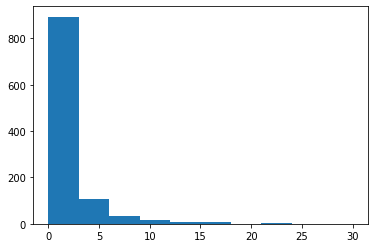


Summary Statistics
                 0
count  1072.000000
mean      1.322761
std       2.933169
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      30.000000


SUM_DIGITS
Number of Attempts


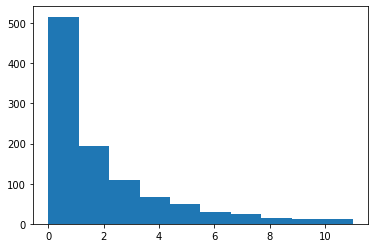


Summary Statistics
                 0
count  1030.000000
mean      2.264078
std       2.165228
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      11.000000


CONTROL
Number of Attempts


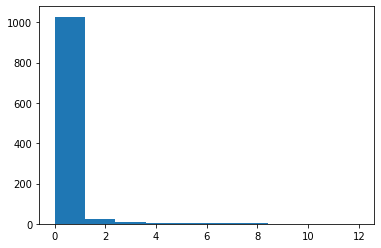


Summary Statistics
                 0
count  1072.000000
mean      0.197761
std       0.822237
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      12.000000


ADD_IN_RANGE
Number of Attempts


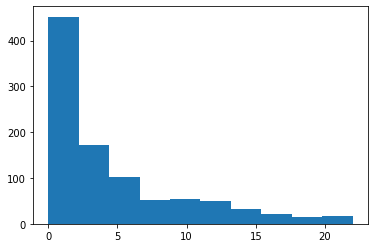


Summary Statistics
                0
count  969.000000
mean     4.884417
std      4.956532
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


VERITASINESS
Number of Attempts


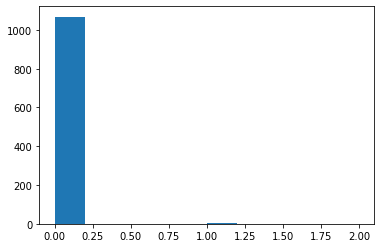


Summary Statistics
                 0
count  1072.000000
mean      0.004664
std       0.080710
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


BEGIN
Number of Attempts


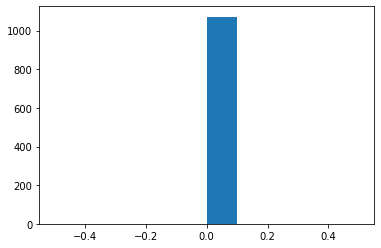


Summary Statistics
            0
count  1072.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0


DIGIT_POS_MATCH
Number of Attempts


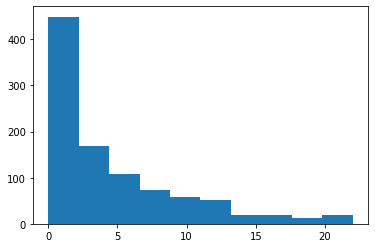


Summary Statistics
                0
count  980.000000
mean     4.782653
std      4.772742
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000



In [29]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab01-sp22.csv')


Generating num attempts for lab01-sp22.csv, stratified by level, using ['digit_pos_match', 'add_in_range', 'Control', 'double_eights', 'debugging-quiz', 'begin', 'k_occurrence', 'sum_digits', 'falling', 'Veritasiness']
BEGINNER

DIGIT_POS_MATCH
Number of Attempts


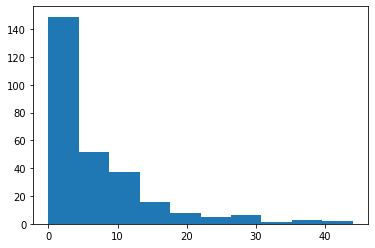


Summary Statistics
                0
count  279.000000
mean     6.935484
std      7.956003
min      0.000000
25%      1.000000
50%      4.000000
75%      9.000000
max     44.000000


ADD_IN_RANGE
Number of Attempts


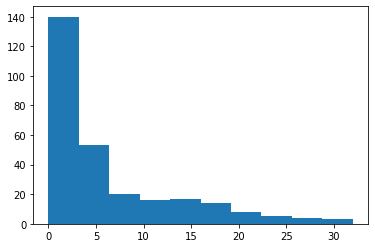


Summary Statistics
                0
count  280.000000
mean     6.421429
std      6.804034
min      0.000000
25%      2.000000
50%      3.500000
75%      9.000000
max     32.000000


CONTROL
Number of Attempts


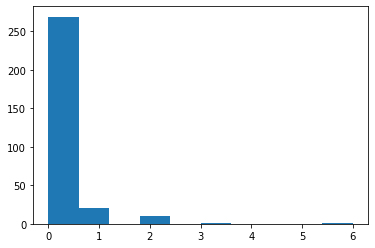


Summary Statistics
                0
count  301.000000
mean     0.162791
std      0.568692
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


DOUBLE_EIGHTS
Number of Attempts


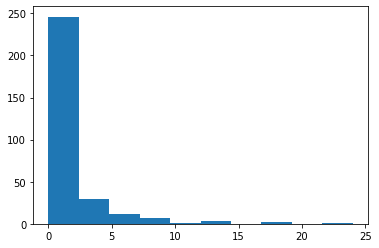


Summary Statistics
                0
count  301.000000
mean     1.322259
std      2.929016
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max     24.000000


DEBUGGING-QUIZ
Number of Attempts


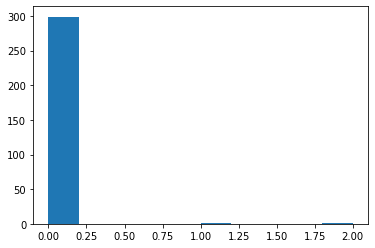


Summary Statistics
                0
count  301.000000
mean     0.009967
std      0.128713
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


BEGIN
Number of Attempts


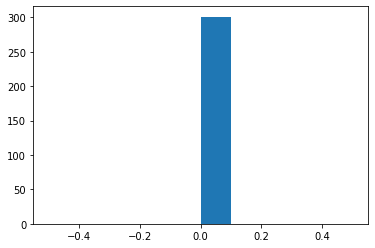


Summary Statistics
           0
count  301.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


K_OCCURRENCE
Number of Attempts


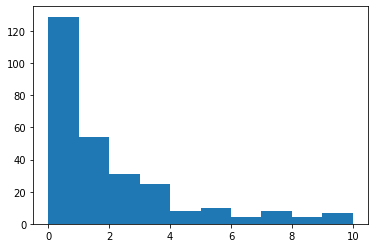


Summary Statistics
                0
count  280.000000
mean     1.610714
std      2.295834
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max     10.000000


SUM_DIGITS
Number of Attempts


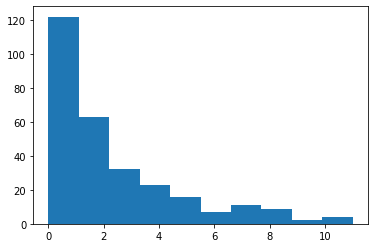


Summary Statistics
                0
count  289.000000
mean     2.546713
std      2.278842
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


FALLING
Number of Attempts


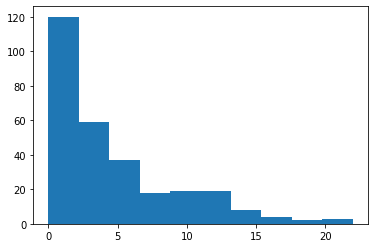


Summary Statistics
                0
count  289.000000
mean     4.667820
std      4.482261
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


VERITASINESS
Number of Attempts


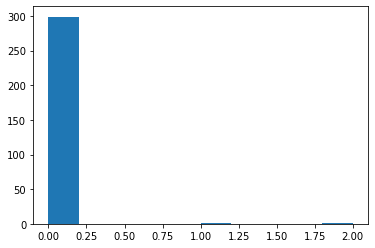


Summary Statistics
                0
count  301.000000
mean     0.009967
std      0.128713
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000

INTERMEDIATE

DIGIT_POS_MATCH
Number of Attempts


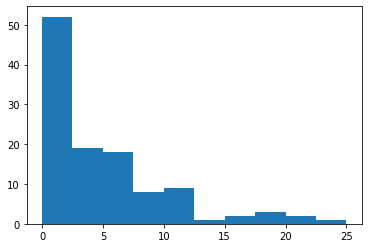


Summary Statistics
                0
count  115.000000
mean     5.008696
std      5.108465
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     25.000000


ADD_IN_RANGE
Number of Attempts


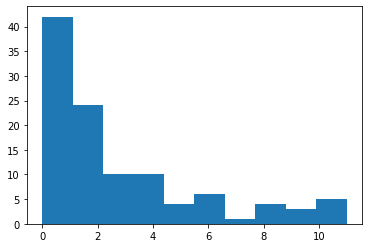


Summary Statistics
                0
count  109.000000
mean     3.045872
std      2.688747
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


CONTROL
Number of Attempts


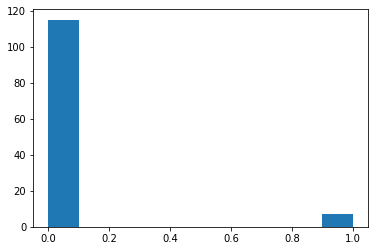


Summary Statistics
                0
count  122.000000
mean     0.057377
std      0.233521
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


DOUBLE_EIGHTS
Number of Attempts


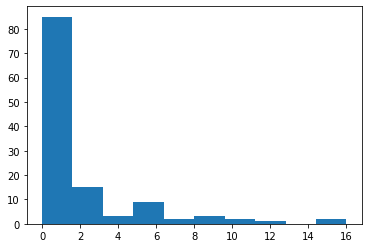


Summary Statistics
                0
count  122.000000
mean     1.811475
std      3.083767
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max     16.000000


DEBUGGING-QUIZ
Number of Attempts


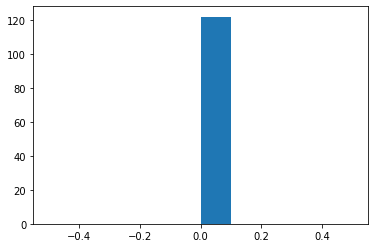


Summary Statistics
           0
count  122.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


BEGIN
Number of Attempts


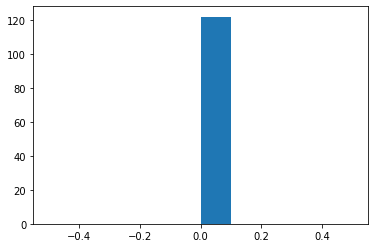


Summary Statistics
           0
count  122.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


K_OCCURRENCE
Number of Attempts


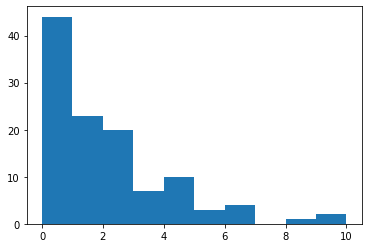


Summary Statistics
                0
count  114.000000
mean     1.675439
std      2.080230
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max     10.000000


SUM_DIGITS
Number of Attempts


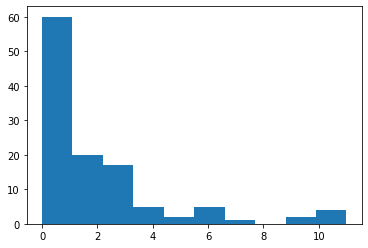


Summary Statistics
                0
count  116.000000
mean     2.327586
std      2.283308
min      0.000000
25%      1.000000
50%      1.000000
75%      3.000000
max     11.000000


FALLING
Number of Attempts


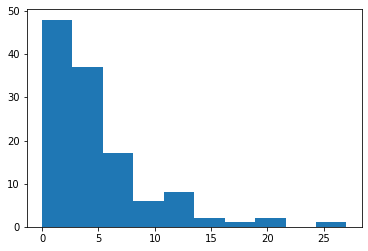


Summary Statistics
                0
count  122.000000
mean     4.868852
std      4.702647
min      0.000000
25%      1.250000
50%      3.500000
75%      7.000000
max     27.000000


VERITASINESS
Number of Attempts


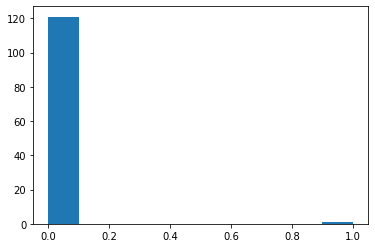


Summary Statistics
                0
count  122.000000
mean     0.008197
std      0.090536
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

ADVANCED

DIGIT_POS_MATCH
Number of Attempts


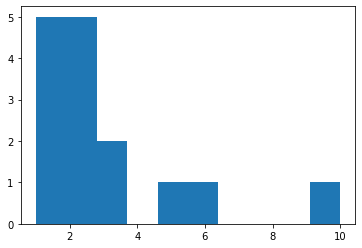


Summary Statistics
               0
count  15.000000
mean    2.800000
std     2.484236
min     1.000000
25%     1.000000
50%     2.000000
75%     3.000000
max    10.000000


ADD_IN_RANGE
Number of Attempts


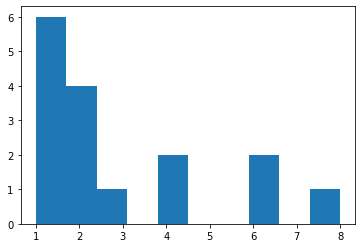


Summary Statistics
               0
count  16.000000
mean    2.812500
std     2.197536
min     1.000000
25%     1.000000
50%     2.000000
75%     4.000000
max     8.000000


CONTROL
Number of Attempts


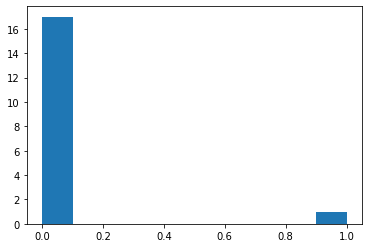


Summary Statistics
               0
count  18.000000
mean    0.055556
std     0.235702
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


DOUBLE_EIGHTS
Number of Attempts


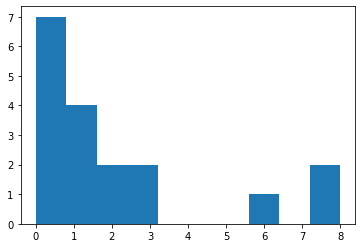


Summary Statistics
               0
count  18.000000
mean    2.000000
std     2.678894
min     0.000000
25%     0.000000
50%     1.000000
75%     2.750000
max     8.000000


DEBUGGING-QUIZ
Number of Attempts


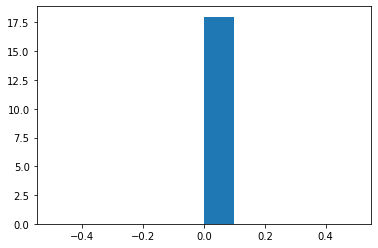


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


BEGIN
Number of Attempts


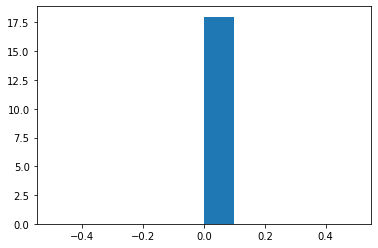


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


K_OCCURRENCE
Number of Attempts


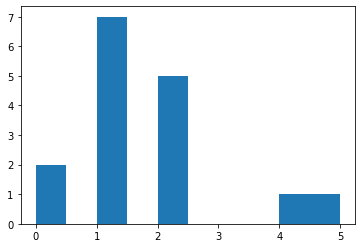


Summary Statistics
               0
count  16.000000
mean    1.625000
std     1.310216
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     5.000000


SUM_DIGITS
Number of Attempts


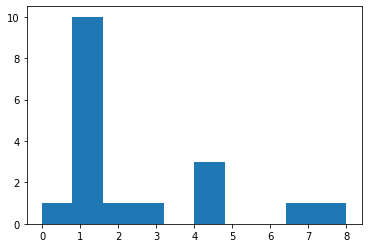


Summary Statistics
               0
count  18.000000
mean    2.333333
std     2.249183
min     0.000000
25%     1.000000
50%     1.000000
75%     3.750000
max     8.000000


FALLING
Number of Attempts


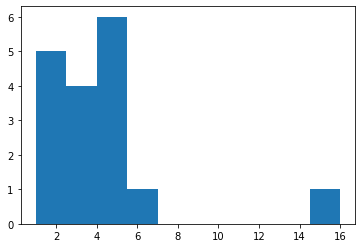


Summary Statistics
               0
count  17.000000
mean    4.058824
std     3.399827
min     1.000000
25%     2.000000
50%     3.000000
75%     5.000000
max    16.000000


VERITASINESS
Number of Attempts


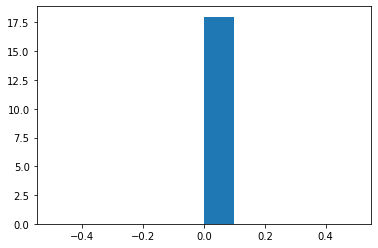


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [12]:
num_attempts_graphs_by_level('lab01-sp22.csv')


Generating num attempts for lab01-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['k_occurrence', 'falling', 'debugging-quiz', 'double_eights', 'sum_digits', 'Control', 'add_in_range', 'Veritasiness', 'begin', 'digit_pos_match']

K_OCCURRENCE
Number of Attempts


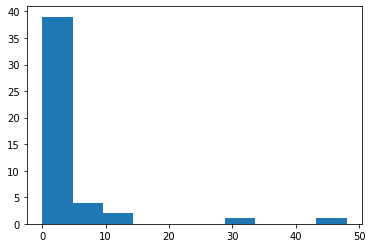


Summary Statistics
               0
count  47.000000
mean    3.255319
std     8.236895
min     0.000000
25%     0.000000
50%     0.000000
75%     2.500000
max    48.000000


FALLING
Number of Attempts


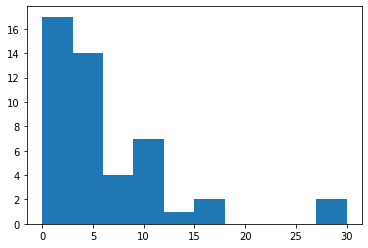


Summary Statistics
               0
count  47.000000
mean    5.914894
std     6.510292
min     0.000000
25%     2.000000
50%     4.000000
75%     8.500000
max    30.000000


DEBUGGING-QUIZ
Number of Attempts


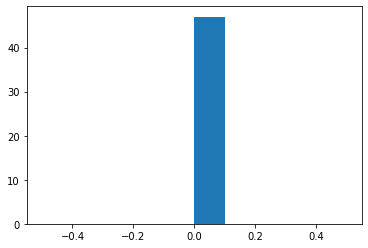


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


DOUBLE_EIGHTS
Number of Attempts


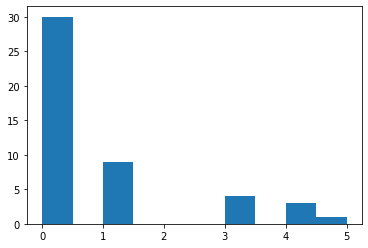


Summary Statistics
               0
count  47.000000
mean    0.808511
std     1.377431
min     0.000000
25%     0.000000
50%     0.000000
75%     1.000000
max     5.000000


SUM_DIGITS
Number of Attempts


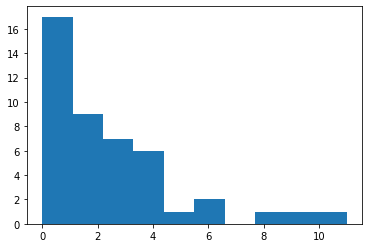


Summary Statistics
               0
count  45.000000
mean    2.622222
std     2.424205
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    11.000000


CONTROL
Number of Attempts


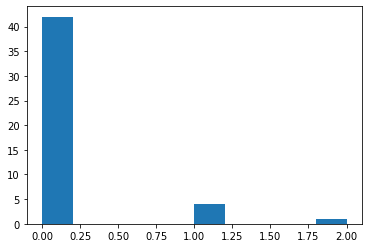


Summary Statistics
               0
count  47.000000
mean    0.127660
std     0.396562
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000


ADD_IN_RANGE
Number of Attempts


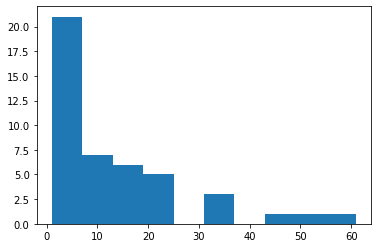


Summary Statistics
               0
count  45.000000
mean   12.711111
std    14.237630
min     1.000000
25%     3.000000
50%     7.000000
75%    16.000000
max    61.000000


VERITASINESS
Number of Attempts


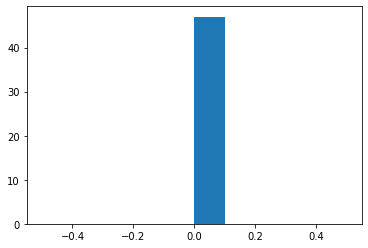


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


BEGIN
Number of Attempts


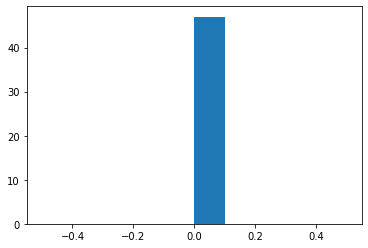


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


DIGIT_POS_MATCH
Number of Attempts


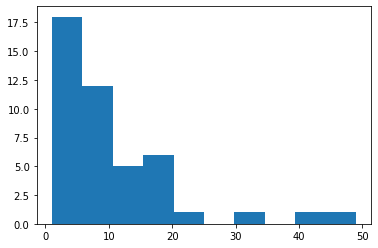


Summary Statistics
               0
count  45.000000
mean    9.800000
std    10.786355
min     1.000000
25%     1.000000
50%     7.000000
75%    14.000000
max    49.000000



In [58]:
num_attempts_graphs_using_df('lab01-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

Generating num attempts for lab01.csv, using ['falling', 'debugging-quiz', 'double_eights', 'sum_digits', 'Control', 'Veritasiness', 'both_positive']

FALLING
Number of Attempts


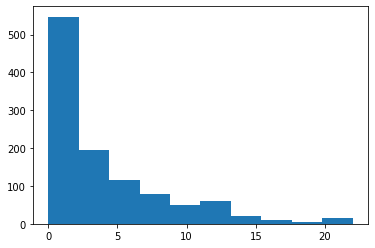


Summary Statistics
                 0
count  1097.000000
mean      4.161349
std       4.267134
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      22.000000


DEBUGGING-QUIZ
Number of Attempts


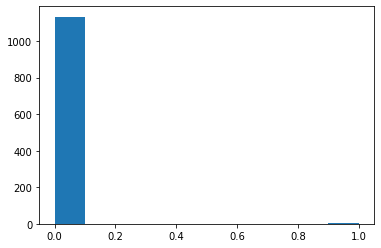


Summary Statistics
                 0
count  1136.000000
mean      0.002641
std       0.051344
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


DOUBLE_EIGHTS
Number of Attempts


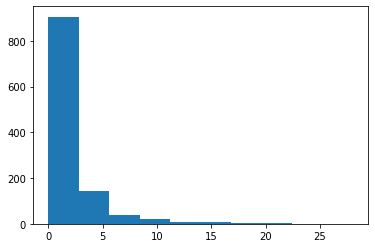


Summary Statistics
                 0
count  1136.000000
mean      1.534331
std       3.006111
min       0.000000
25%       0.000000
50%       0.000000
75%       2.000000
max      28.000000


SUM_DIGITS
Number of Attempts


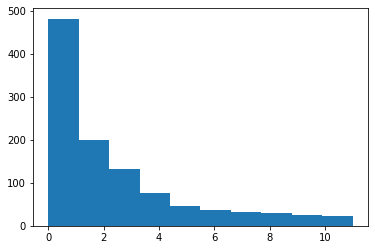


Summary Statistics
                 0
count  1078.000000
mean      2.631725
std       2.454563
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      11.000000


CONTROL
Number of Attempts


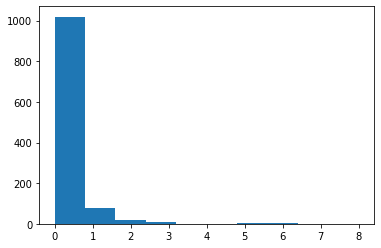


Summary Statistics
                 0
count  1136.000000
mean      0.176937
std       0.676500
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       8.000000


VERITASINESS
Number of Attempts


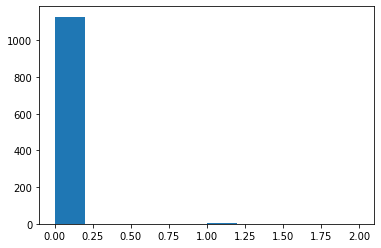


Summary Statistics
                 0
count  1136.000000
mean      0.007042
std       0.093600
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


BOTH_POSITIVE
Number of Attempts


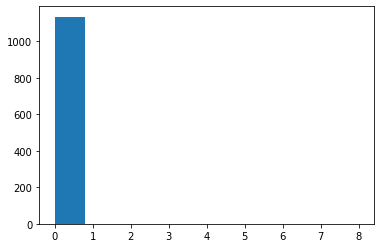


Summary Statistics
                 0
count  1136.000000
mean      0.007042
std       0.237356
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       8.000000



In [30]:
num_attempts_graphs('lab01.csv')


Generating num attempts for lab01.csv, stratified by level, using ['double_eights', 'Veritasiness', 'sum_digits', 'falling', 'both_positive', 'Control', 'debugging-quiz']
BEGINNER

DOUBLE_EIGHTS
Number of Attempts


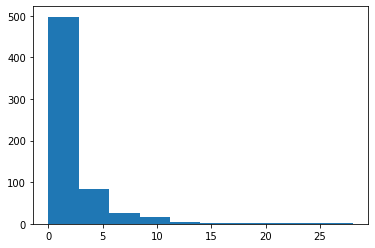


Summary Statistics
                0
count  634.000000
mean     1.574132
std      3.084645
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max     28.000000


VERITASINESS
Number of Attempts


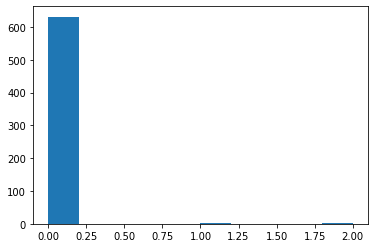


Summary Statistics
                0
count  634.000000
mean     0.006309
std      0.097154
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


SUM_DIGITS
Number of Attempts


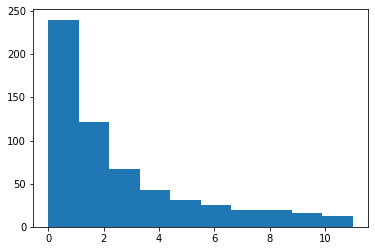


Summary Statistics
                0
count  596.000000
mean     2.845638
std      2.534402
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


FALLING
Number of Attempts


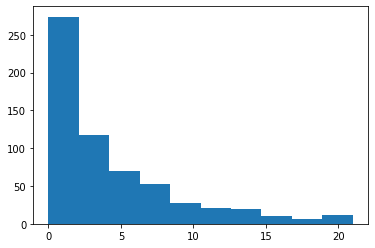


Summary Statistics
                0
count  608.000000
mean     4.513158
std      4.455139
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


BOTH_POSITIVE
Number of Attempts


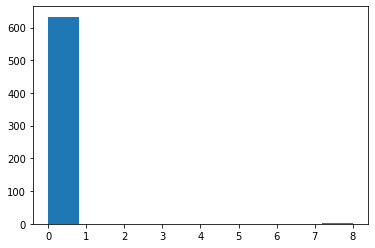


Summary Statistics
                0
count  634.000000
mean     0.012618
std      0.317721
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      8.000000


CONTROL
Number of Attempts


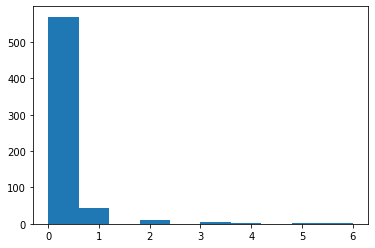


Summary Statistics
                0
count  634.000000
mean     0.159306
std      0.588073
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


DEBUGGING-QUIZ
Number of Attempts


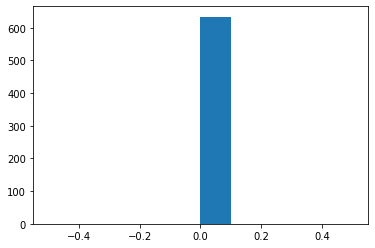


Summary Statistics
           0
count  634.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

INTERMEDIATE

DOUBLE_EIGHTS
Number of Attempts


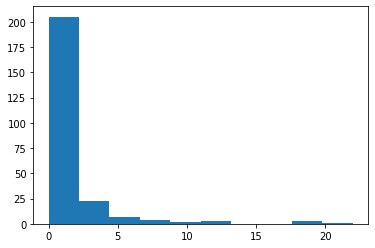


Summary Statistics
                0
count  248.000000
mean     1.467742
std      3.079080
min      0.000000
25%      0.000000
50%      0.000000
75%      1.250000
max     22.000000


VERITASINESS
Number of Attempts


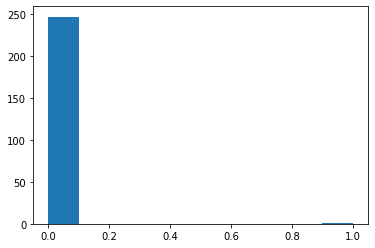


Summary Statistics
                0
count  248.000000
mean     0.004032
std      0.063500
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


SUM_DIGITS
Number of Attempts


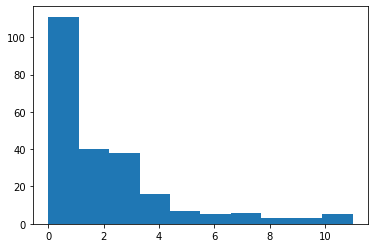


Summary Statistics
                0
count  234.000000
mean     2.405983
std      2.216241
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


FALLING
Number of Attempts


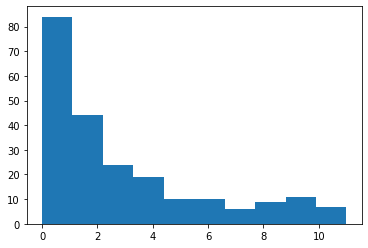


Summary Statistics
                0
count  224.000000
mean     3.129464
std      2.781461
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


BOTH_POSITIVE
Number of Attempts


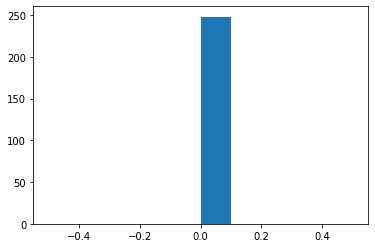


Summary Statistics
           0
count  248.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CONTROL
Number of Attempts


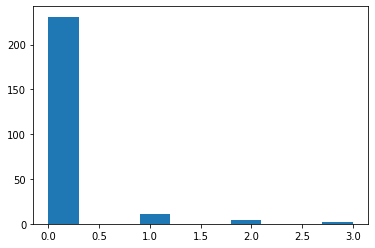


Summary Statistics
                0
count  248.000000
mean     0.100806
std      0.414709
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


DEBUGGING-QUIZ
Number of Attempts


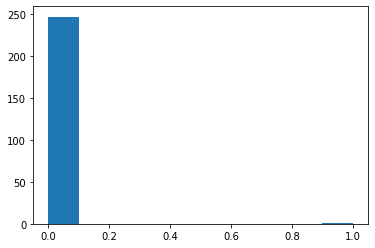


Summary Statistics
                0
count  248.000000
mean     0.004032
std      0.063500
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

ADVANCED

DOUBLE_EIGHTS
Number of Attempts


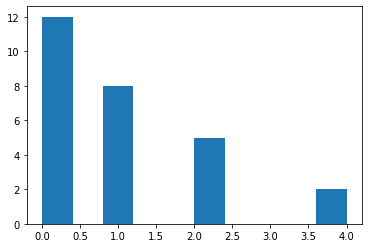


Summary Statistics
               0
count  27.000000
mean    0.962963
std     1.159625
min     0.000000
25%     0.000000
50%     1.000000
75%     1.500000
max     4.000000


VERITASINESS
Number of Attempts


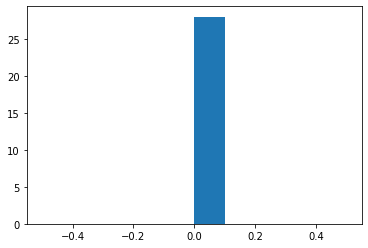


Summary Statistics
          0
count  28.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SUM_DIGITS
Number of Attempts


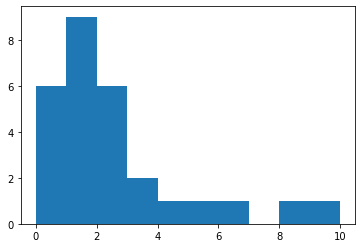


Summary Statistics
               0
count  28.000000
mean    2.142857
std     2.460266
min     0.000000
25%     1.000000
50%     1.000000
75%     2.250000
max    10.000000


FALLING
Number of Attempts


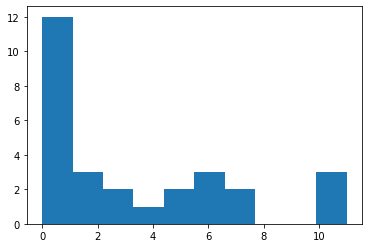


Summary Statistics
               0
count  28.000000
mean    3.535714
std     3.458560
min     0.000000
25%     1.000000
50%     2.000000
75%     6.000000
max    11.000000


BOTH_POSITIVE
Number of Attempts


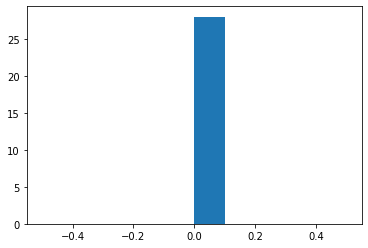


Summary Statistics
          0
count  28.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CONTROL
Number of Attempts


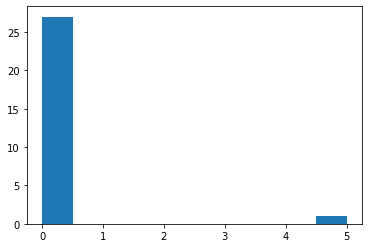


Summary Statistics
               0
count  28.000000
mean    0.178571
std     0.944911
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     5.000000


DEBUGGING-QUIZ
Number of Attempts


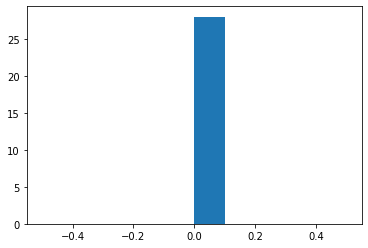


Summary Statistics
          0
count  28.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [146]:
num_attempts_graphs_by_level('lab01.csv')

In [128]:
name = 'lab01.csv'
load_assignment_df(name)
questions = get_questions(assignment_dfs[name])
questions = ['sum_digits']
num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
for q in questions:
    print()
    print(f"{q.upper()}")
    temp = np.array(list(num_attempts_per_question[q].values()))
#     print(len(temp))
    temp = reject_outliers(temp)
    temp_final = pd.DataFrame(list(temp))
    print()
    print("Summary Statistics")
    summary = temp_final.describe()
    print(summary)
    print()

# plot_num_attempts_per_question(num_attempts_per_question, questions)
# generate_num_attempts('lab01.csv', ['double_eights'])


SUM_DIGITS

Summary Statistics
                 0
count  1078.000000
mean      2.631725
std       2.454563
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      11.000000



In [135]:
summary_list = summary.values.tolist()
summary_list = [str(s[0]) for s in summary_list]
print(','.join(summary_list))

1078.0,2.631725417439703,2.45456295207984,0.0,1.0,2.0,3.0,11.0


In [157]:
print_comma_separated_summary_statistics('lab01-sp22.csv', ['digit_pos_match', 'add_in_range', 'falling', 'sum_digits'], outlier_threshold=7)

digit_pos_match
939.0,4.152289669861555,3.7614392089197057,0.0,1.0,3.0,6.0,16.0
add_in_range
925.0,4.206486486486487,3.932267595513871,0.0,1.0,3.0,6.0,16.0
falling
1019.0,3.97252208047105,3.741293838461556,0.0,1.0,3.0,6.0,16.0
sum_digits
1004.0,2.0707171314741037,1.8193539888803318,0.0,1.0,1.0,3.0,8.0


In [145]:
print_comma_separated_summary_statistics('lab01.csv', ['digit_pos_match', 'add_in_range', 'falling', 'sum_digits'])

digit_pos_match
1136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
add_in_range
1136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
falling
1097.0,4.161349134001823,4.267133904017901,0.0,1.0,3.0,6.0,22.0
sum_digits
1078.0,2.631725417439703,2.45456295207984,0.0,1.0,2.0,3.0,11.0


In [155]:
print_comma_separated_summary_statistics('lab02-sp22.csv', ['count_cond', 'hop','lambda_curry2','digit_index_factory'])

count_cond
1003.0,4.725822532402792,4.673960780500352,0.0,1.0,3.0,7.0,22.0
hop
1012.0,4.1561264822134385,4.200152135133836,0.0,1.0,3.0,5.0,22.0
lambda_curry_2
1045.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
digit_index_factory
979.0,4.886618998978549,4.967832590077221,0.0,1.0,3.0,7.0,22.0


##  Lab 02

Generating num attempts for lab02-sp22.csv, using ['Higher Order Functions', 'cycle', 'composer', 'Lambda the Free', 'composite_identity', 'digit_index_factory', 'lambda_curry2_syntax_check', 'hop', 'count_cond', 'lambda_curry2']

HIGHER ORDER FUNCTIONS
Number of Attempts


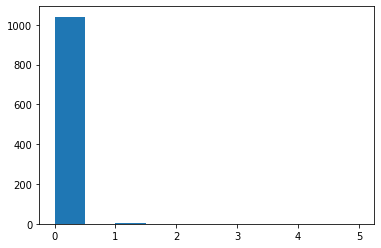


Summary Statistics
                 0
count  1045.000000
mean      0.007656
std       0.163589
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       5.000000


CYCLE
Number of Attempts


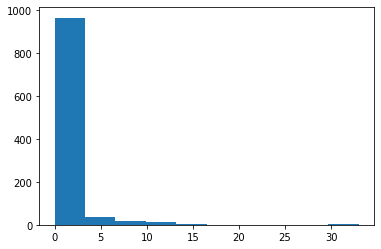


Summary Statistics
                0
count  1045.00000
mean      0.82201
std       2.85487
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max      33.00000


COMPOSER
Number of Attempts


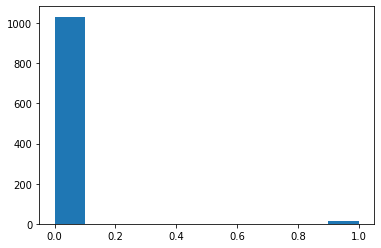


Summary Statistics
                 0
count  1045.000000
mean      0.012440
std       0.110893
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


LAMBDA THE FREE
Number of Attempts


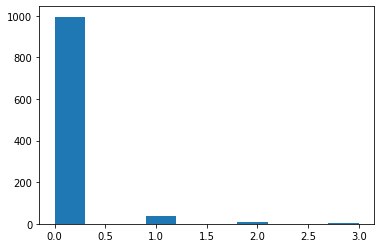


Summary Statistics
                 0
count  1045.000000
mean      0.061244
std       0.296984
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000


COMPOSITE_IDENTITY
Number of Attempts


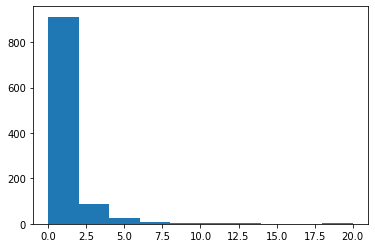


Summary Statistics
                 0
count  1045.000000
mean      0.592344
std       1.829499
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      20.000000


DIGIT_INDEX_FACTORY
Number of Attempts


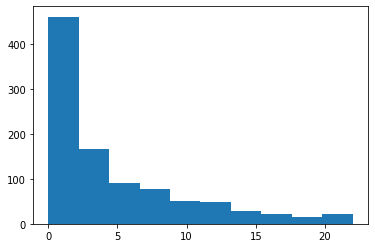


Summary Statistics
                0
count  979.000000
mean     4.886619
std      4.967833
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


LAMBDA_CURRY2_SYNTAX_CHECK
Number of Attempts


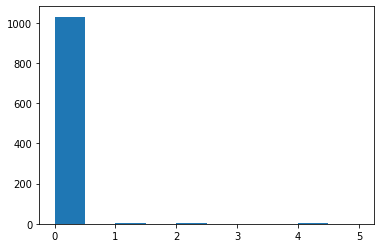


Summary Statistics
                 0
count  1045.000000
mean      0.027751
std       0.280591
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       5.000000


HOP
Number of Attempts


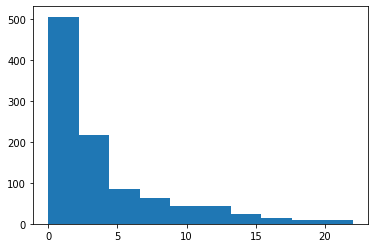


Summary Statistics
                 0
count  1012.000000
mean      4.156126
std       4.200152
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max      22.000000


COUNT_COND
Number of Attempts


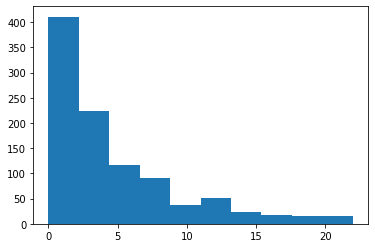


Summary Statistics
                 0
count  1003.000000
mean      4.725823
std       4.673961
min       0.000000
25%       1.000000
50%       3.000000
75%       7.000000
max      22.000000


LAMBDA_CURRY2
Number of Attempts


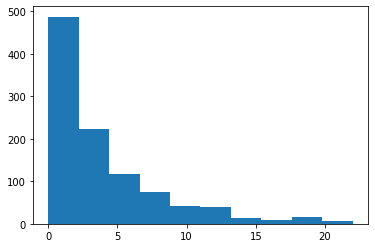


Summary Statistics
                 0
count  1029.000000
mean      4.100097
std       4.089786
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      22.000000



In [148]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab02-sp22.csv')


Generating num attempts for lab02-sp22.csv, stratified by level, using ['Higher Order Functions', 'cycle', 'composer', 'Lambda the Free', 'composite_identity', 'digit_index_factory', 'lambda_curry2_syntax_check', 'hop', 'count_cond', 'lambda_curry2']
BEGINNER

HIGHER ORDER FUNCTIONS
Number of Attempts


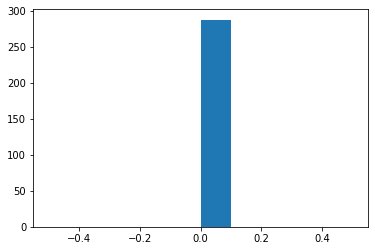


Summary Statistics
           0
count  288.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CYCLE
Number of Attempts


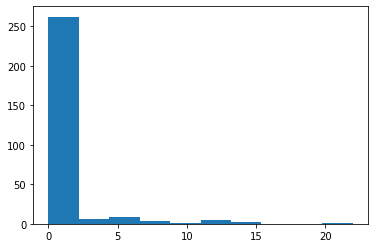


Summary Statistics
                0
count  288.000000
mean     0.795139
std      2.691394
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     22.000000


COMPOSER
Number of Attempts


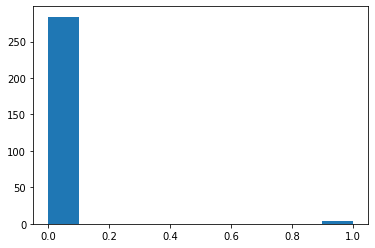


Summary Statistics
                0
count  288.000000
mean     0.013889
std      0.117234
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


LAMBDA THE FREE
Number of Attempts


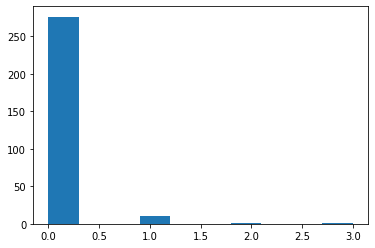


Summary Statistics
                0
count  288.000000
mean     0.052083
std      0.278240
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


COMPOSITE_IDENTITY
Number of Attempts


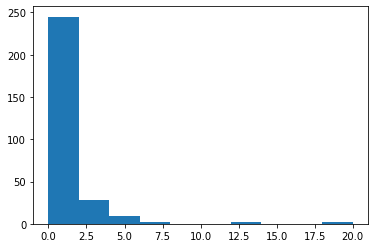


Summary Statistics
                0
count  288.000000
mean     0.701389
std      2.181902
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     20.000000


DIGIT_INDEX_FACTORY
Number of Attempts


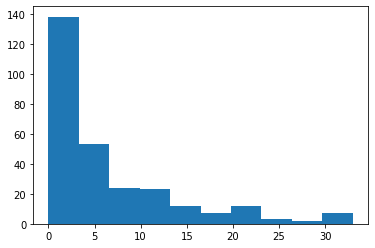


Summary Statistics
                0
count  281.000000
mean     6.679715
std      7.254844
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     33.000000


LAMBDA_CURRY2_SYNTAX_CHECK
Number of Attempts


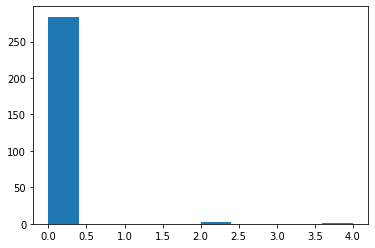


Summary Statistics
                0
count  288.000000
mean     0.034722
std      0.310405
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


HOP
Number of Attempts


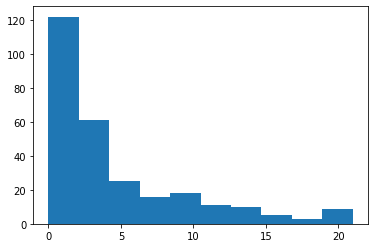


Summary Statistics
                0
count  280.000000
mean     4.917857
std      4.816753
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     21.000000


COUNT_COND
Number of Attempts


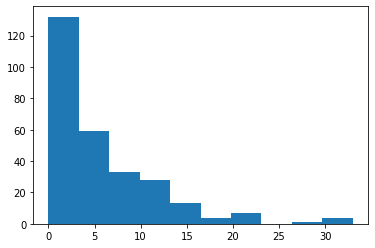


Summary Statistics
                0
count  281.000000
mean     5.829181
std      6.125999
min      0.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     33.000000


LAMBDA_CURRY2
Number of Attempts


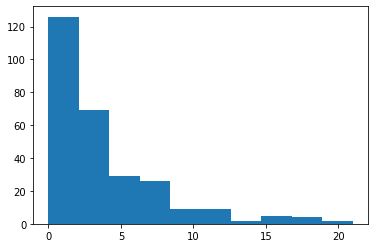


Summary Statistics
                0
count  281.000000
mean     4.181495
std      3.928715
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000

INTERMEDIATE

HIGHER ORDER FUNCTIONS
Number of Attempts


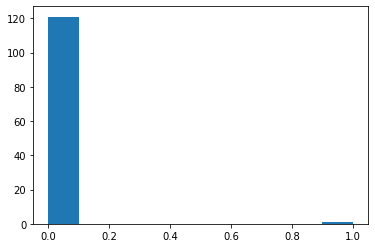


Summary Statistics
                0
count  122.000000
mean     0.008197
std      0.090536
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CYCLE
Number of Attempts


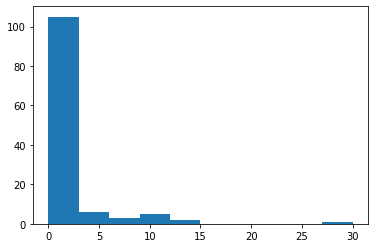


Summary Statistics
                0
count  122.000000
mean     1.303279
std      3.841680
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     30.000000


COMPOSER
Number of Attempts


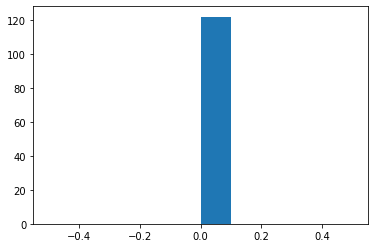


Summary Statistics
           0
count  122.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


LAMBDA THE FREE
Number of Attempts


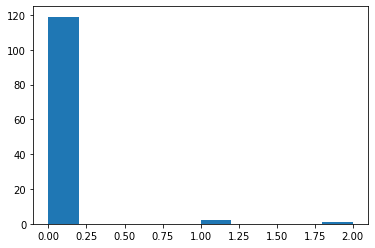


Summary Statistics
                0
count  122.000000
mean     0.032787
std      0.220234
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


COMPOSITE_IDENTITY
Number of Attempts


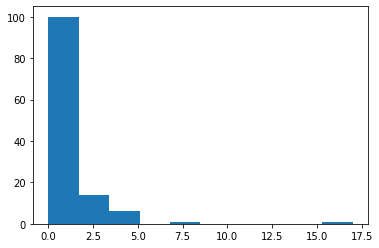


Summary Statistics
                0
count  122.000000
mean     0.770492
std      1.982514
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max     17.000000


DIGIT_INDEX_FACTORY
Number of Attempts


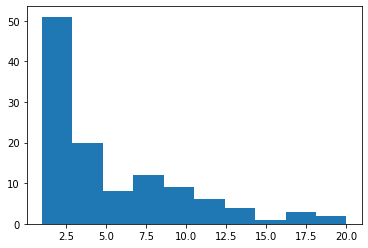


Summary Statistics
                0
count  116.000000
mean     5.017241
std      4.613746
min      1.000000
25%      1.750000
50%      3.000000
75%      7.250000
max     20.000000


LAMBDA_CURRY2_SYNTAX_CHECK
Number of Attempts


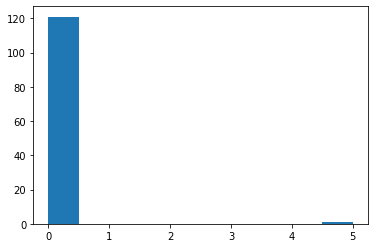


Summary Statistics
                0
count  122.000000
mean     0.040984
std      0.452679
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


HOP
Number of Attempts


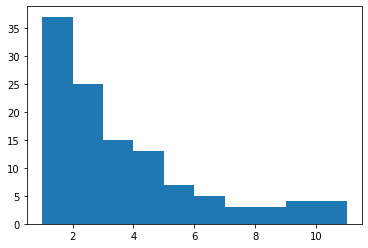


Summary Statistics
                0
count  116.000000
mean     3.224138
std      2.597946
min      1.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


COUNT_COND
Number of Attempts


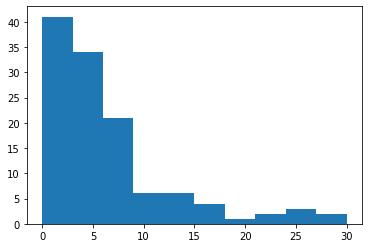


Summary Statistics
                0
count  120.000000
mean     6.100000
std      6.285103
min      0.000000
25%      2.000000
50%      3.500000
75%      8.000000
max     30.000000


LAMBDA_CURRY2
Number of Attempts


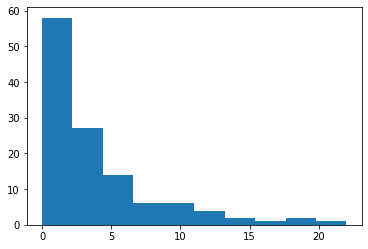


Summary Statistics
                0
count  121.000000
mean     4.165289
std      4.227582
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     22.000000

ADVANCED

HIGHER ORDER FUNCTIONS
Number of Attempts


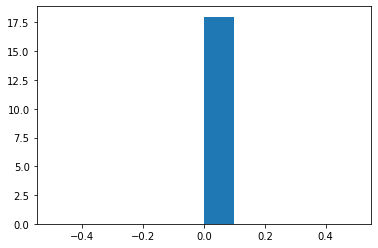


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CYCLE
Number of Attempts


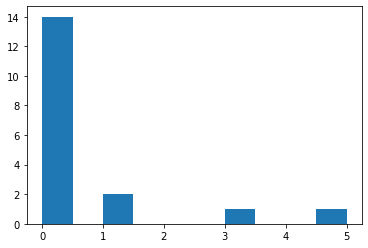


Summary Statistics
               0
count  18.000000
mean    0.555556
std     1.338226
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     5.000000


COMPOSER
Number of Attempts


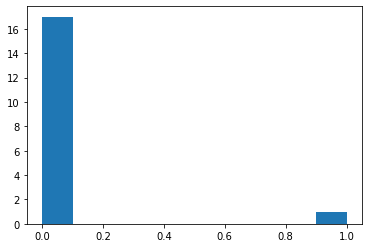


Summary Statistics
               0
count  18.000000
mean    0.055556
std     0.235702
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


LAMBDA THE FREE
Number of Attempts


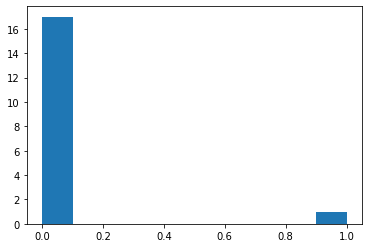


Summary Statistics
               0
count  18.000000
mean    0.055556
std     0.235702
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


COMPOSITE_IDENTITY
Number of Attempts


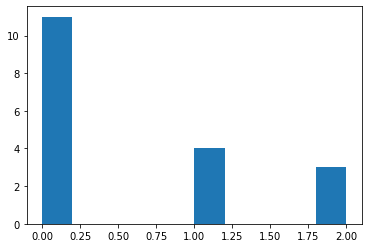


Summary Statistics
               0
count  18.000000
mean    0.555556
std     0.783823
min     0.000000
25%     0.000000
50%     0.000000
75%     1.000000
max     2.000000


DIGIT_INDEX_FACTORY
Number of Attempts


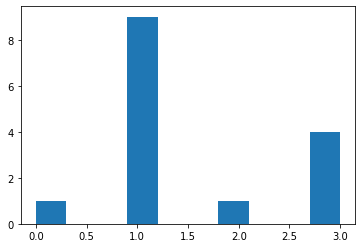


Summary Statistics
               0
count  15.000000
mean    1.533333
std     0.990430
min     0.000000
25%     1.000000
50%     1.000000
75%     2.500000
max     3.000000


LAMBDA_CURRY2_SYNTAX_CHECK
Number of Attempts


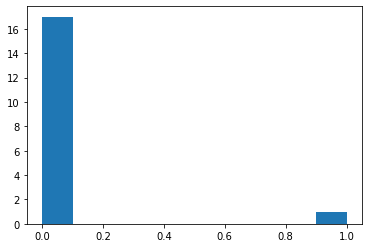


Summary Statistics
               0
count  18.000000
mean    0.055556
std     0.235702
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


HOP
Number of Attempts


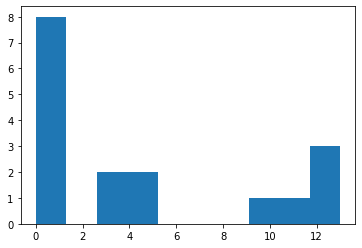


Summary Statistics
               0
count  17.000000
mean    4.705882
std     4.792764
min     0.000000
25%     1.000000
50%     3.000000
75%    10.000000
max    13.000000


COUNT_COND
Number of Attempts


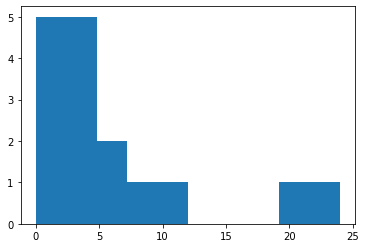


Summary Statistics
             0
count  16.0000
mean    6.3125
std     6.7500
min     0.0000
25%     2.0000
50%     4.0000
75%     7.5000
max    24.0000


LAMBDA_CURRY2
Number of Attempts


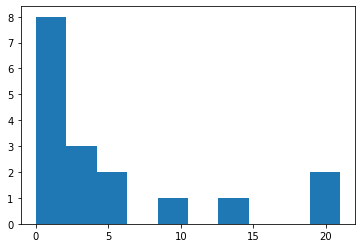


Summary Statistics
               0
count  17.000000
mean    5.529412
std     6.472226
min     0.000000
25%     1.000000
50%     4.000000
75%     6.000000
max    21.000000



In [105]:
num_attempts_graphs_by_level('lab02-sp22.csv')

Generating num attempts for lab02.csv, using ['Higher Order Functions', 'cake', 'both_paths', 'cycle', 'compose1', 'Lambda the Free', 'composite_identity', 'coung_cond', 'count_cond', 'lambda_curry2']

HIGHER ORDER FUNCTIONS
Number of Attempts


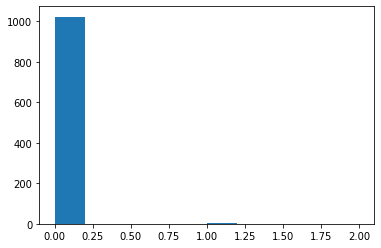


Summary Statistics
                 0
count  1028.000000
mean      0.005837
std       0.088066
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


CAKE
Number of Attempts


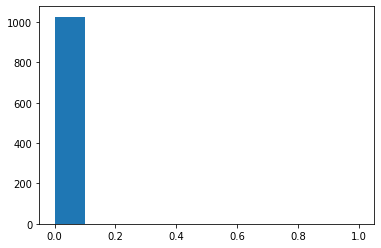


Summary Statistics
                 0
count  1028.000000
mean      0.000973
std       0.031189
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


BOTH_PATHS
Number of Attempts


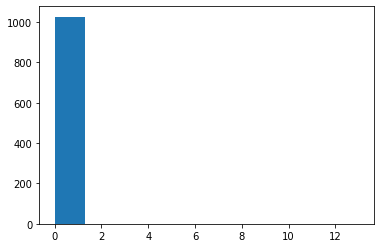


Summary Statistics
                 0
count  1028.000000
mean      0.012646
std       0.405459
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      13.000000


CYCLE
Number of Attempts


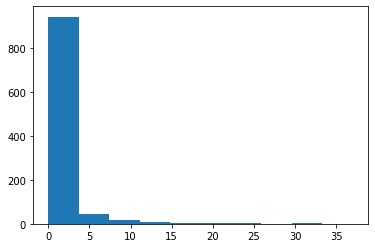


Summary Statistics
                 0
count  1028.000000
mean      0.927043
std       3.355811
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      37.000000


COMPOSE1
Number of Attempts


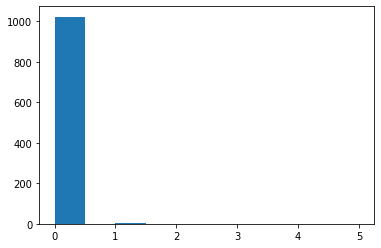


Summary Statistics
                 0
count  1028.000000
mean      0.010700
std       0.189506
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       5.000000


LAMBDA THE FREE
Number of Attempts


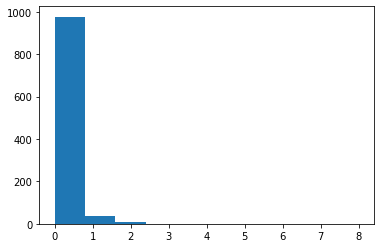


Summary Statistics
                 0
count  1028.000000
mean      0.073930
std       0.435053
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       8.000000


COMPOSITE_IDENTITY
Number of Attempts


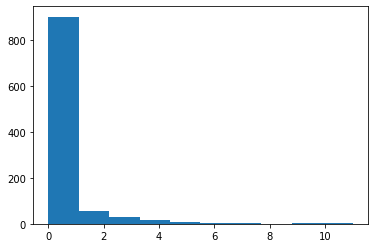


Summary Statistics
                 0
count  1028.000000
mean      0.512646
std       1.292942
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      11.000000


COUNG_COND
Number of Attempts


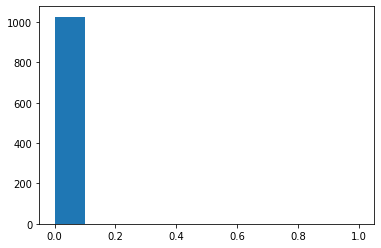


Summary Statistics
                 0
count  1028.000000
mean      0.000973
std       0.031189
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


COUNT_COND
Number of Attempts


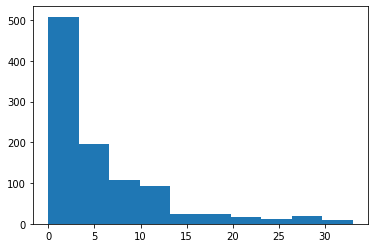


Summary Statistics
                 0
count  1007.000000
mean      5.879841
std       6.511380
min       0.000000
25%       2.000000
50%       3.000000
75%       8.000000
max      33.000000


LAMBDA_CURRY2
Number of Attempts


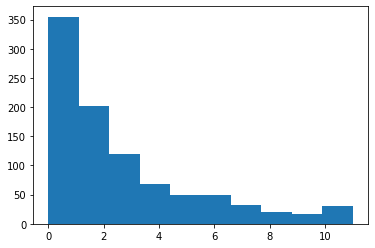


Summary Statistics
                0
count  945.000000
mean     2.912169
std      2.502903
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000



In [149]:
num_attempts_graphs('lab02.csv')


Generating num attempts for lab02.csv, stratified by level, using ['Higher Order Functions', 'cake', 'both_paths', 'cycle', 'compose1', 'Lambda the Free', 'composite_identity', 'coung_cond', 'count_cond', 'lambda_curry2']
BEGINNER

HIGHER ORDER FUNCTIONS
Number of Attempts


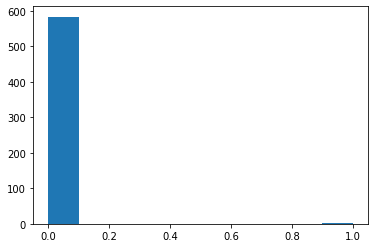


Summary Statistics
                0
count  585.000000
mean     0.003419
std      0.058420
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CAKE
Number of Attempts


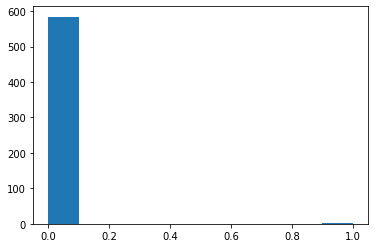


Summary Statistics
                0
count  585.000000
mean     0.001709
std      0.041345
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


BOTH_PATHS
Number of Attempts


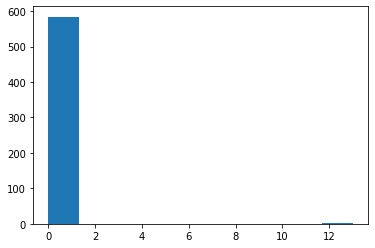


Summary Statistics
                0
count  585.000000
mean     0.022222
std      0.537484
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


CYCLE
Number of Attempts


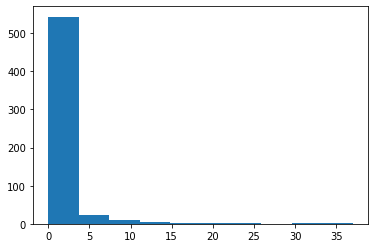


Summary Statistics
                0
count  585.000000
mean     0.815385
std      3.278735
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     37.000000


COMPOSE1
Number of Attempts


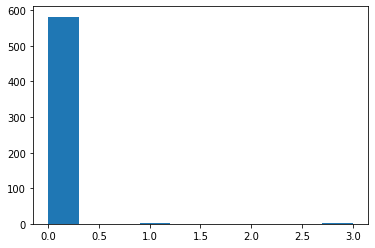


Summary Statistics
                0
count  585.000000
mean     0.008547
std      0.136976
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


LAMBDA THE FREE
Number of Attempts


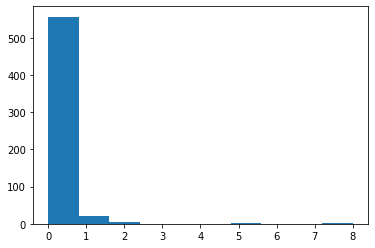


Summary Statistics
                0
count  585.000000
mean     0.075214
std      0.465764
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      8.000000


COMPOSITE_IDENTITY
Number of Attempts


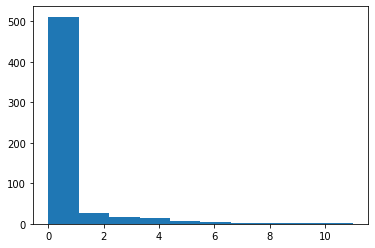


Summary Statistics
                0
count  585.000000
mean     0.535043
std      1.363373
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


COUNG_COND
Number of Attempts


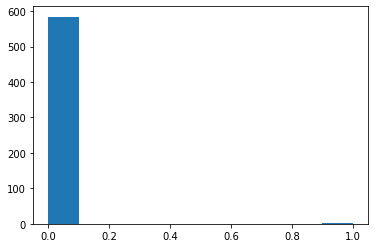


Summary Statistics
                0
count  585.000000
mean     0.001709
std      0.041345
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


COUNT_COND
Number of Attempts


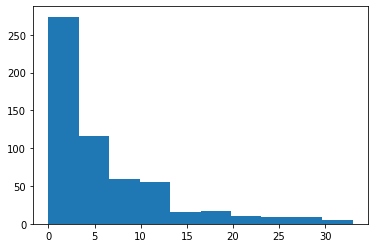


Summary Statistics
                0
count  569.000000
mean     6.128295
std      6.580439
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     33.000000


LAMBDA_CURRY2
Number of Attempts


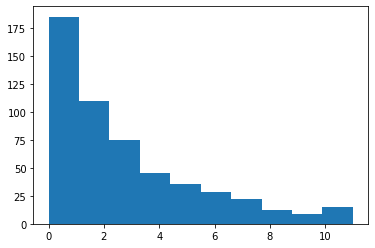


Summary Statistics
                0
count  537.000000
mean     3.029795
std      2.459191
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

INTERMEDIATE

HIGHER ORDER FUNCTIONS
Number of Attempts


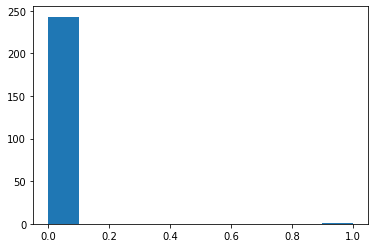


Summary Statistics
                0
count  244.000000
mean     0.004098
std      0.064018
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CAKE
Number of Attempts


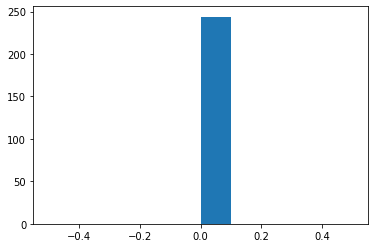


Summary Statistics
           0
count  244.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


BOTH_PATHS
Number of Attempts


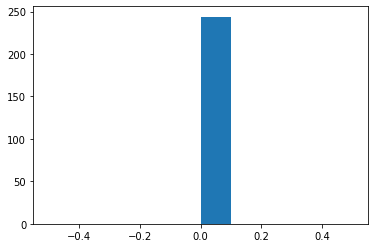


Summary Statistics
           0
count  244.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CYCLE
Number of Attempts


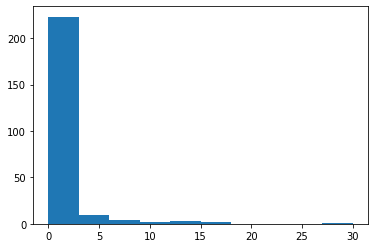


Summary Statistics
                0
count  244.000000
mean     0.860656
std      3.119870
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     30.000000


COMPOSE1
Number of Attempts


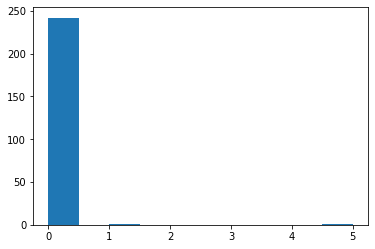


Summary Statistics
                0
count  244.000000
mean     0.024590
std      0.326173
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


LAMBDA THE FREE
Number of Attempts


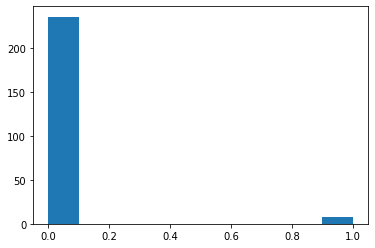


Summary Statistics
                0
count  244.000000
mean     0.032787
std      0.178444
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


COMPOSITE_IDENTITY
Number of Attempts


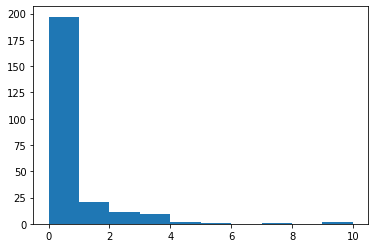


Summary Statistics
               0
count  244.00000
mean     0.45082
std      1.28686
min      0.00000
25%      0.00000
50%      0.00000
75%      0.00000
max     10.00000


COUNG_COND
Number of Attempts


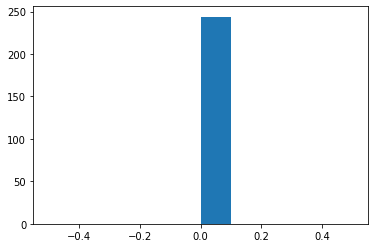


Summary Statistics
           0
count  244.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COUNT_COND
Number of Attempts


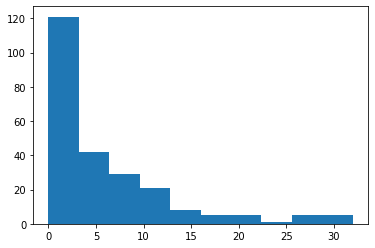


Summary Statistics
                0
count  242.000000
mean     6.157025
std      6.699239
min      0.000000
25%      2.000000
50%      3.500000
75%      8.000000
max     32.000000


LAMBDA_CURRY2
Number of Attempts


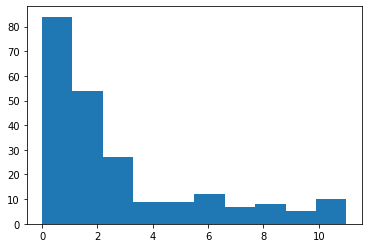


Summary Statistics
                0
count  225.000000
mean     3.013333
std      2.685078
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

ADVANCED

HIGHER ORDER FUNCTIONS
Number of Attempts


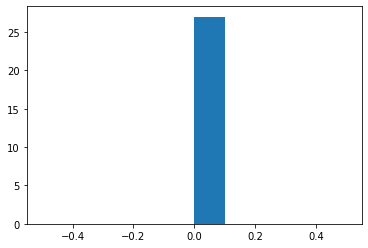


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CAKE
Number of Attempts


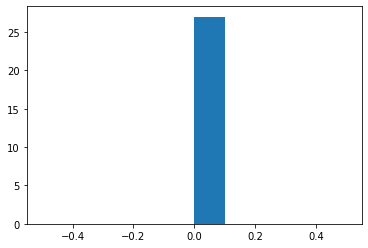


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


BOTH_PATHS
Number of Attempts


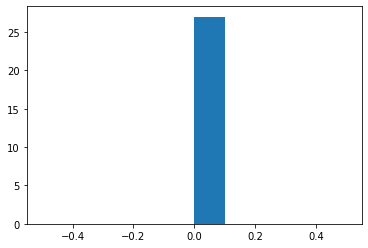


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CYCLE
Number of Attempts


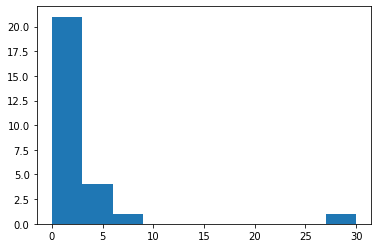


Summary Statistics
               0
count  27.000000
mean    2.037037
std     5.860438
min     0.000000
25%     0.000000
50%     0.000000
75%     1.500000
max    30.000000


COMPOSE1
Number of Attempts


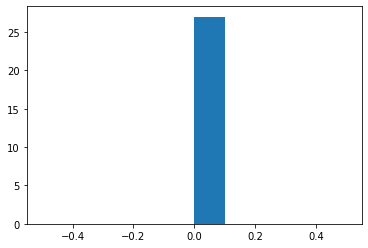


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


LAMBDA THE FREE
Number of Attempts


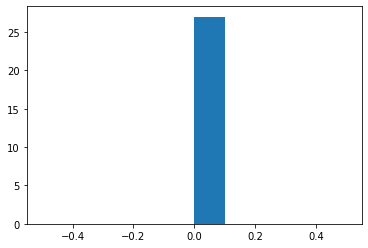


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COMPOSITE_IDENTITY
Number of Attempts


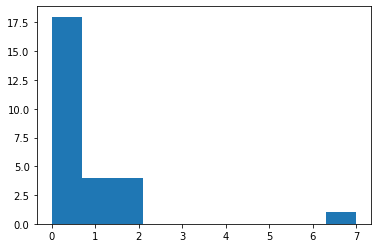


Summary Statistics
               0
count  27.000000
mean    0.703704
std     1.462738
min     0.000000
25%     0.000000
50%     0.000000
75%     1.000000
max     7.000000


COUNG_COND
Number of Attempts


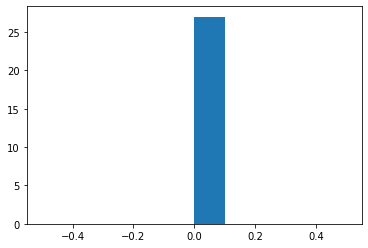


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COUNT_COND
Number of Attempts


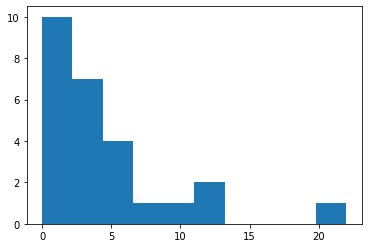


Summary Statistics
               0
count  26.000000
mean    4.730769
std     4.837832
min     0.000000
25%     2.000000
50%     3.000000
75%     6.000000
max    22.000000


LAMBDA_CURRY2
Number of Attempts


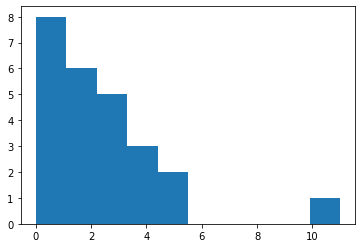


Summary Statistics
              0
count  25.00000
mean    2.60000
std     2.27303
min     0.00000
25%     1.00000
50%     2.00000
75%     3.00000
max    11.00000



In [150]:
num_attempts_graphs_by_level('lab02.csv')

In [147]:
print_comma_separated_summary_statistics('lab02-sp22.csv', ['hop', 'digit_index_factory', 'lambda_curry2', 'count_cond'])

hop
1012.0,4.1561264822134385,4.200152135133836,0.0,1.0,3.0,5.0,22.0
digit_index_factory
979.0,4.886618998978549,4.967832590077221,0.0,1.0,3.0,7.0,22.0
lambda_curry2
1029.0,4.100097181729835,4.089786318455323,0.0,1.0,3.0,6.0,22.0
count_cond
1003.0,4.725822532402792,4.673960780500352,0.0,1.0,3.0,7.0,22.0


In [148]:
print_comma_separated_summary_statistics('lab02.csv', ['lambda_curry2', 'count_cond'])

lambda_curry2
945.0,2.912169312169312,2.5029029867602803,0.0,1.0,2.0,4.0,11.0
count_cond
1007.0,5.879841112214499,6.51138021778292,0.0,2.0,3.0,8.0,33.0


## Lab 04

Generating num attempts for lab01-sp22.csv, using ['double_eights', 'k_occurrence', 'Veritasiness', 'digit_pos_match', 'add_in_range', 'sum_digits', 'falling', 'Control', 'begin', 'debugging-quiz']

DOUBLE_EIGHTS
Number of Attempts


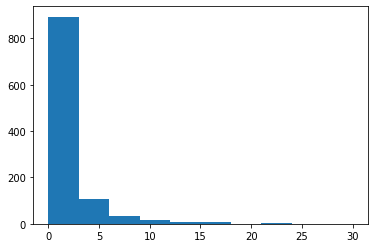


Summary Statistics
                 0
count  1072.000000
mean      1.322761
std       2.933169
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      30.000000


K_OCCURRENCE
Number of Attempts


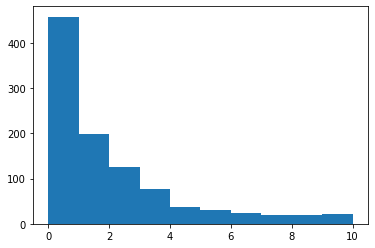


Summary Statistics
                 0
count  1013.000000
mean      1.610069
std       2.261767
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max      10.000000


VERITASINESS
Number of Attempts


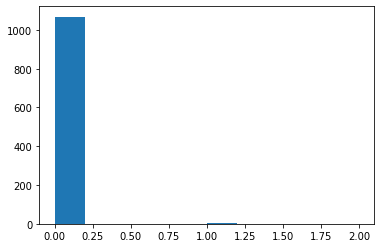


Summary Statistics
                 0
count  1072.000000
mean      0.004664
std       0.080710
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


DIGIT_POS_MATCH
Number of Attempts


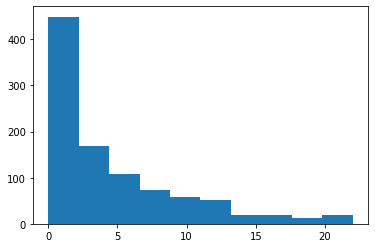


Summary Statistics
                0
count  980.000000
mean     4.782653
std      4.772742
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


ADD_IN_RANGE
Number of Attempts


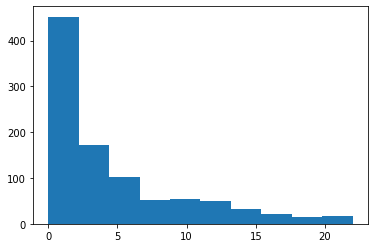


Summary Statistics
                0
count  969.000000
mean     4.884417
std      4.956532
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


SUM_DIGITS
Number of Attempts


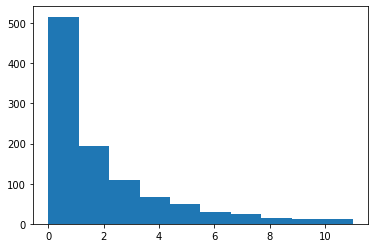


Summary Statistics
                 0
count  1030.000000
mean      2.264078
std       2.165228
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      11.000000


FALLING
Number of Attempts


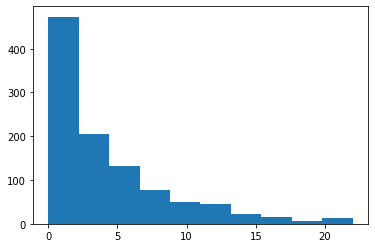


Summary Statistics
                 0
count  1042.000000
mean      4.316699
std       4.358512
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      22.000000


CONTROL
Number of Attempts


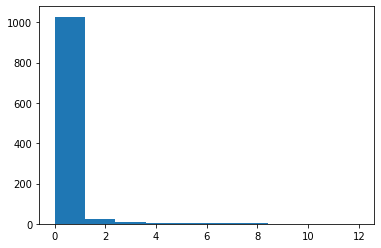


Summary Statistics
                 0
count  1072.000000
mean      0.197761
std       0.822237
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      12.000000


BEGIN
Number of Attempts


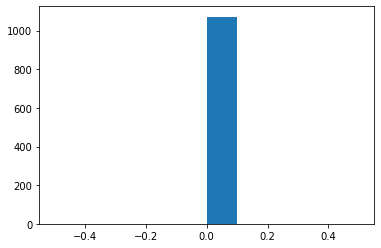


Summary Statistics
            0
count  1072.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0


DEBUGGING-QUIZ
Number of Attempts


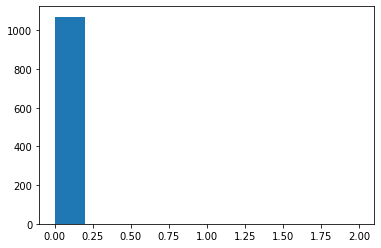


Summary Statistics
                 0
count  1072.000000
mean      0.002799
std       0.068269
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000



In [106]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab04-sp22.csv')


Generating num attempts for lab04-sp22.csv, stratified by level, using ['line_stepper', 'pascal', 'Squared Virahanka Fibonacci', 'paths', 'summation']
BEGINNER

LINE_STEPPER
Number of Attempts


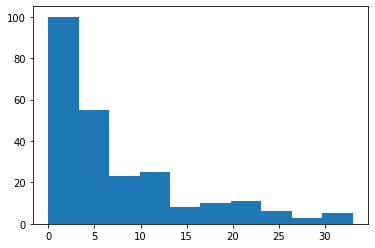


Summary Statistics
                0
count  246.000000
mean     7.500000
std      7.509857
min      0.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     33.000000


PASCAL
Number of Attempts


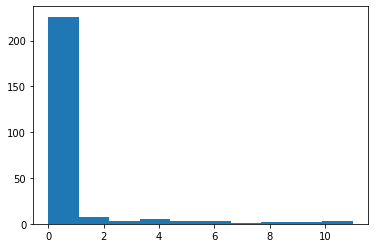


Summary Statistics
                0
count  255.000000
mean     0.647059
std      1.870024
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


SQUARED VIRAHANKA FIBONACCI
Number of Attempts


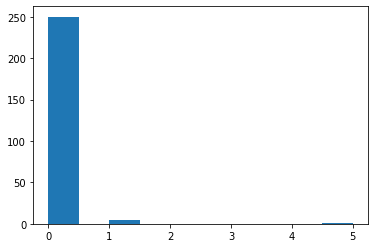


Summary Statistics
                0
count  255.000000
mean     0.035294
std      0.336040
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


PATHS
Number of Attempts


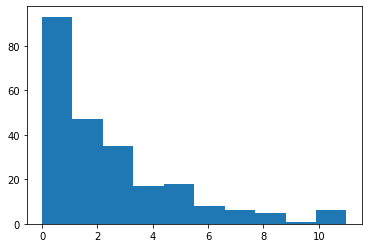


Summary Statistics
                0
count  236.000000
mean     2.686441
std      2.262362
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


SUMMATION
Number of Attempts


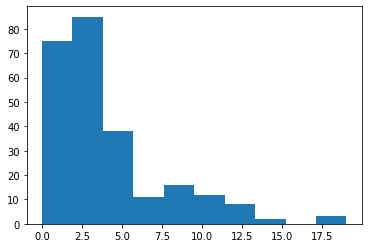


Summary Statistics
                0
count  250.000000
mean     3.780000
std      3.639862
min      0.000000
25%      1.000000
50%      2.000000
75%      5.000000
max     19.000000

INTERMEDIATE

LINE_STEPPER
Number of Attempts


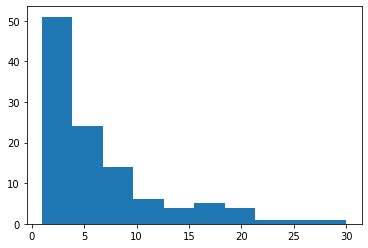


Summary Statistics
                0
count  111.000000
mean     5.963964
std      6.227400
min      1.000000
25%      1.000000
50%      4.000000
75%      8.000000
max     30.000000


PASCAL
Number of Attempts


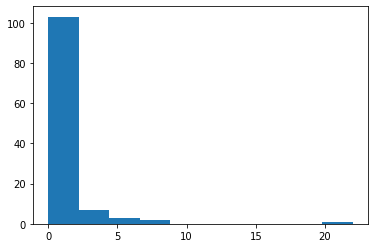


Summary Statistics
                0
count  116.000000
mean     0.862069
std      2.498335
min      0.000000
25%      0.000000
50%      0.000000
75%      0.250000
max     22.000000


SQUARED VIRAHANKA FIBONACCI
Number of Attempts


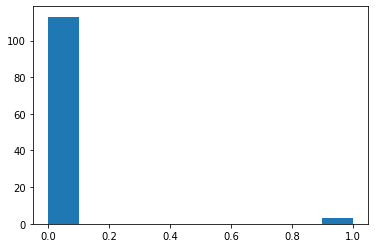


Summary Statistics
                0
count  116.000000
mean     0.025862
std      0.159412
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


PATHS
Number of Attempts


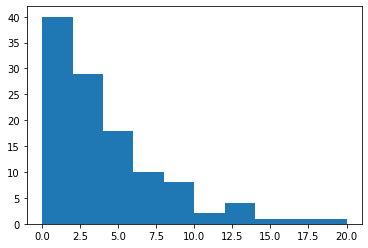


Summary Statistics
                0
count  114.000000
mean     3.956140
std      3.747307
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     20.000000


SUMMATION
Number of Attempts


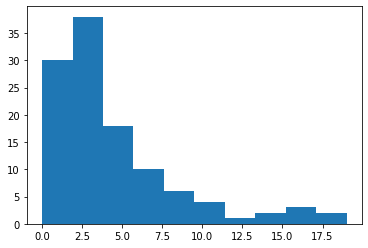


Summary Statistics
                0
count  114.000000
mean     4.289474
std      4.147125
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     19.000000

ADVANCED

LINE_STEPPER
Number of Attempts


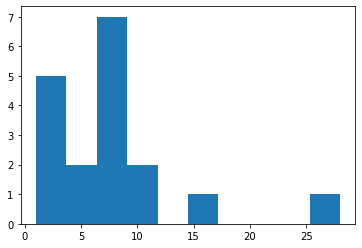


Summary Statistics
               0
count  18.000000
mean    7.722222
std     6.533223
min     1.000000
25%     3.250000
50%     7.500000
75%     9.000000
max    28.000000


PASCAL
Number of Attempts


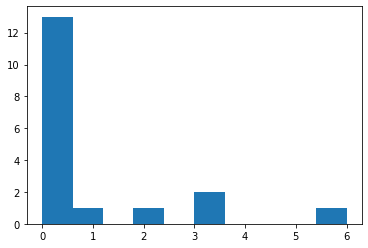


Summary Statistics
               0
count  18.000000
mean    0.833333
std     1.653872
min     0.000000
25%     0.000000
50%     0.000000
75%     0.750000
max     6.000000


SQUARED VIRAHANKA FIBONACCI
Number of Attempts


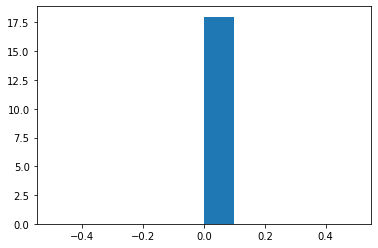


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PATHS
Number of Attempts


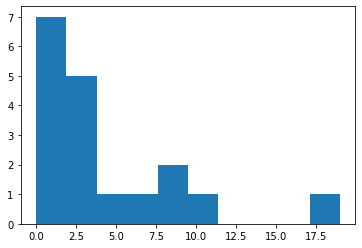


Summary Statistics
               0
count  18.000000
mean    4.333333
std     4.801960
min     0.000000
25%     1.000000
50%     3.000000
75%     5.750000
max    19.000000


SUMMATION
Number of Attempts


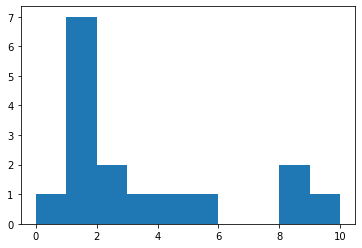


Summary Statistics
               0
count  16.000000
mean    3.062500
std     3.086935
min     0.000000
25%     1.000000
50%     1.500000
75%     4.250000
max    10.000000



In [107]:
num_attempts_graphs_by_level('lab04-sp22.csv')

In [151]:
num_attempts_graphs('lab04.csv')

Generating num attempts for lab04.csv, using []


In [152]:
num_attempts_graphs_by_level('lab04.csv')


Generating num attempts for lab04.csv, stratified by level, using []
BEGINNER
INTERMEDIATE
ADVANCED


## Lab 05

Generating num attempts for lab05-sp22.csv, using ['List Mutation', 'insert_items', 'flatten', 'factors_list', 'replace_elements', 'couple']

LIST MUTATION
Number of Attempts


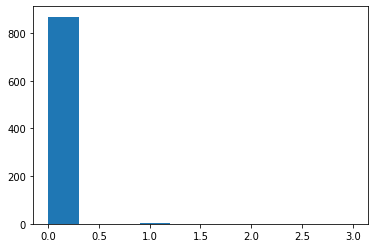


Summary Statistics
                0
count  875.000000
mean     0.010286
std      0.139086
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


INSERT_ITEMS
Number of Attempts


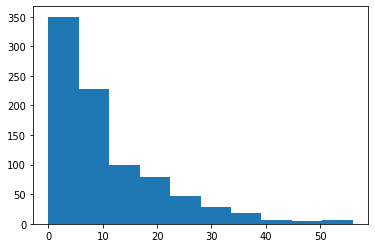


Summary Statistics
                0
count  868.000000
mean    10.485023
std     10.255041
min      0.000000
25%      3.000000
50%      7.000000
75%     15.000000
max     56.000000


FLATTEN
Number of Attempts


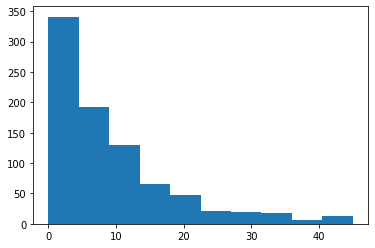


Summary Statistics
                0
count  853.000000
mean     9.161782
std      9.169612
min      0.000000
25%      3.000000
50%      6.000000
75%     12.000000
max     45.000000


FACTORS_LIST
Number of Attempts


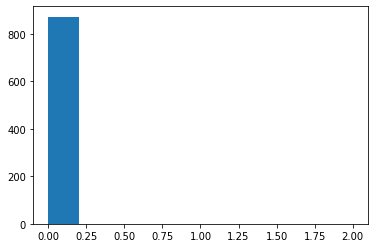


Summary Statistics
                0
count  875.000000
mean     0.003429
std      0.075558
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPLACE_ELEMENTS
Number of Attempts


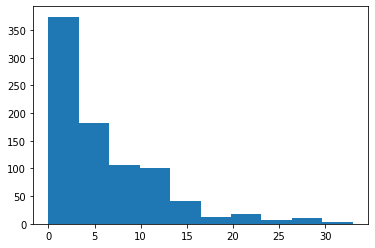


Summary Statistics
                0
count  855.000000
mean     6.242105
std      5.857488
min      0.000000
25%      2.000000
50%      4.000000
75%      8.500000
max     33.000000


COUPLE
Number of Attempts


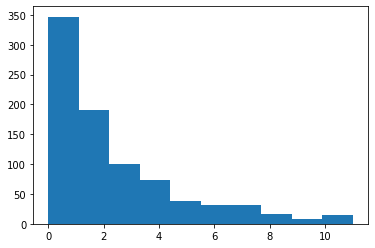


Summary Statistics
                0
count  852.000000
mean     2.620892
std      2.226997
min      0.000000
25%      1.000000
50%      2.000000
75%      3.250000
max     11.000000



In [185]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab05-sp22.csv')


Generating num attempts for lab05-sp22.csv, stratified by level, using ['List Mutation', 'insert_items', 'flatten', 'factors_list', 'replace_elements', 'couple']
BEGINNER

LIST MUTATION
Number of Attempts


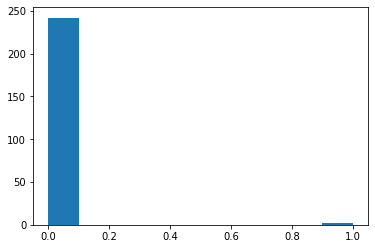


Summary Statistics
                0
count  244.000000
mean     0.008197
std      0.090349
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


INSERT_ITEMS
Number of Attempts


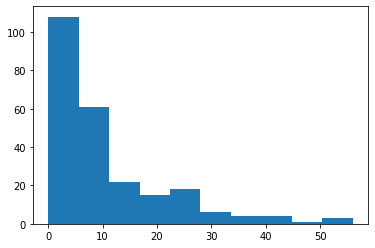


Summary Statistics
                0
count  242.000000
mean    10.293388
std     11.059284
min      0.000000
25%      2.000000
50%      6.500000
75%     14.000000
max     56.000000


FLATTEN
Number of Attempts


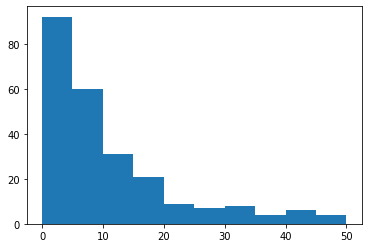


Summary Statistics
                0
count  242.000000
mean    10.545455
std     10.991887
min      0.000000
25%      3.000000
50%      7.000000
75%     14.000000
max     50.000000


FACTORS_LIST
Number of Attempts


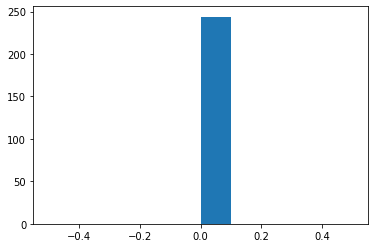


Summary Statistics
           0
count  244.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


REPLACE_ELEMENTS
Number of Attempts


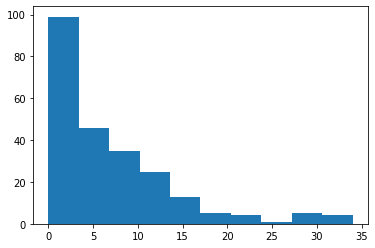


Summary Statistics
                0
count  237.000000
mean     6.987342
std      6.893550
min      0.000000
25%      2.000000
50%      4.000000
75%     10.000000
max     34.000000


COUPLE
Number of Attempts


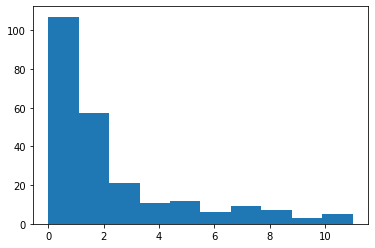


Summary Statistics
                0
count  238.000000
mean     2.554622
std      2.380290
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000

INTERMEDIATE

LIST MUTATION
Number of Attempts


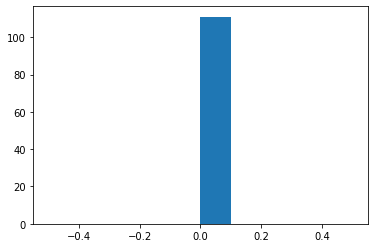


Summary Statistics
           0
count  111.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INSERT_ITEMS
Number of Attempts


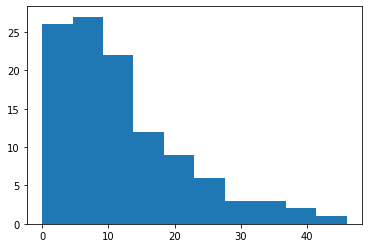


Summary Statistics
                0
count  111.000000
mean    12.252252
std      9.518851
min      0.000000
25%      5.000000
50%     10.000000
75%     18.000000
max     46.000000


FLATTEN
Number of Attempts


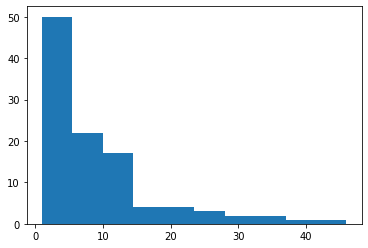


Summary Statistics
                0
count  106.000000
mean     8.849057
std      8.862755
min      1.000000
25%      3.000000
50%      6.000000
75%     11.750000
max     46.000000


FACTORS_LIST
Number of Attempts


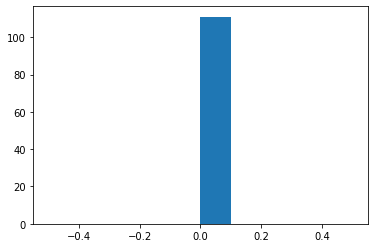


Summary Statistics
           0
count  111.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


REPLACE_ELEMENTS
Number of Attempts


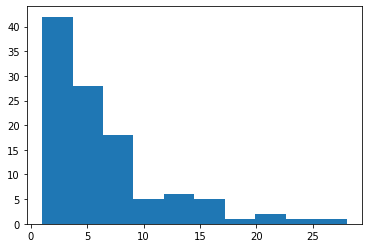


Summary Statistics
                0
count  109.000000
mean     6.302752
std      5.496640
min      1.000000
25%      2.000000
50%      5.000000
75%      8.000000
max     28.000000


COUPLE
Number of Attempts


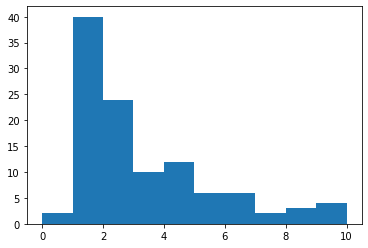


Summary Statistics
                0
count  109.000000
mean     2.825688
std      2.288636
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     10.000000

ADVANCED

LIST MUTATION
Number of Attempts


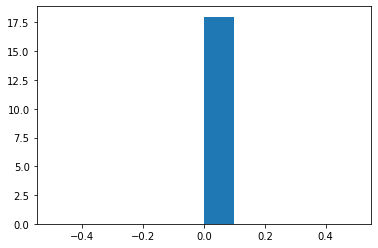


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


INSERT_ITEMS
Number of Attempts


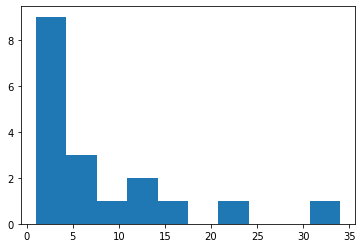


Summary Statistics
               0
count  18.000000
mean    7.777778
std     8.788733
min     1.000000
25%     2.000000
50%     4.500000
75%    10.500000
max    34.000000


FLATTEN
Number of Attempts


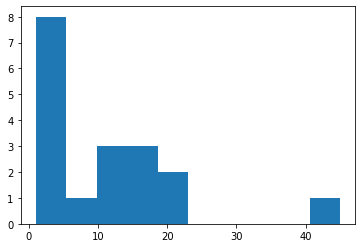


Summary Statistics
               0
count  18.000000
mean   10.888889
std    10.845920
min     1.000000
25%     3.000000
50%     8.000000
75%    16.750000
max    45.000000


FACTORS_LIST
Number of Attempts


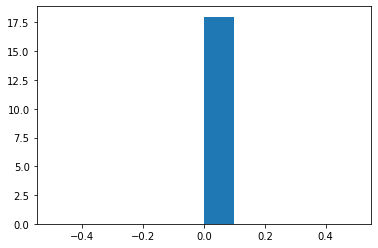


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


REPLACE_ELEMENTS
Number of Attempts


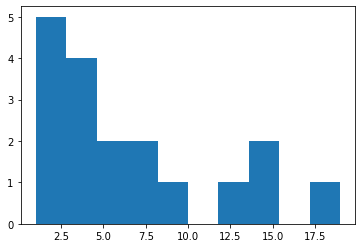


Summary Statistics
               0
count  18.000000
mean    6.666667
std     5.477226
min     1.000000
25%     2.250000
50%     4.500000
75%     8.750000
max    19.000000


COUPLE
Number of Attempts


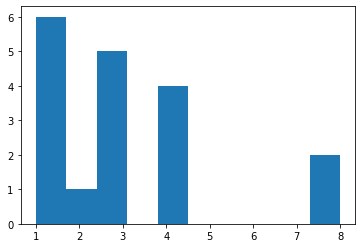


Summary Statistics
               0
count  18.000000
mean    3.055556
std     2.154946
min     1.000000
25%     1.000000
50%     3.000000
75%     4.000000
max     8.000000



In [186]:
num_attempts_graphs_by_level('lab05-sp22.csv')

Generating num attempts for lab05.csv, using ['make_city', 'closer_city', 'random_sent', 'is_leaf', 'sprout_leaves', 'distance', 'check_city_abstraction', 'add_trees', 'closer_cit', 'riffle', 'change_abstraction', 'construct_sent', 'check_abstraction', 'berry_finder', 'coords', 'couple', 'build_successors_table']

MAKE_CITY
Number of Attempts


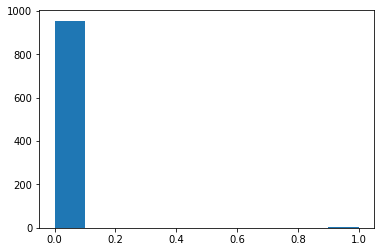


Summary Statistics
                0
count  957.000000
mean     0.002090
std      0.045691
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CLOSER_CITY
Number of Attempts


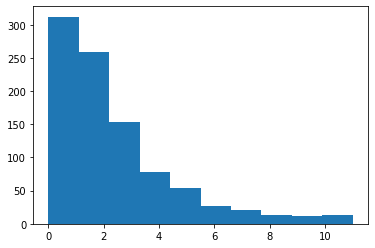


Summary Statistics
                0
count  943.000000
mean     2.634146
std      2.078803
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


RANDOM_SENT
Number of Attempts


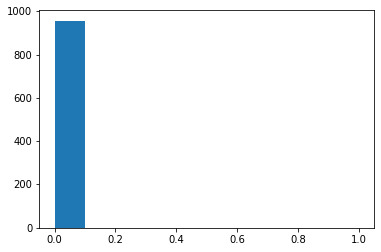


Summary Statistics
                0
count  957.000000
mean     0.001045
std      0.032325
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


IS_LEAF
Number of Attempts


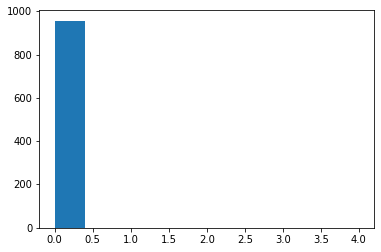


Summary Statistics
                0
count  957.000000
mean     0.004180
std      0.129302
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


SPROUT_LEAVES
Number of Attempts


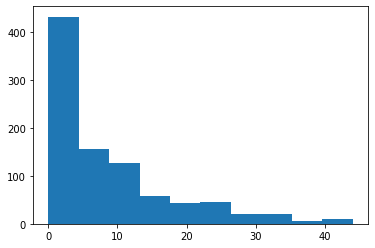


Summary Statistics
                0
count  918.000000
mean     8.596950
std      9.217053
min      0.000000
25%      2.000000
50%      5.000000
75%     12.000000
max     44.000000


DISTANCE
Number of Attempts


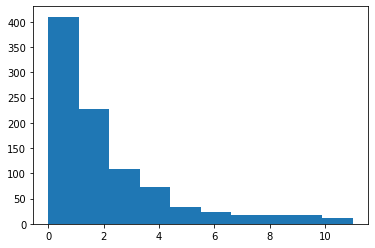


Summary Statistics
                0
count  936.000000
mean     2.418803
std      2.080166
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


CHECK_CITY_ABSTRACTION
Number of Attempts


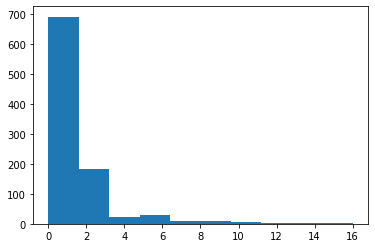


Summary Statistics
                0
count  957.000000
mean     1.647858
std      1.797932
min      0.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     16.000000


ADD_TREES
Number of Attempts


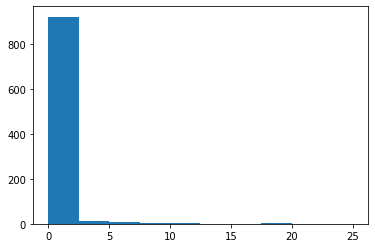


Summary Statistics
               0
count  957.00000
mean     0.30721
std      1.76130
min      0.00000
25%      0.00000
50%      0.00000
75%      0.00000
max     25.00000


CLOSER_CIT
Number of Attempts


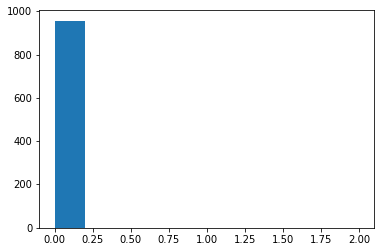


Summary Statistics
                0
count  957.000000
mean     0.002090
std      0.064651
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


RIFFLE
Number of Attempts


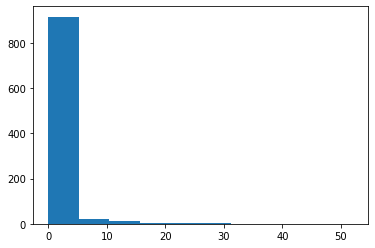


Summary Statistics
                0
count  957.000000
mean     0.700104
std      3.261755
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     52.000000


CHANGE_ABSTRACTION
Number of Attempts


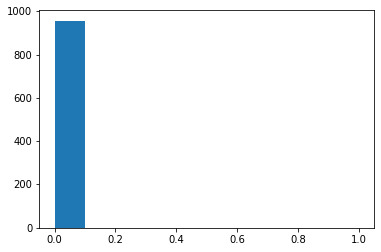


Summary Statistics
                0
count  957.000000
mean     0.001045
std      0.032325
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CONSTRUCT_SENT
Number of Attempts


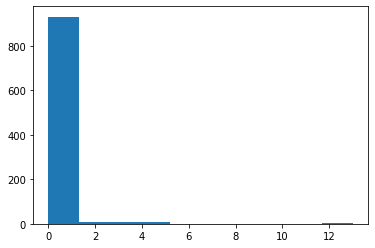


Summary Statistics
                0
count  957.000000
mean     0.120167
std      0.855196
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


CHECK_ABSTRACTION
Number of Attempts


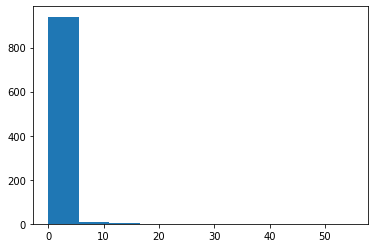


Summary Statistics
                0
count  957.000000
mean     1.262278
std      2.423121
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     55.000000


BERRY_FINDER
Number of Attempts


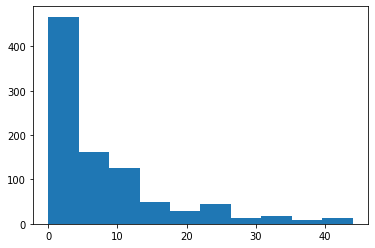


Summary Statistics
                0
count  928.000000
mean     7.976293
std      9.035915
min      0.000000
25%      2.000000
50%      4.000000
75%     11.000000
max     44.000000


COORDS
Number of Attempts


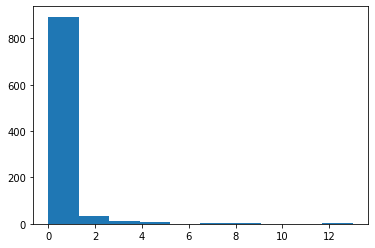


Summary Statistics
                0
count  957.000000
mean     0.265413
std      1.027135
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


COUPLE
Number of Attempts


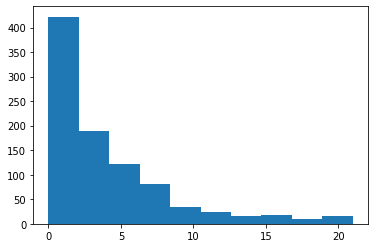


Summary Statistics
                0
count  934.000000
mean     4.381156
std      4.231296
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


BUILD_SUCCESSORS_TABLE
Number of Attempts


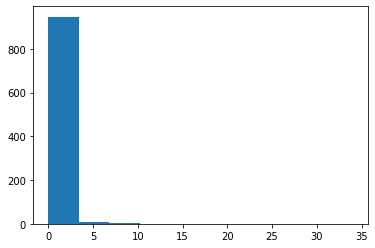


Summary Statistics
                0
count  957.000000
mean     0.126437
std      1.259982
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     34.000000



In [187]:
num_attempts_graphs('lab05.csv')


Generating num attempts for lab05.csv, stratified by level, using ['make_city', 'closer_city', 'random_sent', 'is_leaf', 'sprout_leaves', 'distance', 'check_city_abstraction', 'add_trees', 'closer_cit', 'riffle', 'change_abstraction', 'construct_sent', 'check_abstraction', 'berry_finder', 'coords', 'couple', 'build_successors_table']
BEGINNER

MAKE_CITY
Number of Attempts


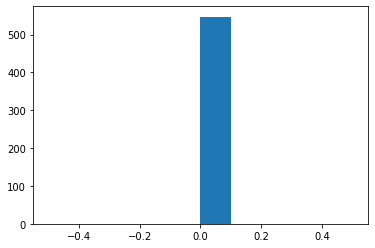


Summary Statistics
           0
count  547.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CLOSER_CITY
Number of Attempts


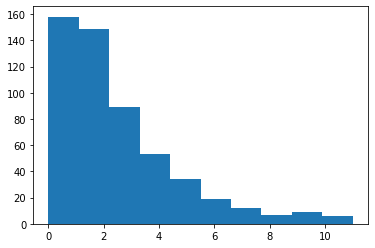


Summary Statistics
                0
count  536.000000
mean     2.757463
std      2.075433
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


RANDOM_SENT
Number of Attempts


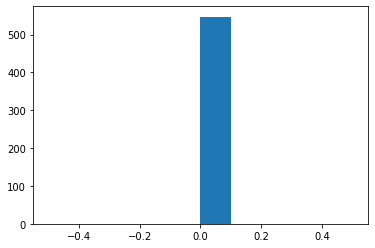


Summary Statistics
           0
count  547.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


IS_LEAF
Number of Attempts


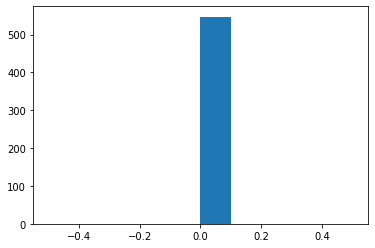


Summary Statistics
           0
count  547.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SPROUT_LEAVES
Number of Attempts


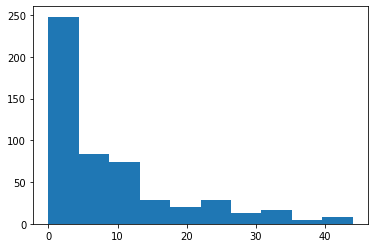


Summary Statistics
                0
count  525.000000
mean     8.925714
std      9.845379
min      0.000000
25%      2.000000
50%      5.000000
75%     12.000000
max     44.000000


DISTANCE
Number of Attempts


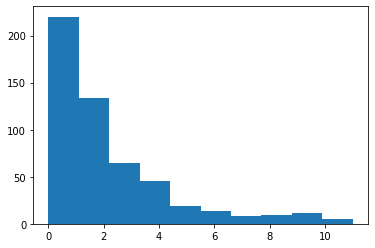


Summary Statistics
                0
count  531.000000
mean     2.455744
std      2.043725
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


CHECK_CITY_ABSTRACTION
Number of Attempts


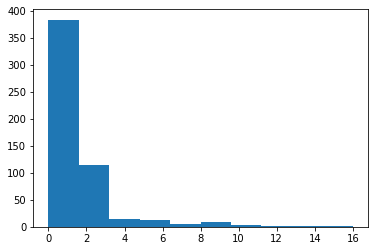


Summary Statistics
                0
count  547.000000
mean     1.745887
std      1.972187
min      0.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     16.000000


ADD_TREES
Number of Attempts


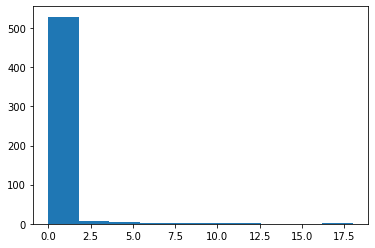


Summary Statistics
                0
count  547.000000
mean     0.204753
std      1.273186
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     18.000000


CLOSER_CIT
Number of Attempts


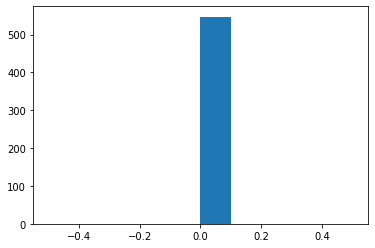


Summary Statistics
           0
count  547.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


RIFFLE
Number of Attempts


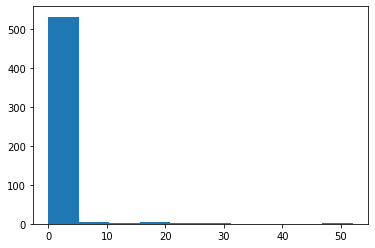


Summary Statistics
                0
count  547.000000
mean     0.645338
std      3.670792
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     52.000000


CHANGE_ABSTRACTION
Number of Attempts


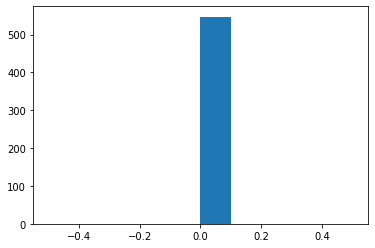


Summary Statistics
           0
count  547.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CONSTRUCT_SENT
Number of Attempts


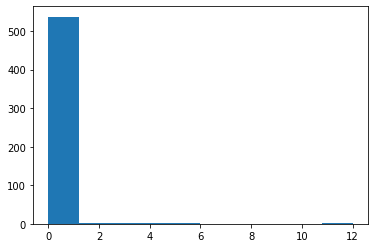


Summary Statistics
                0
count  547.000000
mean     0.089580
std      0.792144
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     12.000000


CHECK_ABSTRACTION
Number of Attempts


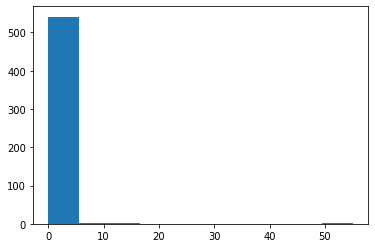


Summary Statistics
                0
count  547.000000
mean     1.283364
std      2.700251
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     55.000000


BERRY_FINDER
Number of Attempts


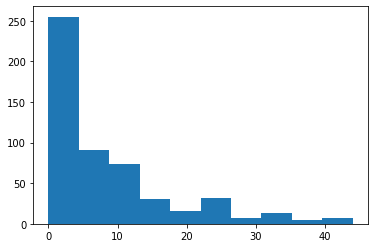


Summary Statistics
                0
count  530.000000
mean     8.441509
std      9.265735
min      0.000000
25%      2.000000
50%      5.000000
75%     12.000000
max     44.000000


COORDS
Number of Attempts


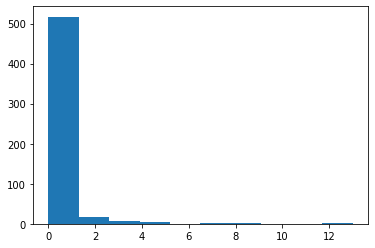


Summary Statistics
                0
count  547.000000
mean     0.234004
std      1.001873
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


COUPLE
Number of Attempts


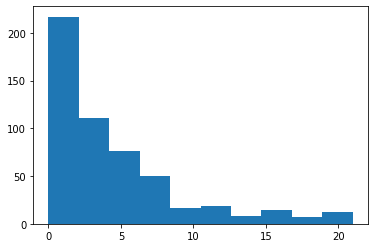


Summary Statistics
                0
count  531.000000
mean     4.745763
std      4.482393
min      0.000000
25%      2.000000
50%      3.000000
75%      6.000000
max     21.000000


BUILD_SUCCESSORS_TABLE
Number of Attempts


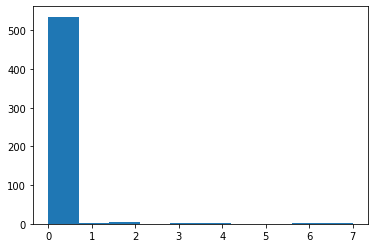


Summary Statistics
                0
count  547.000000
mean     0.063985
std      0.504123
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000

INTERMEDIATE

MAKE_CITY
Number of Attempts


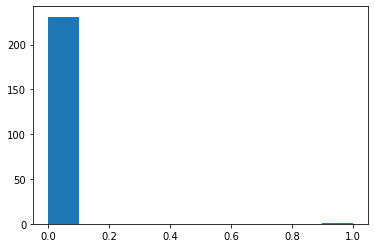


Summary Statistics
                0
count  232.000000
mean     0.004310
std      0.065653
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CLOSER_CITY
Number of Attempts


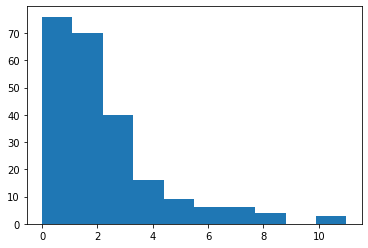


Summary Statistics
                0
count  230.000000
mean     2.517391
std      1.914585
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


RANDOM_SENT
Number of Attempts


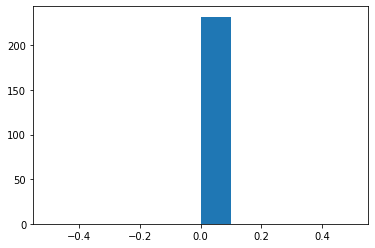


Summary Statistics
           0
count  232.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


IS_LEAF
Number of Attempts


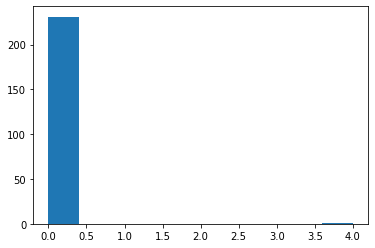


Summary Statistics
                0
count  232.000000
mean     0.017241
std      0.262613
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


SPROUT_LEAVES
Number of Attempts


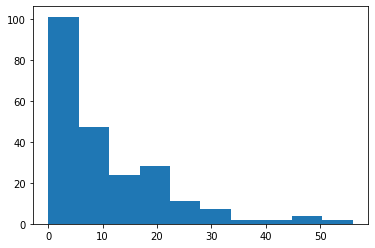


Summary Statistics
                0
count  228.000000
mean    10.570175
std     10.916559
min      0.000000
25%      2.000000
50%      7.000000
75%     16.000000
max     56.000000


DISTANCE
Number of Attempts


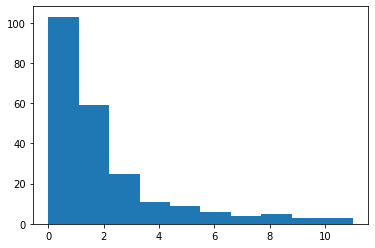


Summary Statistics
                0
count  228.000000
mean     2.381579
std      2.060540
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


CHECK_CITY_ABSTRACTION
Number of Attempts


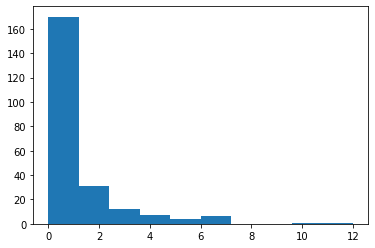


Summary Statistics
                0
count  232.000000
mean     1.577586
std      1.489652
min      0.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     12.000000


ADD_TREES
Number of Attempts


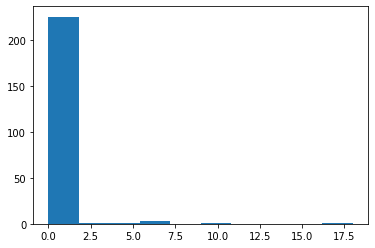


Summary Statistics
                0
count  232.000000
mean     0.258621
std      1.568746
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     18.000000


CLOSER_CIT
Number of Attempts


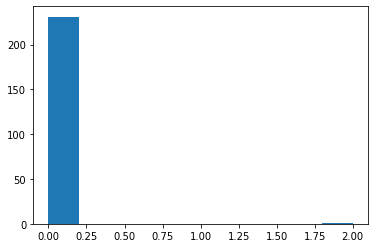


Summary Statistics
                0
count  232.000000
mean     0.008621
std      0.131306
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


RIFFLE
Number of Attempts


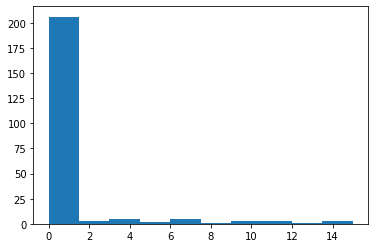


Summary Statistics
                0
count  232.000000
mean     0.823276
std      2.654535
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     15.000000


CHANGE_ABSTRACTION
Number of Attempts


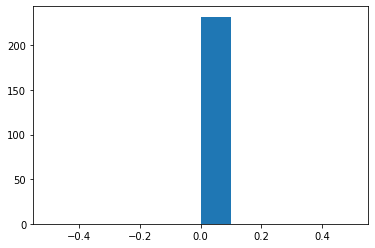


Summary Statistics
           0
count  232.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CONSTRUCT_SENT
Number of Attempts


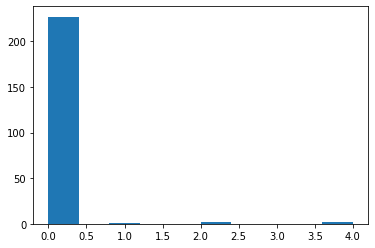


Summary Statistics
                0
count  232.000000
mean     0.056034
std      0.417535
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


CHECK_ABSTRACTION
Number of Attempts


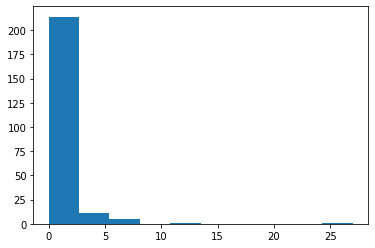


Summary Statistics
                0
count  232.000000
mean     1.314655
std      2.199990
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     27.000000


BERRY_FINDER
Number of Attempts


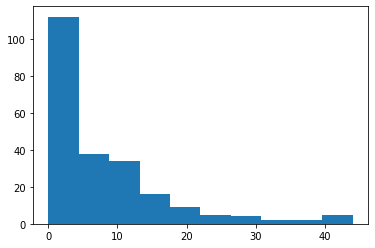


Summary Statistics
                0
count  227.000000
mean     8.017621
std      8.906081
min      0.000000
25%      2.000000
50%      5.000000
75%     11.000000
max     44.000000


COORDS
Number of Attempts


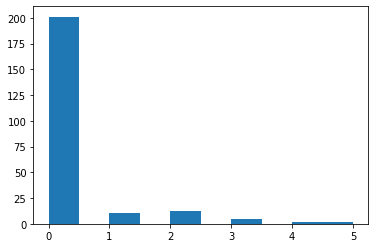


Summary Statistics
                0
count  232.000000
mean     0.288793
std      0.846820
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


COUPLE
Number of Attempts


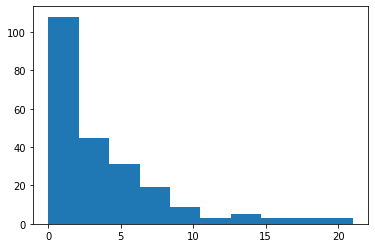


Summary Statistics
                0
count  229.000000
mean     4.213974
std      4.077385
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


BUILD_SUCCESSORS_TABLE
Number of Attempts


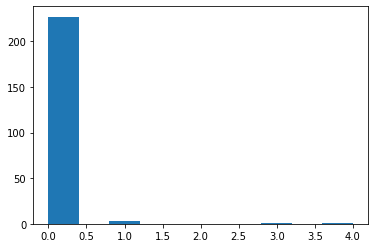


Summary Statistics
                0
count  232.000000
mean     0.043103
std      0.345465
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000

ADVANCED

MAKE_CITY
Number of Attempts


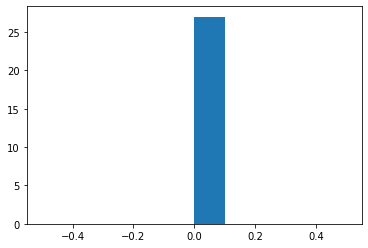


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CLOSER_CITY
Number of Attempts


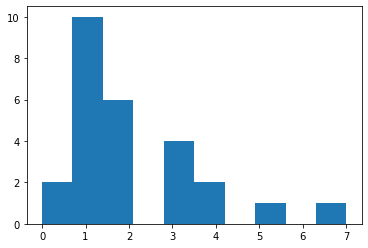


Summary Statistics
               0
count  26.000000
mean    2.076923
std     1.598076
min     0.000000
25%     1.000000
50%     2.000000
75%     3.000000
max     7.000000


RANDOM_SENT
Number of Attempts


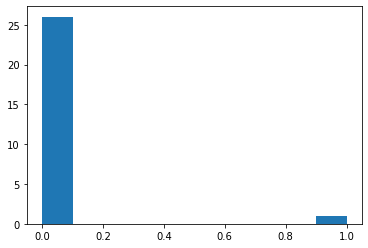


Summary Statistics
               0
count  27.000000
mean    0.037037
std     0.192450
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


IS_LEAF
Number of Attempts


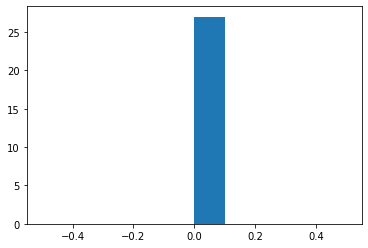


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SPROUT_LEAVES
Number of Attempts


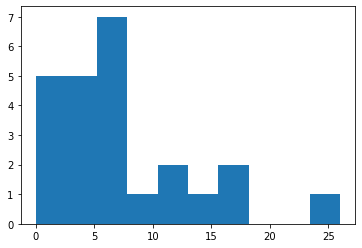


Summary Statistics
               0
count  24.000000
mean    7.208333
std     6.331283
min     0.000000
25%     3.000000
50%     6.500000
75%     8.750000
max    26.000000


DISTANCE
Number of Attempts


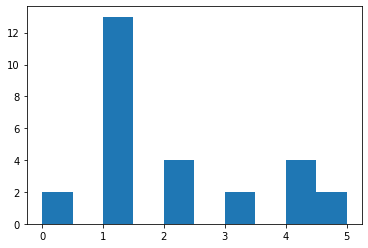


Summary Statistics
               0
count  27.000000
mean    1.962963
std     1.480163
min     0.000000
25%     1.000000
50%     1.000000
75%     3.000000
max     5.000000


CHECK_CITY_ABSTRACTION
Number of Attempts


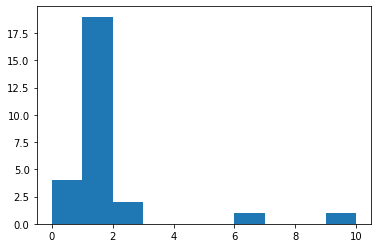


Summary Statistics
               0
count  27.000000
mean    1.444444
std     2.025479
min     0.000000
25%     1.000000
50%     1.000000
75%     1.000000
max    10.000000


ADD_TREES
Number of Attempts


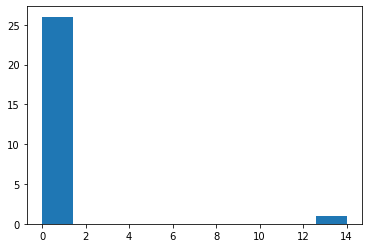


Summary Statistics
               0
count  27.000000
mean    0.518519
std     2.694301
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    14.000000


CLOSER_CIT
Number of Attempts


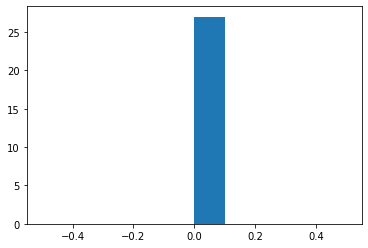


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


RIFFLE
Number of Attempts


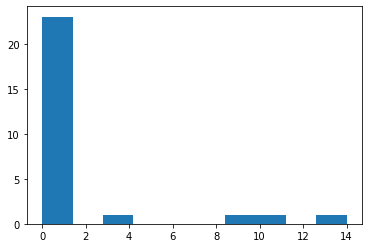


Summary Statistics
               0
count  27.000000
mean    1.407407
std     3.723721
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    14.000000


CHANGE_ABSTRACTION
Number of Attempts


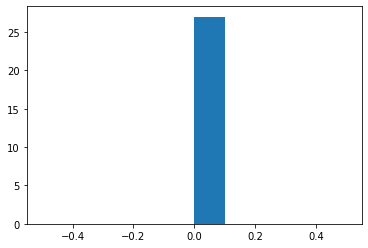


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CONSTRUCT_SENT
Number of Attempts


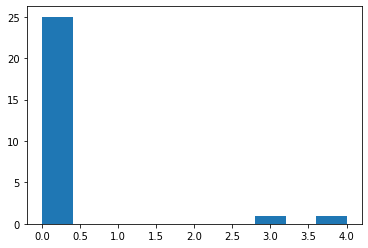


Summary Statistics
               0
count  27.000000
mean    0.259259
std     0.944319
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     4.000000


CHECK_ABSTRACTION
Number of Attempts


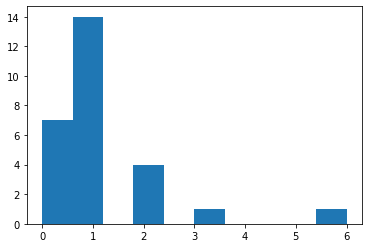


Summary Statistics
               0
count  27.000000
mean    1.148148
std     1.231125
min     0.000000
25%     0.500000
50%     1.000000
75%     1.000000
max     6.000000


BERRY_FINDER
Number of Attempts


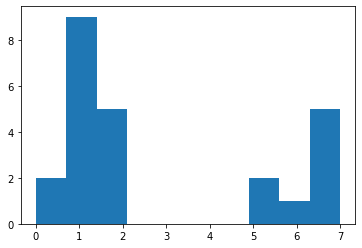


Summary Statistics
               0
count  24.000000
mean    2.916667
std     2.602953
min     0.000000
25%     1.000000
50%     2.000000
75%     5.250000
max     7.000000


COORDS
Number of Attempts


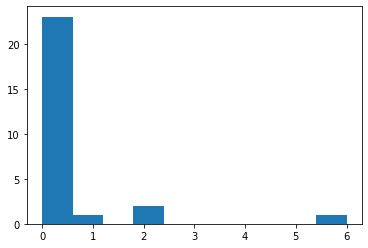


Summary Statistics
               0
count  27.000000
mean    0.407407
std     1.248361
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     6.000000


COUPLE
Number of Attempts


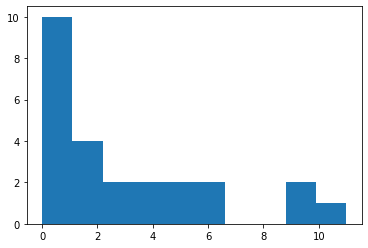


Summary Statistics
               0
count  25.000000
mean    3.280000
std     2.965356
min     0.000000
25%     1.000000
50%     2.000000
75%     5.000000
max    11.000000


BUILD_SUCCESSORS_TABLE
Number of Attempts


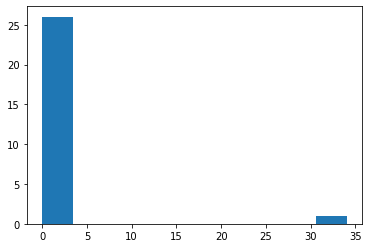


Summary Statistics
               0
count  27.000000
mean    1.333333
std     6.539819
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    34.000000



In [188]:
num_attempts_graphs_by_level('lab05.csv')

## Lab 06

Generating num attempts for lab06-sp22.csv, using ['Account', 'GenCat.adopt_a_cat', 'InstructorCard.effect', 'FreeChecking', 'Player.__init__', 'RandomCat.adopt_random_cat', 'NoisyCat', 'Cat.adopt_a_cat', 'Account.withdraw', 'Cat', 'TutorCard.effect', 'Card.__init__', 'AICard.effect', 'TACard.effect', 'Player.draw', 'FreeChecking.time_to_retire', 'FreeChecking.withdraw', 'Card.power', 'adopt_a_cat', 'Account.time_to_retire', 'repeated', 'count_occurrences', 'Player.play', 'Car']

ACCOUNT
Number of Attempts


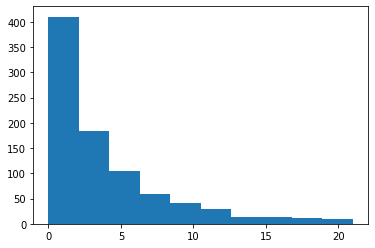


Summary Statistics
                0
count  877.000000
mean     4.142531
std      4.093818
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


GENCAT.ADOPT_A_CAT
Number of Attempts


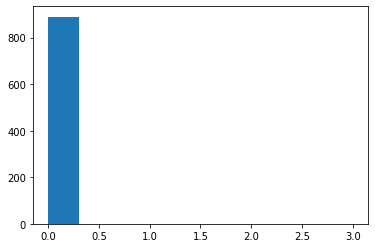


Summary Statistics
                0
count  892.000000
mean     0.005605
std      0.120660
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


INSTRUCTORCARD.EFFECT
Number of Attempts


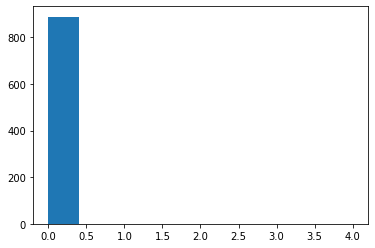


Summary Statistics
                0
count  892.000000
mean     0.007848
std      0.153321
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


FREECHECKING
Number of Attempts


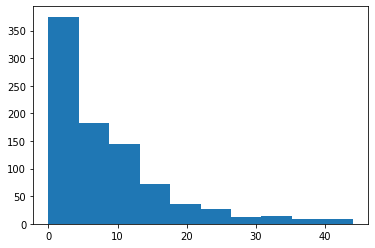


Summary Statistics
                0
count  879.000000
mean     8.340159
std      8.423533
min      0.000000
25%      2.000000
50%      6.000000
75%     12.000000
max     44.000000


PLAYER.__INIT__
Number of Attempts


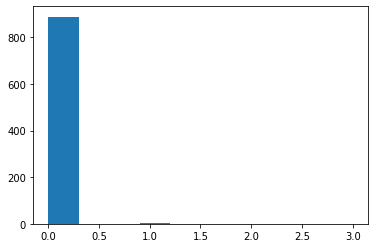


Summary Statistics
                0
count  892.000000
mean     0.006726
std      0.115856
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


RANDOMCAT.ADOPT_RANDOM_CAT
Number of Attempts


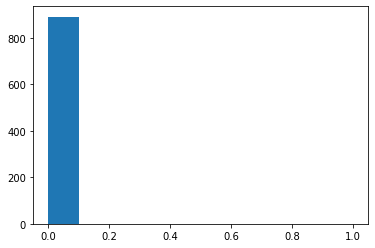


Summary Statistics
                0
count  892.000000
mean     0.001121
std      0.033482
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


NOISYCAT
Number of Attempts


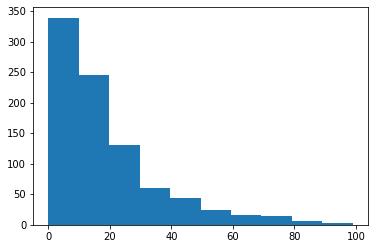


Summary Statistics
                0
count  885.000000
mean    18.770621
std     17.551425
min      0.000000
25%      6.000000
50%     13.000000
75%     25.000000
max     99.000000


CAT.ADOPT_A_CAT
Number of Attempts


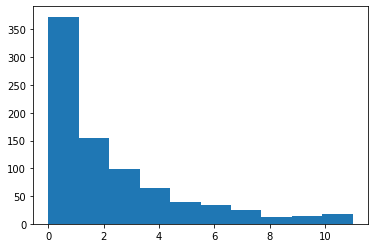


Summary Statistics
                0
count  833.000000
mean     2.605042
std      2.335722
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


ACCOUNT.WITHDRAW
Number of Attempts


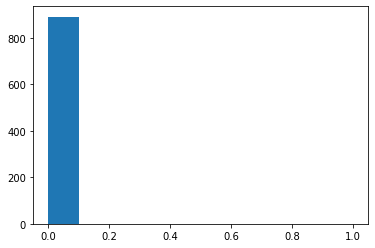


Summary Statistics
                0
count  892.000000
mean     0.001121
std      0.033482
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


CAT
Number of Attempts


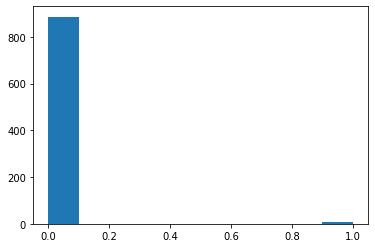


Summary Statistics
                0
count  892.000000
mean     0.006726
std      0.081785
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


TUTORCARD.EFFECT
Number of Attempts


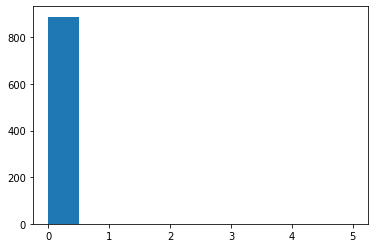


Summary Statistics
                0
count  892.000000
mean     0.010090
std      0.197939
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


CARD.__INIT__
Number of Attempts


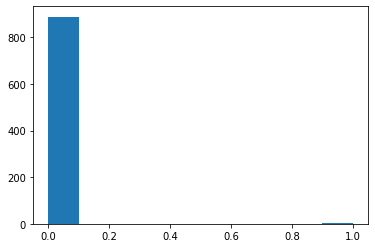


Summary Statistics
                0
count  892.000000
mean     0.004484
std      0.066852
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


AICARD.EFFECT
Number of Attempts


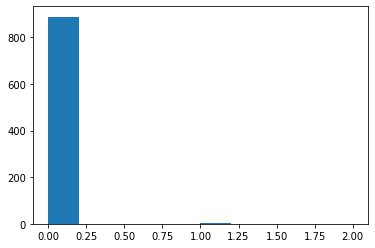


Summary Statistics
                0
count  892.000000
mean     0.005605
std      0.088458
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


TACARD.EFFECT
Number of Attempts


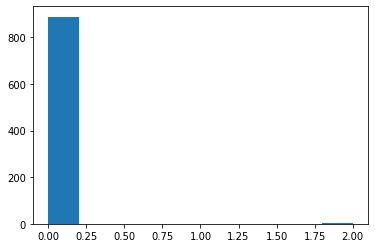


Summary Statistics
                0
count  892.000000
mean     0.005605
std      0.100347
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


PLAYER.DRAW
Number of Attempts


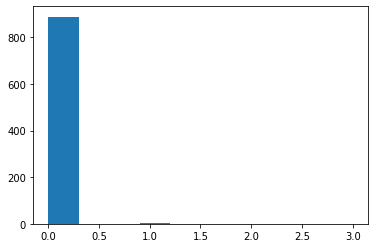


Summary Statistics
                0
count  892.000000
mean     0.007848
std      0.129512
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


FREECHECKING.TIME_TO_RETIRE
Number of Attempts


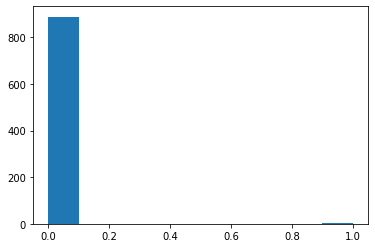


Summary Statistics
                0
count  892.000000
mean     0.004484
std      0.066852
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


FREECHECKING.WITHDRAW
Number of Attempts


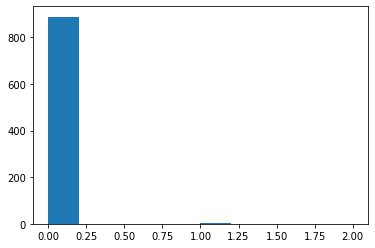


Summary Statistics
                0
count  892.000000
mean     0.004484
std      0.081938
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


CARD.POWER
Number of Attempts


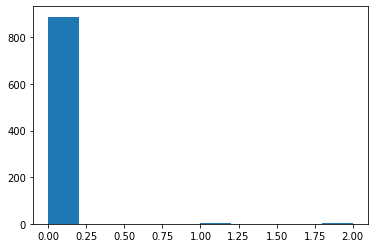


Summary Statistics
                0
count  892.000000
mean     0.006726
std      0.105726
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


ADOPT_A_CAT
Number of Attempts


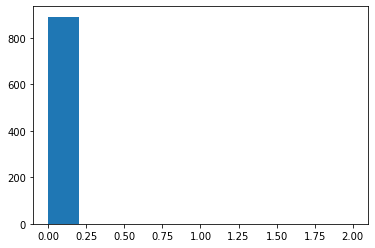


Summary Statistics
                0
count  892.000000
mean     0.002242
std      0.066965
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


ACCOUNT.TIME_TO_RETIRE
Number of Attempts


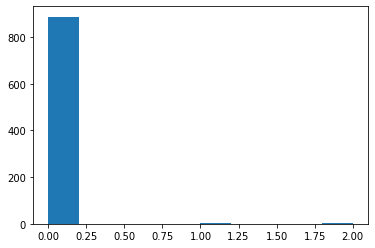


Summary Statistics
                0
count  892.000000
mean     0.007848
std      0.110833
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPEATED
Number of Attempts


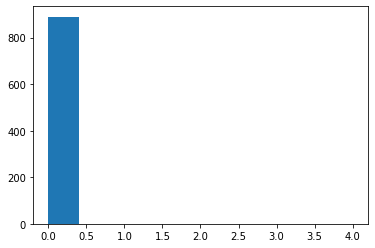


Summary Statistics
                0
count  892.000000
mean     0.005605
std      0.138015
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


COUNT_OCCURRENCES
Number of Attempts


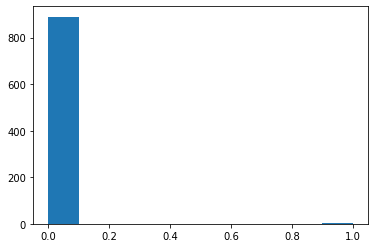


Summary Statistics
                0
count  892.000000
mean     0.002242
std      0.047325
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


PLAYER.PLAY
Number of Attempts


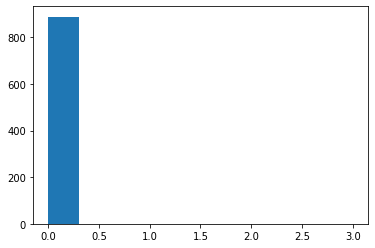


Summary Statistics
                0
count  892.000000
mean     0.006726
std      0.125169
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


CAR
Number of Attempts


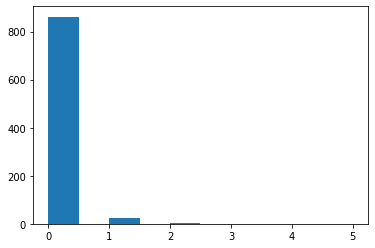


Summary Statistics
                0
count  892.000000
mean     0.042601
std      0.268807
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000



In [189]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab06-sp22.csv')


Generating num attempts for lab06-sp22.csv, stratified by level, using ['Account', 'GenCat.adopt_a_cat', 'InstructorCard.effect', 'FreeChecking', 'Player.__init__', 'RandomCat.adopt_random_cat', 'NoisyCat', 'Cat.adopt_a_cat', 'Account.withdraw', 'Cat', 'TutorCard.effect', 'Card.__init__', 'AICard.effect', 'TACard.effect', 'Player.draw', 'FreeChecking.time_to_retire', 'FreeChecking.withdraw', 'Card.power', 'adopt_a_cat', 'Account.time_to_retire', 'repeated', 'count_occurrences', 'Player.play', 'Car']
BEGINNER

ACCOUNT
Number of Attempts


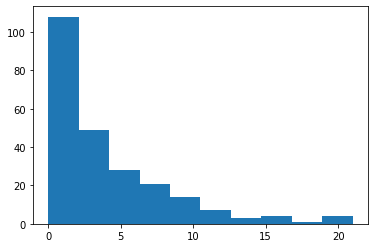


Summary Statistics
                0
count  239.000000
mean     4.259414
std      4.085183
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


GENCAT.ADOPT_A_CAT
Number of Attempts


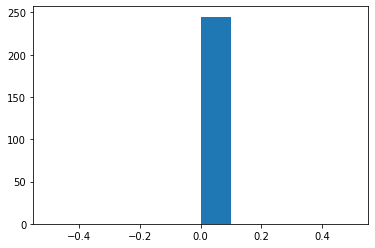


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INSTRUCTORCARD.EFFECT
Number of Attempts


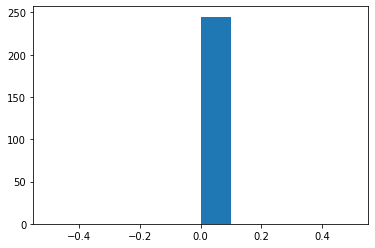


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FREECHECKING
Number of Attempts


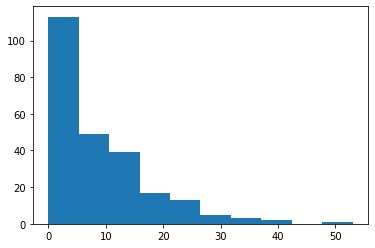


Summary Statistics
                0
count  242.000000
mean     8.809917
std      8.724758
min      0.000000
25%      2.000000
50%      6.000000
75%     12.000000
max     53.000000


PLAYER.__INIT__
Number of Attempts


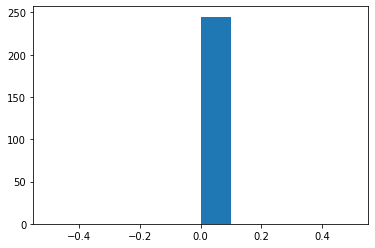


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


RANDOMCAT.ADOPT_RANDOM_CAT
Number of Attempts


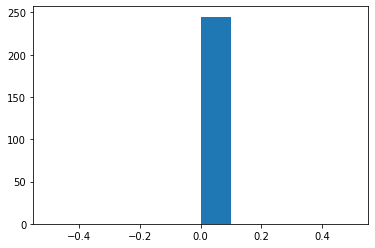


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


NOISYCAT
Number of Attempts


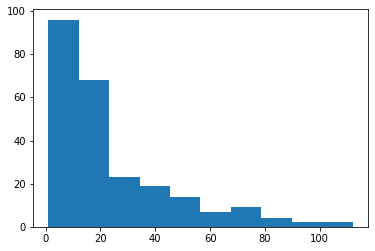


Summary Statistics
                0
count  244.000000
mean    23.942623
std     22.374772
min      1.000000
25%      8.000000
50%     17.000000
75%     32.000000
max    112.000000


CAT.ADOPT_A_CAT
Number of Attempts


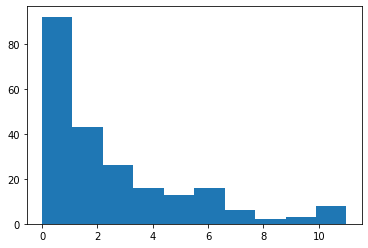


Summary Statistics
                0
count  225.000000
mean     2.835556
std      2.502602
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


ACCOUNT.WITHDRAW
Number of Attempts


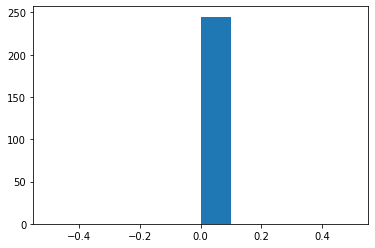


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CAT
Number of Attempts


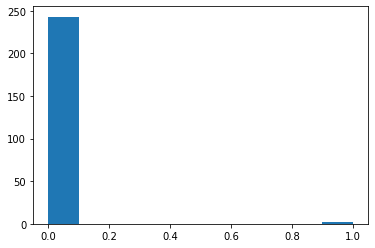


Summary Statistics
                0
count  245.000000
mean     0.008163
std      0.090165
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


TUTORCARD.EFFECT
Number of Attempts


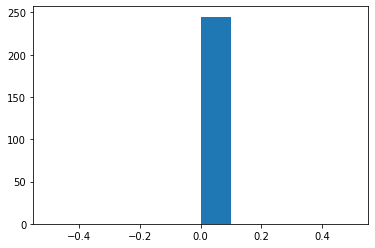


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CARD.__INIT__
Number of Attempts


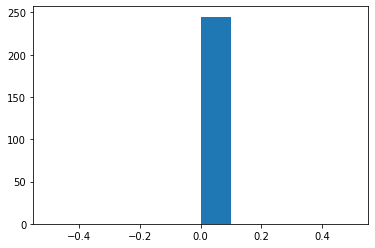


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


AICARD.EFFECT
Number of Attempts


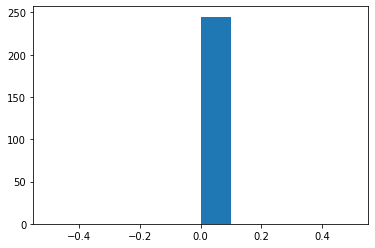


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TACARD.EFFECT
Number of Attempts


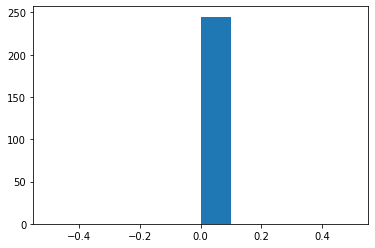


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PLAYER.DRAW
Number of Attempts


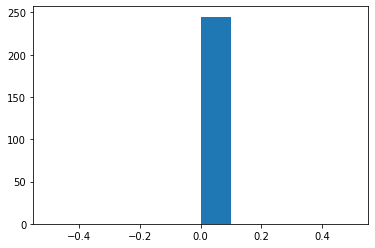


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FREECHECKING.TIME_TO_RETIRE
Number of Attempts


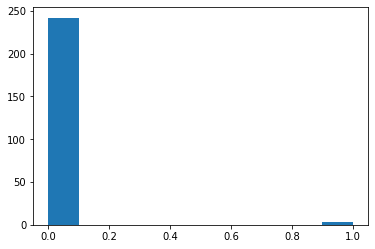


Summary Statistics
                0
count  245.000000
mean     0.012245
std      0.110202
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


FREECHECKING.WITHDRAW
Number of Attempts


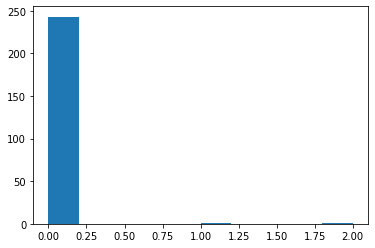


Summary Statistics
                0
count  245.000000
mean     0.012245
std      0.142623
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


CARD.POWER
Number of Attempts


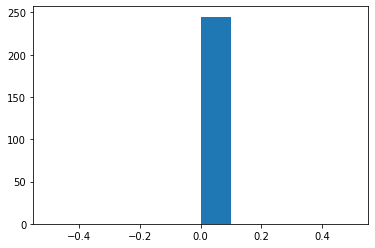


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ADOPT_A_CAT
Number of Attempts


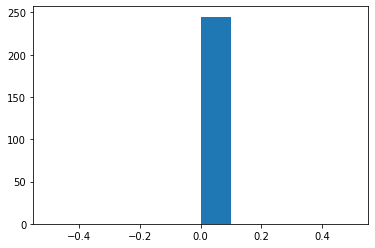


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ACCOUNT.TIME_TO_RETIRE
Number of Attempts


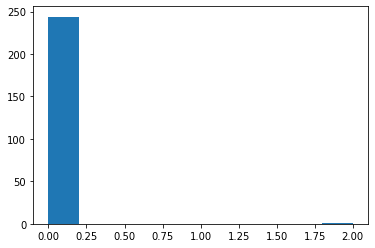


Summary Statistics
                0
count  245.000000
mean     0.008163
std      0.127775
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPEATED
Number of Attempts


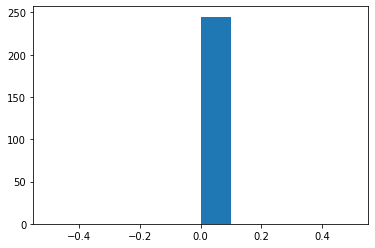


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COUNT_OCCURRENCES
Number of Attempts


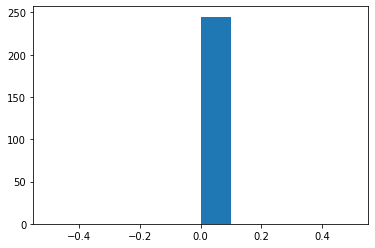


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PLAYER.PLAY
Number of Attempts


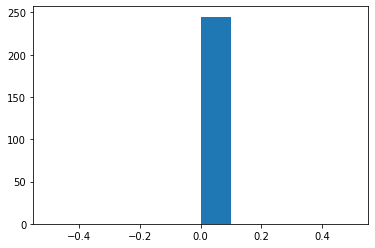


Summary Statistics
           0
count  245.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CAR
Number of Attempts


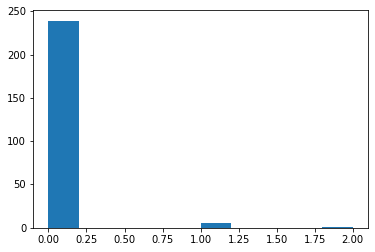


Summary Statistics
                0
count  245.000000
mean     0.028571
std      0.189909
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000

INTERMEDIATE

ACCOUNT
Number of Attempts


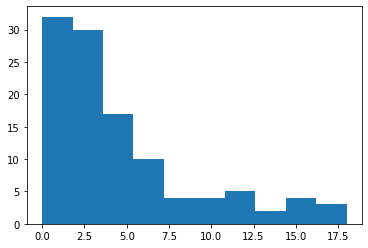


Summary Statistics
                0
count  111.000000
mean     4.675676
std      4.390407
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     18.000000


GENCAT.ADOPT_A_CAT
Number of Attempts


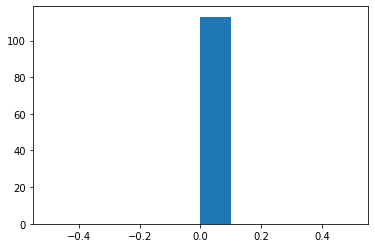


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INSTRUCTORCARD.EFFECT
Number of Attempts


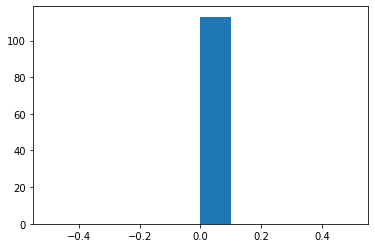


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FREECHECKING
Number of Attempts


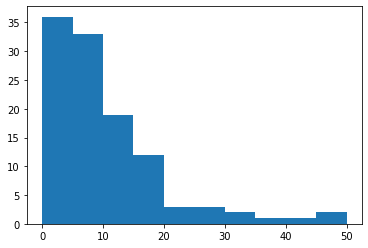


Summary Statistics
                0
count  112.000000
mean     9.776786
std      9.810557
min      0.000000
25%      3.000000
50%      7.000000
75%     13.000000
max     50.000000


PLAYER.__INIT__
Number of Attempts


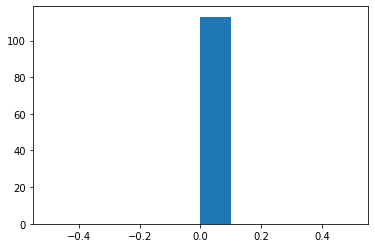


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


RANDOMCAT.ADOPT_RANDOM_CAT
Number of Attempts


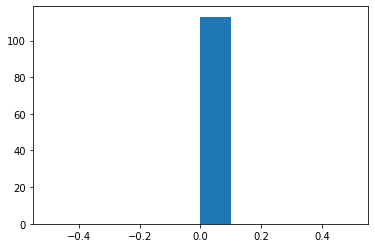


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


NOISYCAT
Number of Attempts


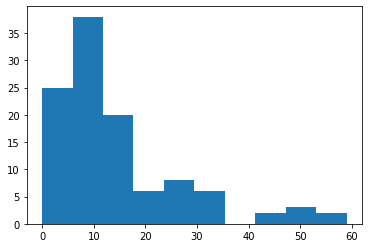


Summary Statistics
                0
count  110.000000
mean    14.190909
std     12.672657
min      0.000000
25%      6.000000
50%      9.500000
75%     16.750000
max     59.000000


CAT.ADOPT_A_CAT
Number of Attempts


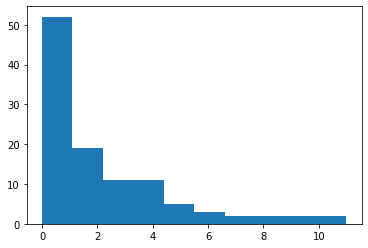


Summary Statistics
                0
count  109.000000
mean     2.550459
std      2.225634
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


ACCOUNT.WITHDRAW
Number of Attempts


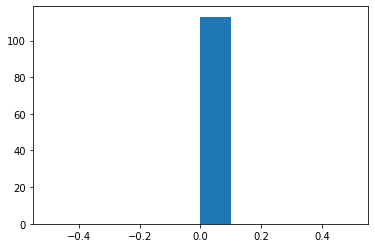


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CAT
Number of Attempts


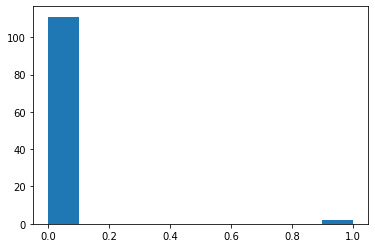


Summary Statistics
                0
count  113.000000
mean     0.017699
std      0.132443
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


TUTORCARD.EFFECT
Number of Attempts


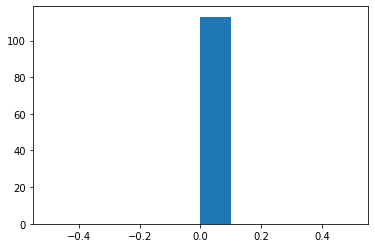


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CARD.__INIT__
Number of Attempts


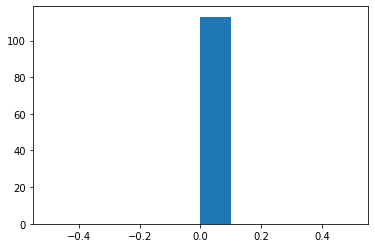


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


AICARD.EFFECT
Number of Attempts


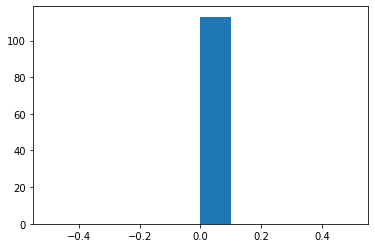


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TACARD.EFFECT
Number of Attempts


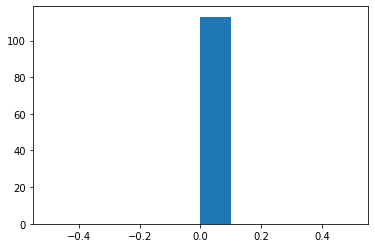


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PLAYER.DRAW
Number of Attempts


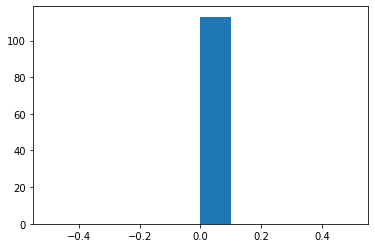


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FREECHECKING.TIME_TO_RETIRE
Number of Attempts


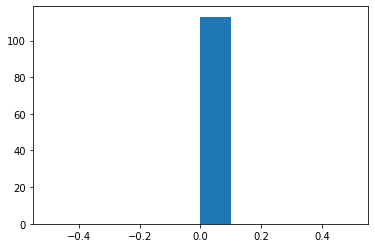


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FREECHECKING.WITHDRAW
Number of Attempts


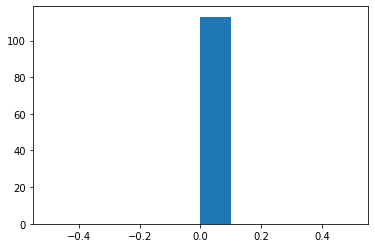


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CARD.POWER
Number of Attempts


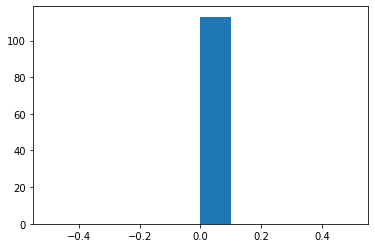


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ADOPT_A_CAT
Number of Attempts


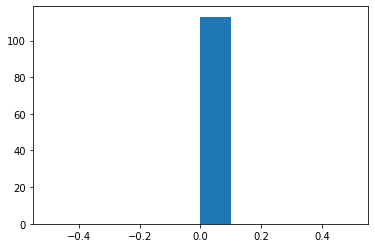


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ACCOUNT.TIME_TO_RETIRE
Number of Attempts


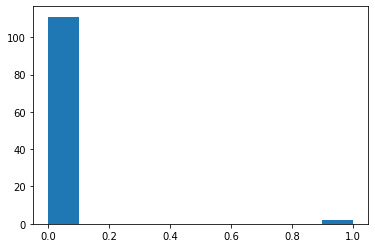


Summary Statistics
                0
count  113.000000
mean     0.017699
std      0.132443
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


REPEATED
Number of Attempts


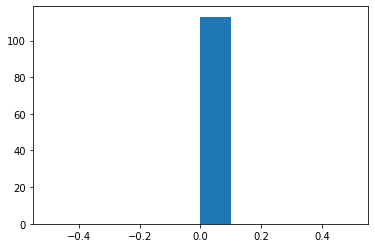


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COUNT_OCCURRENCES
Number of Attempts


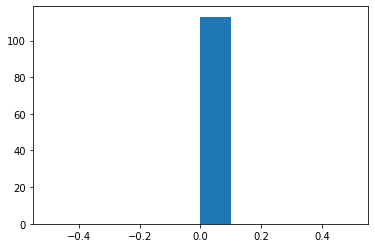


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PLAYER.PLAY
Number of Attempts


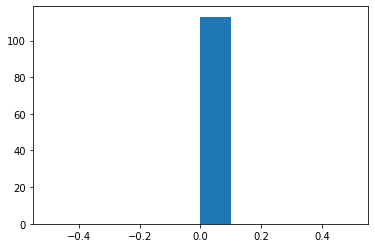


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


CAR
Number of Attempts


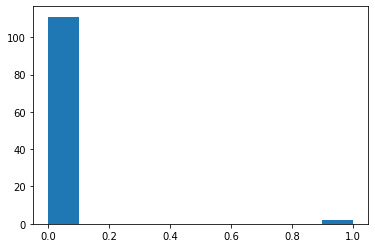


Summary Statistics
                0
count  113.000000
mean     0.017699
std      0.132443
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

ADVANCED

ACCOUNT
Number of Attempts


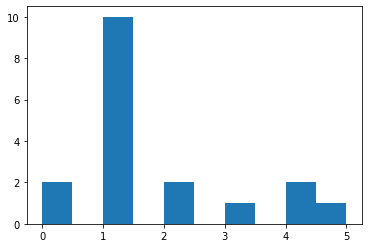


Summary Statistics
               0
count  18.000000
mean    1.666667
std     1.414214
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     5.000000


GENCAT.ADOPT_A_CAT
Number of Attempts


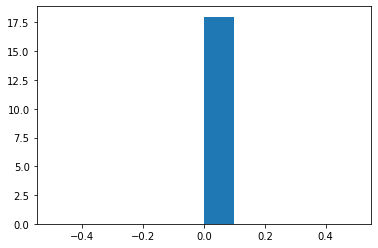


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


INSTRUCTORCARD.EFFECT
Number of Attempts


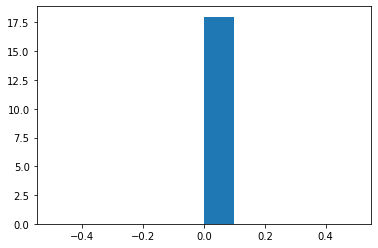


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


FREECHECKING
Number of Attempts


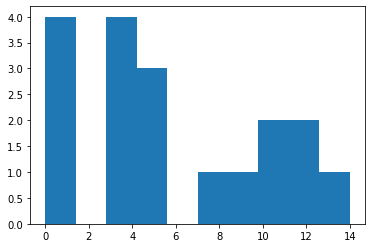


Summary Statistics
               0
count  18.000000
mean    5.944444
std     4.438763
min     0.000000
25%     3.000000
50%     5.000000
75%     9.750000
max    14.000000


PLAYER.__INIT__
Number of Attempts


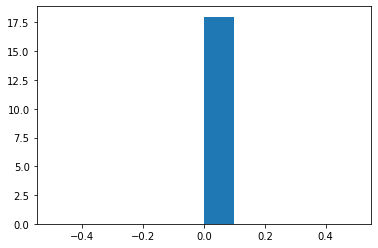


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


RANDOMCAT.ADOPT_RANDOM_CAT
Number of Attempts


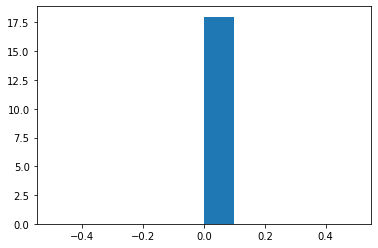


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


NOISYCAT
Number of Attempts


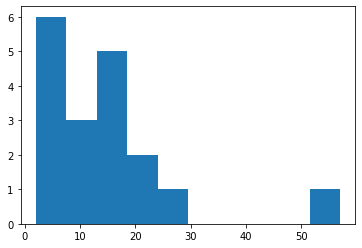


Summary Statistics
               0
count  18.000000
mean   14.277778
std    12.832888
min     2.000000
25%     6.000000
50%    12.500000
75%    18.000000
max    57.000000


CAT.ADOPT_A_CAT
Number of Attempts


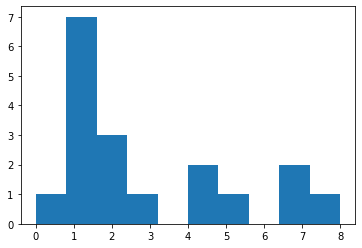


Summary Statistics
               0
count  18.000000
mean    2.833333
std     2.455486
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max     8.000000


ACCOUNT.WITHDRAW
Number of Attempts


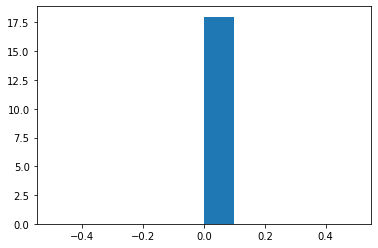


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CAT
Number of Attempts


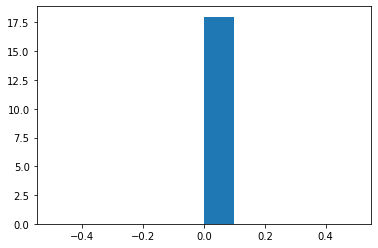


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TUTORCARD.EFFECT
Number of Attempts


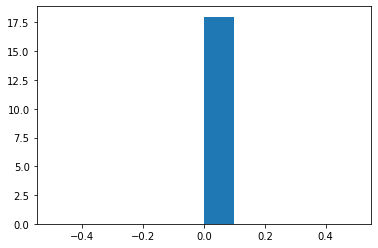


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CARD.__INIT__
Number of Attempts


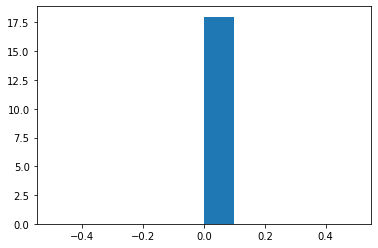


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


AICARD.EFFECT
Number of Attempts


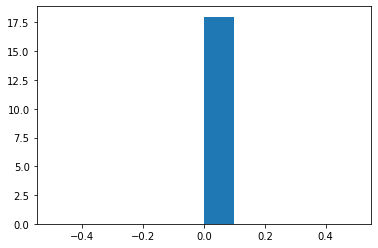


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TACARD.EFFECT
Number of Attempts


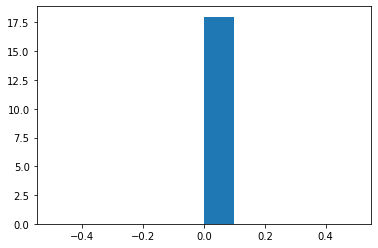


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PLAYER.DRAW
Number of Attempts


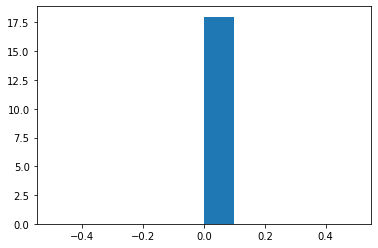


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


FREECHECKING.TIME_TO_RETIRE
Number of Attempts


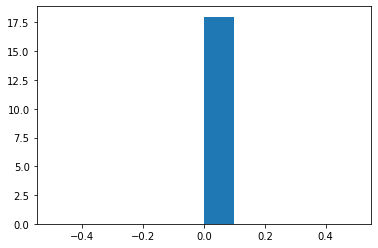


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


FREECHECKING.WITHDRAW
Number of Attempts


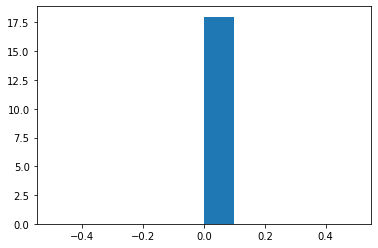


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CARD.POWER
Number of Attempts


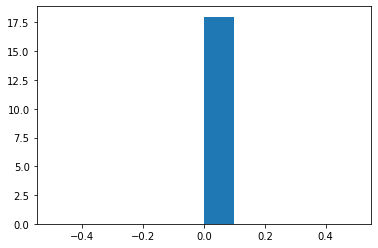


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ADOPT_A_CAT
Number of Attempts


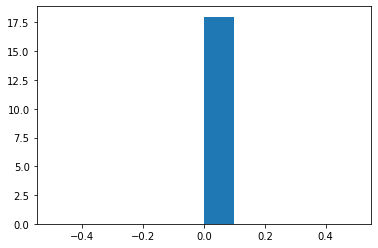


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ACCOUNT.TIME_TO_RETIRE
Number of Attempts


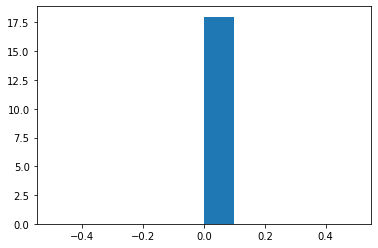


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


REPEATED
Number of Attempts


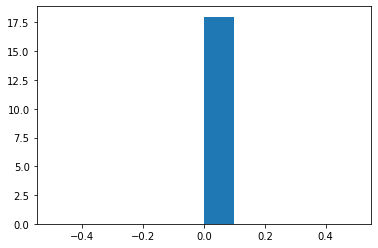


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COUNT_OCCURRENCES
Number of Attempts


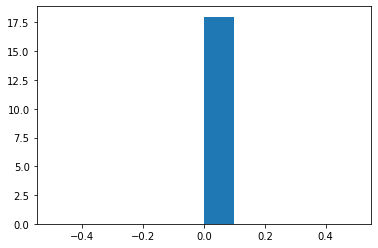


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PLAYER.PLAY
Number of Attempts


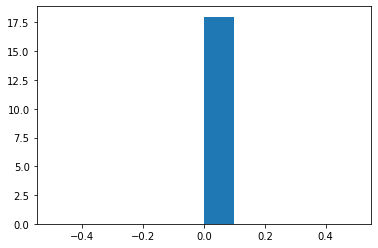


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


CAR
Number of Attempts


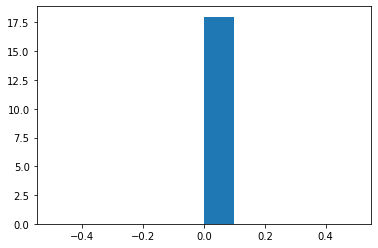


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [190]:
num_attempts_graphs_by_level('lab06-sp22.csv')

Generating num attempts for lab06.csv, using ['scale', 'List Mutation', 'hailstone', 'nonlocal_quiz', 'insert_items', 'naturals']

SCALE
Number of Attempts


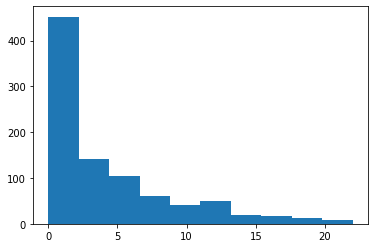


Summary Statistics
                0
count  905.000000
mean     4.439779
std      4.514599
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


LIST MUTATION
Number of Attempts


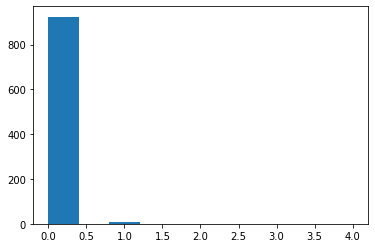


Summary Statistics
                0
count  937.000000
mean     0.020277
std      0.203113
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


HAILSTONE
Number of Attempts


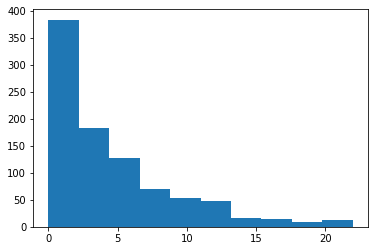


Summary Statistics
                0
count  917.000000
mean     4.673937
std      4.384309
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


NONLOCAL_QUIZ
Number of Attempts


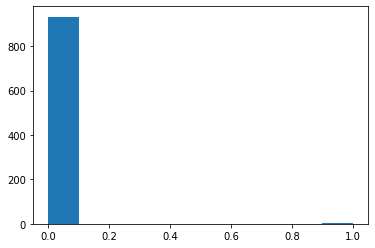


Summary Statistics
                0
count  937.000000
mean     0.004269
std      0.065232
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


INSERT_ITEMS
Number of Attempts


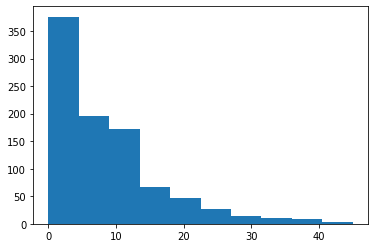


Summary Statistics
                0
count  923.000000
mean     8.447454
std      7.900012
min      0.000000
25%      3.000000
50%      6.000000
75%     12.000000
max     45.000000


NATURALS
Number of Attempts


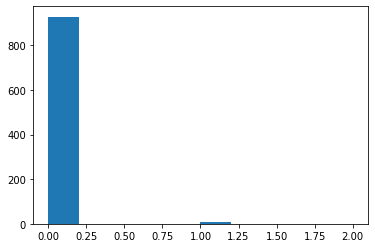


Summary Statistics
                0
count  937.000000
mean     0.009605
std      0.107980
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000



In [191]:
num_attempts_graphs('lab06.csv')


Generating num attempts for lab06.csv, stratified by level, using ['scale', 'List Mutation', 'hailstone', 'nonlocal_quiz', 'insert_items', 'naturals']
BEGINNER

SCALE
Number of Attempts


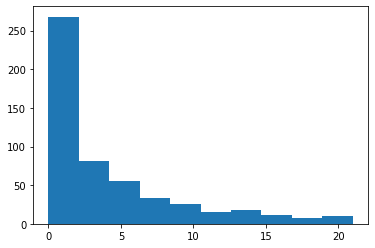


Summary Statistics
                0
count  526.000000
mean     4.480989
std      4.651945
min      0.000000
25%      1.000000
50%      2.000000
75%      6.000000
max     21.000000


LIST MUTATION
Number of Attempts


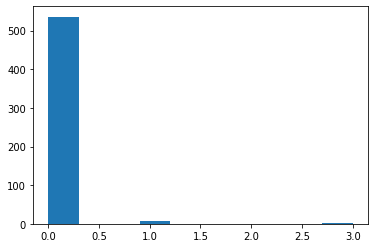


Summary Statistics
                0
count  545.000000
mean     0.020183
std      0.175619
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


HAILSTONE
Number of Attempts


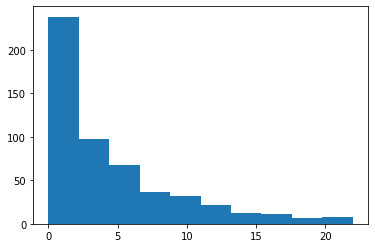


Summary Statistics
                0
count  533.000000
mean     4.707317
std      4.630388
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


NONLOCAL_QUIZ
Number of Attempts


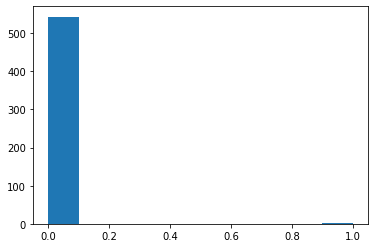


Summary Statistics
                0
count  545.000000
mean     0.003670
std      0.060523
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


INSERT_ITEMS
Number of Attempts


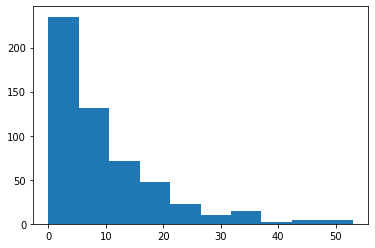


Summary Statistics
                0
count  542.000000
mean     9.621771
std      9.441077
min      0.000000
25%      3.000000
50%      7.000000
75%     13.000000
max     53.000000


NATURALS
Number of Attempts


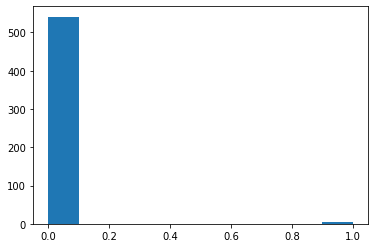


Summary Statistics
                0
count  545.000000
mean     0.007339
std      0.085434
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

INTERMEDIATE

SCALE
Number of Attempts


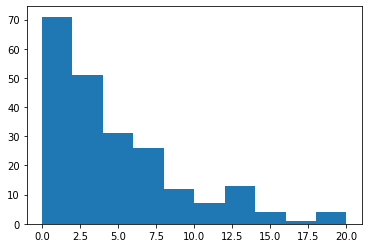


Summary Statistics
                0
count  220.000000
mean     4.427273
std      4.241476
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     20.000000


LIST MUTATION
Number of Attempts


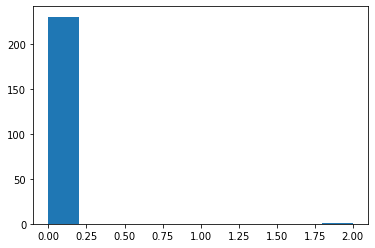


Summary Statistics
                0
count  231.000000
mean     0.008658
std      0.131590
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


HAILSTONE
Number of Attempts


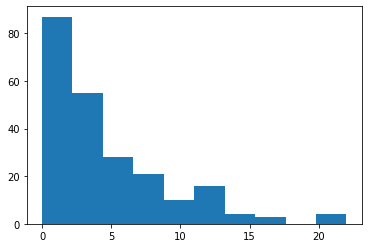


Summary Statistics
                0
count  228.000000
mean     4.750000
std      4.351692
min      0.000000
25%      2.000000
50%      3.000000
75%      7.000000
max     22.000000


NONLOCAL_QUIZ
Number of Attempts


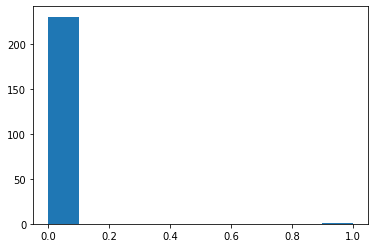


Summary Statistics
                0
count  231.000000
mean     0.004329
std      0.065795
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


INSERT_ITEMS
Number of Attempts


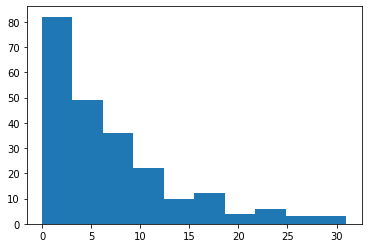


Summary Statistics
                0
count  227.000000
mean     7.207048
std      6.326398
min      0.000000
25%      2.500000
50%      5.000000
75%     10.000000
max     31.000000


NATURALS
Number of Attempts


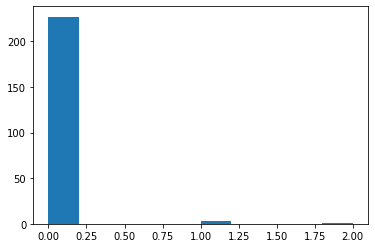


Summary Statistics
                0
count  231.000000
mean     0.021645
std      0.173102
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000

ADVANCED

SCALE
Number of Attempts


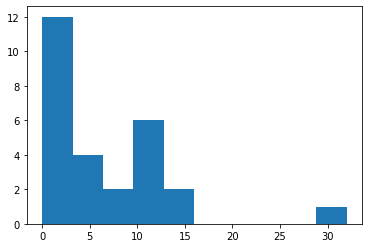


Summary Statistics
               0
count  27.000000
mean    6.740741
std     6.953652
min     0.000000
25%     1.500000
50%     4.000000
75%    10.500000
max    32.000000


LIST MUTATION
Number of Attempts


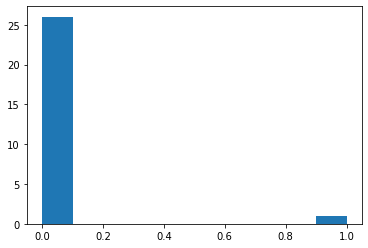


Summary Statistics
               0
count  27.000000
mean    0.037037
std     0.192450
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


HAILSTONE
Number of Attempts


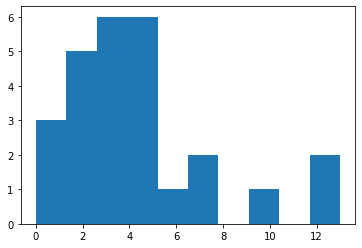


Summary Statistics
               0
count  26.000000
mean    4.384615
std     3.347559
min     0.000000
25%     2.000000
50%     3.000000
75%     5.000000
max    13.000000


NONLOCAL_QUIZ
Number of Attempts


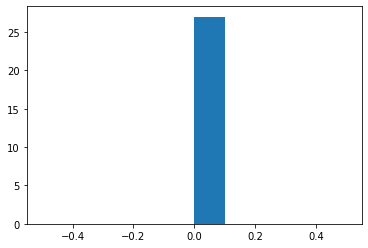


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


INSERT_ITEMS
Number of Attempts


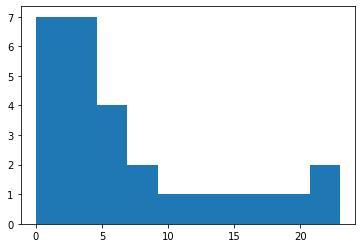


Summary Statistics
               0
count  27.000000
mean    7.185185
std     6.575228
min     0.000000
25%     2.500000
50%     4.000000
75%     9.500000
max    23.000000


NATURALS
Number of Attempts


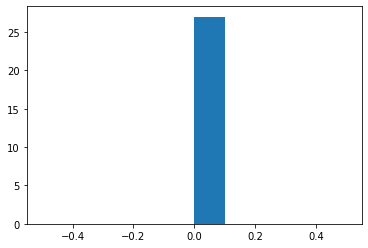


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [192]:
num_attempts_graphs_by_level('lab06.csv')

## HW 01

Generating num attempts for hw01-sp22.csv, using ['k_in_num', 'a_plus_abs_b_syntax_check', 'two_of_three', 'two_of_three_syntax_check', 'a_plus_abs_b', 'largest_factor']

K_IN_NUM
Number of Attempts


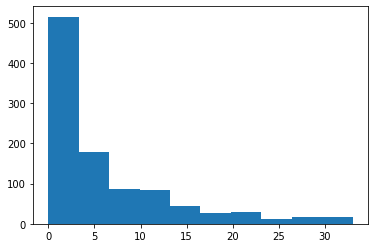


Summary Statistics
                 0
count  1009.000000
mean      6.350842
std       7.108834
min       0.000000
25%       1.000000
50%       3.000000
75%       9.000000
max      33.000000


A_PLUS_ABS_B_SYNTAX_CHECK
Number of Attempts


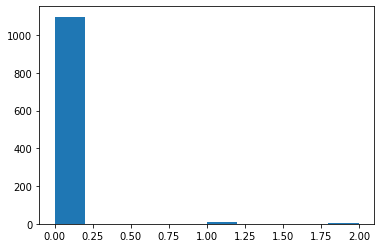


Summary Statistics
                 0
count  1109.000000
mean      0.011722
std       0.123310
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


TWO_OF_THREE
Number of Attempts


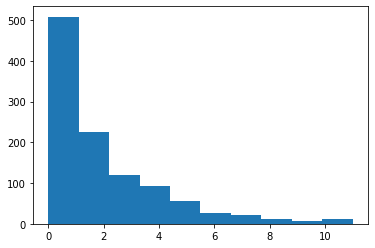


Summary Statistics
                 0
count  1082.000000
mean      2.263401
std       2.072669
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      11.000000


TWO_OF_THREE_SYNTAX_CHECK
Number of Attempts


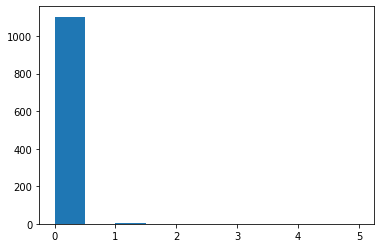


Summary Statistics
                 0
count  1109.000000
mean      0.009919
std       0.172293
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       5.000000


A_PLUS_ABS_B
Number of Attempts


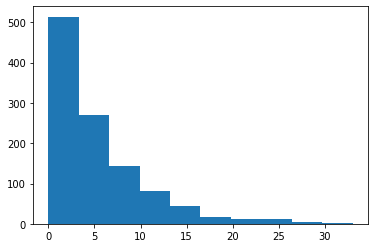


Summary Statistics
                 0
count  1103.000000
mean      5.448776
std       5.313652
min       0.000000
25%       2.000000
50%       4.000000
75%       7.000000
max      33.000000


LARGEST_FACTOR
Number of Attempts


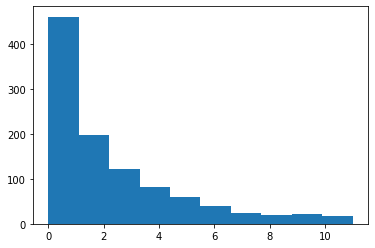


Summary Statistics
                 0
count  1043.000000
mean      2.540748
std       2.360711
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      11.000000



In [179]:
# print(assignment_dfs[name].head())
num_attempts_graphs('hw01-sp22.csv')


Generating num attempts for hw01-sp22.csv, stratified by level, using ['k_in_num', 'a_plus_abs_b_syntax_check', 'two_of_three', 'two_of_three_syntax_check', 'a_plus_abs_b', 'largest_factor']
BEGINNER

K_IN_NUM
Number of Attempts



Summary Statistics
                0
count  277.000000
mean     8.888087
std     10.149522
min      0.000000
25%      2.000000
50%      5.000000
75%     11.000000
max     52.000000


A_PLUS_ABS_B_SYNTAX_CHECK
Number of Attempts


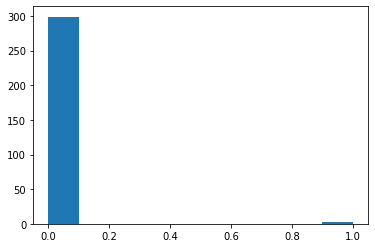


Summary Statistics
                0
count  301.000000
mean     0.006645
std      0.081378
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


TWO_OF_THREE
Number of Attempts


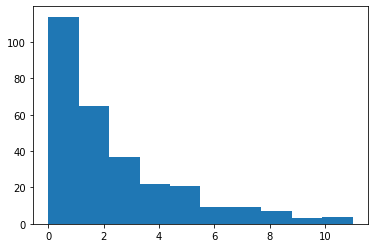


Summary Statistics
                0
count  291.000000
mean     2.621993
std      2.239473
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


TWO_OF_THREE_SYNTAX_CHECK
Number of Attempts



Summary Statistics
                0
count  301.000000
mean     0.003322
std      0.057639
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


A_PLUS_ABS_B
Number of Attempts



Summary Statistics
                0
count  298.000000
mean     5.953020
std      5.656659
min      0.000000
25%      2.000000
50%      4.500000
75%      8.000000
max     34.000000


LARGEST_FACTOR
Number of Attempts


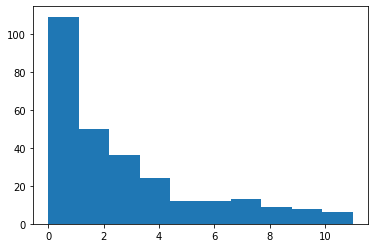


Summary Statistics
                0
count  279.000000
mean     2.928315
std      2.554842
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

INTERMEDIATE

K_IN_NUM
Number of Attempts


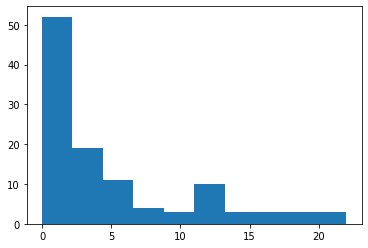


Summary Statistics
                0
count  111.000000
mean     5.315315
std      5.523474
min      0.000000
25%      2.000000
50%      3.000000
75%      7.000000
max     22.000000


A_PLUS_ABS_B_SYNTAX_CHECK
Number of Attempts


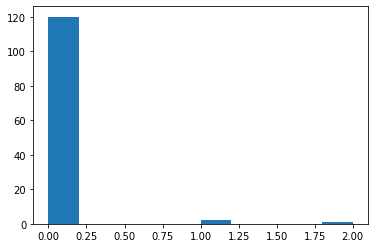


Summary Statistics
                0
count  123.000000
mean     0.032520
std      0.219349
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


TWO_OF_THREE
Number of Attempts


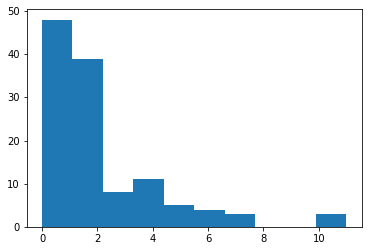


Summary Statistics
                0
count  121.000000
mean     2.388430
std      2.067091
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


TWO_OF_THREE_SYNTAX_CHECK
Number of Attempts



Summary Statistics
                0
count  123.000000
mean     0.024390
std      0.200957
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


A_PLUS_ABS_B
Number of Attempts



Summary Statistics
                0
count  123.000000
mean     6.365854
std      5.963369
min      0.000000
25%      2.000000
50%      5.000000
75%      9.000000
max     33.000000


LARGEST_FACTOR
Number of Attempts



Summary Statistics
                0
count  115.000000
mean     2.860870
std      2.452664
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

ADVANCED

K_IN_NUM
Number of Attempts



Summary Statistics
               0
count  18.000000
mean    5.555556
std     8.500673
min     1.000000
25%     1.000000
50%     1.000000
75%     5.500000
max    32.000000


A_PLUS_ABS_B_SYNTAX_CHECK
Number of Attempts


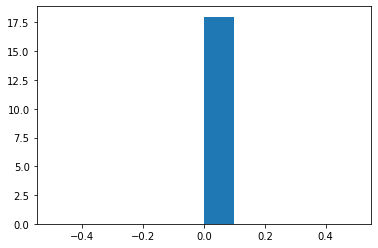


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TWO_OF_THREE
Number of Attempts



Summary Statistics
               0
count  18.000000
mean    1.944444
std     1.433721
min     0.000000
25%     1.000000
50%     1.000000
75%     2.750000
max     5.000000


TWO_OF_THREE_SYNTAX_CHECK
Number of Attempts


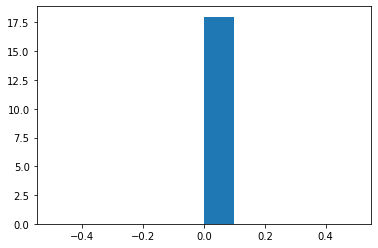


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


A_PLUS_ABS_B
Number of Attempts



Summary Statistics
               0
count  18.000000
mean    5.000000
std     3.865382
min     0.000000
25%     1.250000
50%     5.000000
75%     7.750000
max    15.000000


LARGEST_FACTOR
Number of Attempts


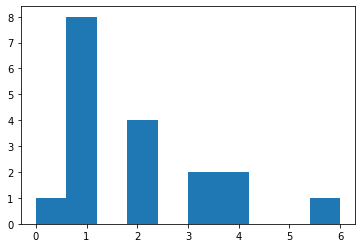


Summary Statistics
              0
count  18.00000
mean    2.00000
std     1.49509
min     0.00000
25%     1.00000
50%     1.50000
75%     2.75000
max     6.00000



In [113]:
num_attempts_graphs_by_level('hw01-sp22.csv')


Generating num attempts for hw01-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['a_plus_abs_b', 'two_of_three_syntax_check', 'k_in_num', 'a_plus_abs_b_syntax_check', 'two_of_three', 'largest_factor']

A_PLUS_ABS_B
Number of Attempts


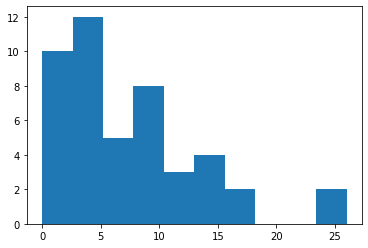


Summary Statistics
               0
count  46.000000
mean    7.391304
std     5.893417
min     0.000000
25%     3.000000
50%     6.000000
75%    10.000000
max    26.000000


TWO_OF_THREE_SYNTAX_CHECK
Number of Attempts



Summary Statistics
          0
count  46.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


K_IN_NUM
Number of Attempts


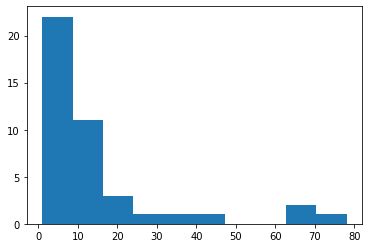


Summary Statistics
               0
count  42.000000
mean   14.047619
std    18.051353
min     1.000000
25%     3.250000
50%     8.000000
75%    15.750000
max    78.000000


A_PLUS_ABS_B_SYNTAX_CHECK
Number of Attempts



Summary Statistics
          0
count  46.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TWO_OF_THREE
Number of Attempts


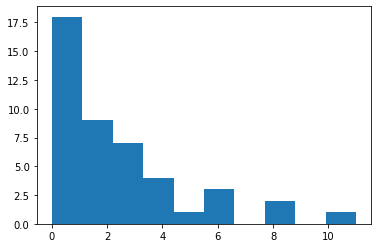


Summary Statistics
               0
count  45.000000
mean    2.622222
std     2.376867
min     0.000000
25%     1.000000
50%     2.000000
75%     3.000000
max    11.000000


LARGEST_FACTOR
Number of Attempts



Summary Statistics
               0
count  46.000000
mean    4.782609
std     4.760546
min     0.000000
25%     1.000000
50%     3.000000
75%     7.000000
max    19.000000



In [80]:
num_attempts_graphs_using_df('hw01-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

Generating num attempts for hw01.csv, using ['if_function', 'true_func', 'a_plus_abs_b', 'summation_using_accumulate', 'hailstone', 'with_if_statement', 'accumulate', 'false_func', 'product', 'with_if_function', 'two_of_three', 'cond', 'largest_factor']

IF_FUNCTION
Number of Attempts



Summary Statistics
                 0
count  1173.000000
mean      0.078431
std       0.537648
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      12.000000


TRUE_FUNC
Number of Attempts


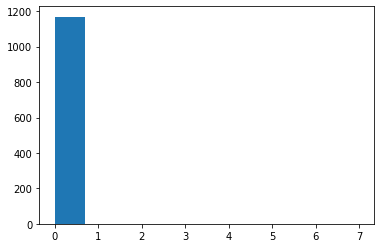


Summary Statistics
                 0
count  1173.000000
mean      0.011083
std       0.231584
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       7.000000


A_PLUS_ABS_B
Number of Attempts



Summary Statistics
                 0
count  1156.000000
mean      4.756055
std       4.167199
min       0.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      23.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
                 0
count  1173.000000
mean      0.000853
std       0.029198
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


HAILSTONE
Number of Attempts


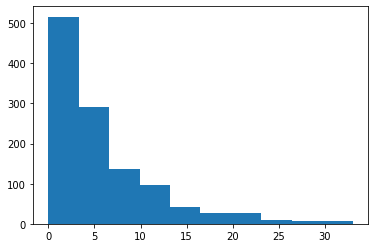


Summary Statistics
                 0
count  1159.000000
mean      5.771355
std       5.808874
min       0.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      33.000000


WITH_IF_STATEMENT
Number of Attempts



Summary Statistics
                 0
count  1097.000000
mean      2.932543
std       2.657624
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      11.000000


ACCUMULATE
Number of Attempts



Summary Statistics
                 0
count  1173.000000
mean      0.000853
std       0.029198
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


FALSE_FUNC
Number of Attempts


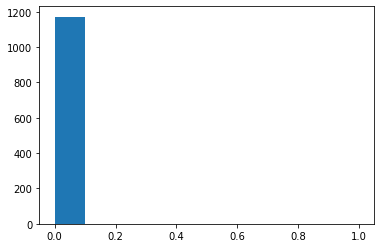


Summary Statistics
                 0
count  1173.000000
mean      0.000853
std       0.029198
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


PRODUCT
Number of Attempts



Summary Statistics
                 0
count  1173.000000
mean      0.008525
std       0.291979
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000


WITH_IF_FUNCTION
Number of Attempts


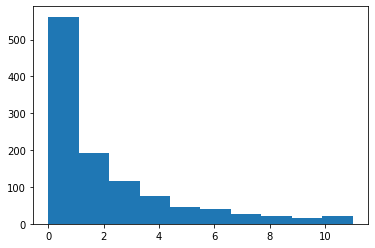


Summary Statistics
                 0
count  1117.000000
mean      2.317816
std       2.334903
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      11.000000


TWO_OF_THREE
Number of Attempts


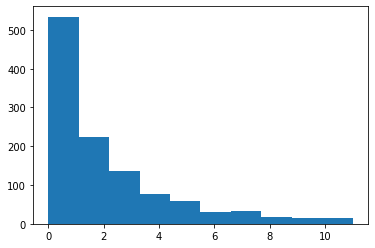


Summary Statistics
                 0
count  1140.000000
mean      2.373684
std       2.193616
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      11.000000


COND
Number of Attempts


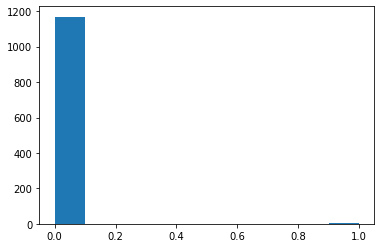


Summary Statistics
                 0
count  1173.000000
mean      0.003410
std       0.058321
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


LARGEST_FACTOR
Number of Attempts


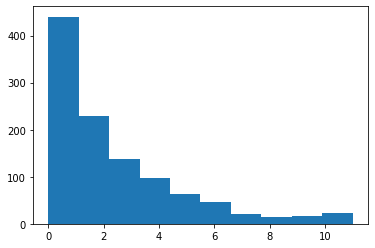


Summary Statistics
                 0
count  1089.000000
mean      2.583104
std       2.305829
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      11.000000



In [157]:
num_attempts_graphs('hw01.csv')


Generating num attempts for hw01.csv, stratified by level, using ['if_function', 'true_func', 'a_plus_abs_b', 'summation_using_accumulate', 'hailstone', 'with_if_statement', 'accumulate', 'false_func', 'product', 'with_if_function', 'two_of_three', 'cond', 'largest_factor']
BEGINNER

IF_FUNCTION
Number of Attempts


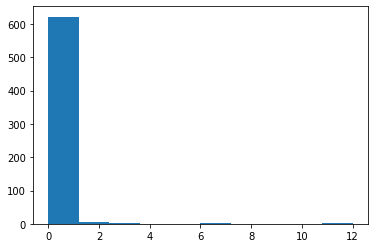


Summary Statistics
                0
count  631.000000
mean     0.088748
std      0.641217
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     12.000000


TRUE_FUNC
Number of Attempts


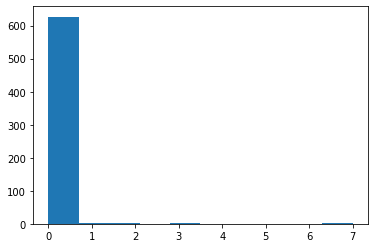


Summary Statistics
                0
count  631.000000
mean     0.020602
std      0.315555
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


A_PLUS_ABS_B
Number of Attempts


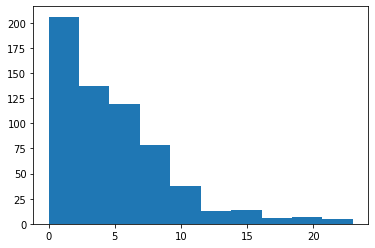


Summary Statistics
                0
count  623.000000
mean     5.036918
std      4.234704
min      0.000000
25%      2.000000
50%      4.000000
75%      7.000000
max     23.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
           0
count  631.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


HAILSTONE
Number of Attempts



Summary Statistics
                0
count  623.000000
mean     6.521669
std      6.316856
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     34.000000


WITH_IF_STATEMENT
Number of Attempts


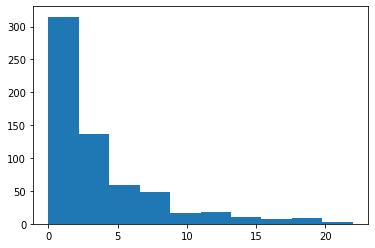


Summary Statistics
                0
count  621.000000
mean     3.777778
std      4.033196
min      0.000000
25%      1.000000
50%      2.000000
75%      5.000000
max     22.000000


ACCUMULATE
Number of Attempts


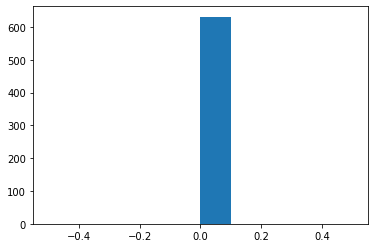


Summary Statistics
           0
count  631.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FALSE_FUNC
Number of Attempts


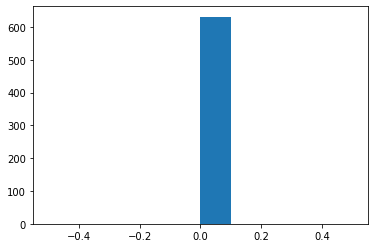


Summary Statistics
           0
count  631.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PRODUCT
Number of Attempts


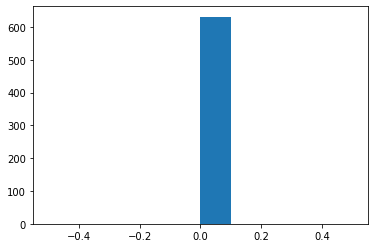


Summary Statistics
           0
count  631.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


WITH_IF_FUNCTION
Number of Attempts


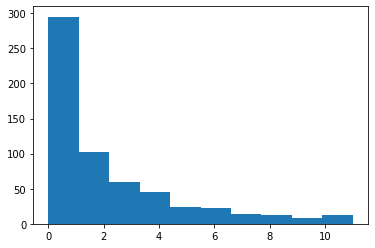


Summary Statistics
                0
count  595.000000
mean     2.401681
std      2.361660
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


TWO_OF_THREE
Number of Attempts


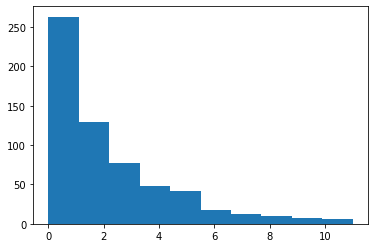


Summary Statistics
                0
count  613.000000
mean     2.466558
std      2.080317
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


COND
Number of Attempts


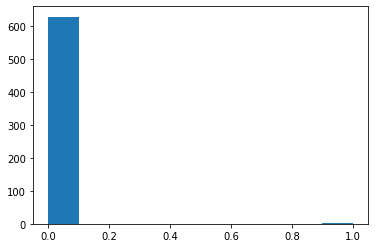


Summary Statistics
                0
count  631.000000
mean     0.003170
std      0.056254
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


LARGEST_FACTOR
Number of Attempts


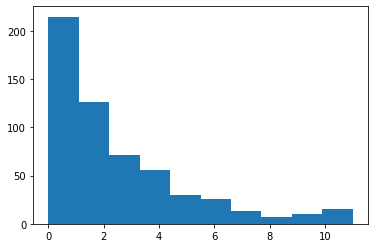


Summary Statistics
                0
count  569.000000
mean     2.718805
std      2.380603
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

INTERMEDIATE

IF_FUNCTION
Number of Attempts


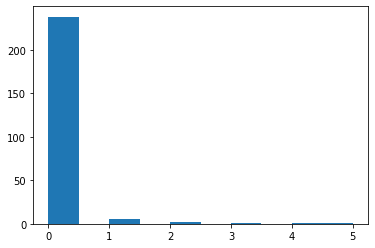


Summary Statistics
                0
count  249.000000
mean     0.088353
std      0.500227
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


TRUE_FUNC
Number of Attempts


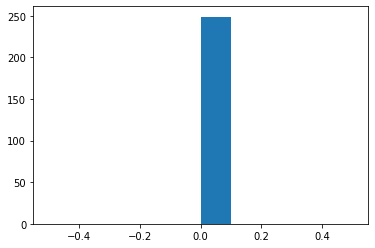


Summary Statistics
           0
count  249.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


A_PLUS_ABS_B
Number of Attempts



Summary Statistics
                0
count  247.000000
mean     5.457490
std      5.272765
min      0.000000
25%      2.000000
50%      4.000000
75%      7.500000
max     33.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


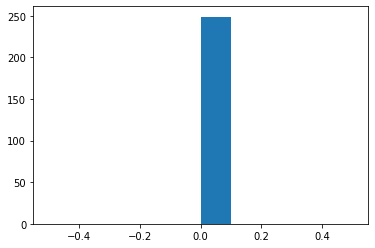


Summary Statistics
           0
count  249.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


HAILSTONE
Number of Attempts



Summary Statistics
                0
count  242.000000
mean     5.491736
std      4.588676
min      0.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     22.000000


WITH_IF_STATEMENT
Number of Attempts


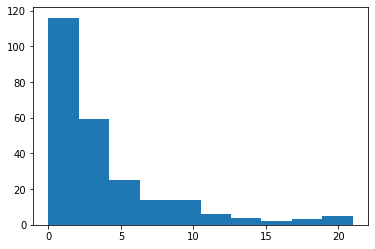


Summary Statistics
                0
count  248.000000
mean     4.145161
std      4.200816
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     21.000000


ACCUMULATE
Number of Attempts


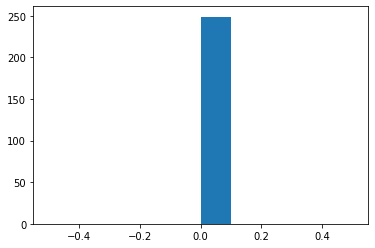


Summary Statistics
           0
count  249.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


FALSE_FUNC
Number of Attempts


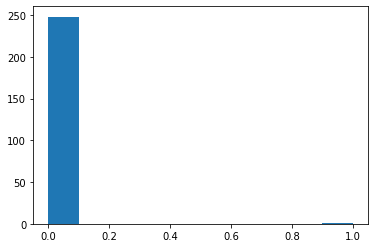


Summary Statistics
                0
count  249.000000
mean     0.004016
std      0.063372
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


PRODUCT
Number of Attempts


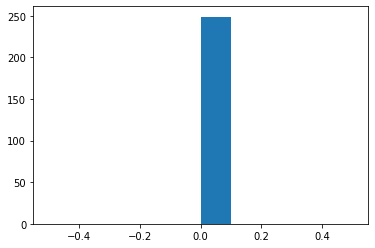


Summary Statistics
           0
count  249.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


WITH_IF_FUNCTION
Number of Attempts



Summary Statistics
                0
count  235.000000
mean     2.506383
std      2.322999
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


TWO_OF_THREE
Number of Attempts



Summary Statistics
                0
count  241.000000
mean     2.477178
std      2.375328
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


COND
Number of Attempts


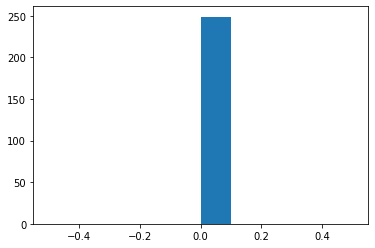


Summary Statistics
           0
count  249.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


LARGEST_FACTOR
Number of Attempts



Summary Statistics
                0
count  237.000000
mean     2.654008
std      2.187821
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000

ADVANCED

IF_FUNCTION
Number of Attempts


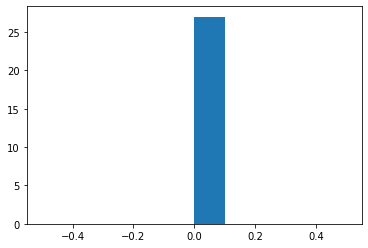


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TRUE_FUNC
Number of Attempts


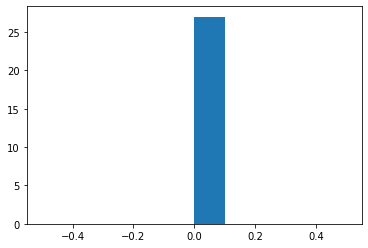


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


A_PLUS_ABS_B
Number of Attempts


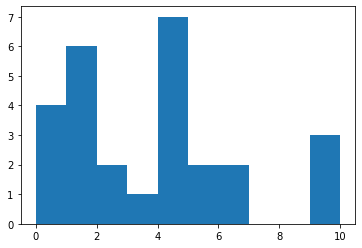


Summary Statistics
               0
count  27.000000
mean    3.407407
std     2.938593
min     0.000000
25%     1.000000
50%     4.000000
75%     4.500000
max    10.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


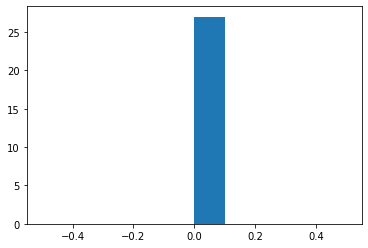


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


HAILSTONE
Number of Attempts


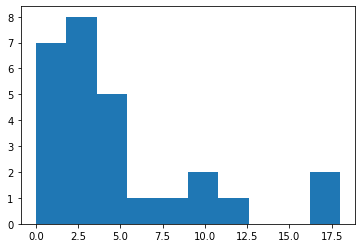


Summary Statistics
               0
count  27.000000
mean    4.740741
std     4.784531
min     0.000000
25%     1.500000
50%     3.000000
75%     5.500000
max    18.000000


WITH_IF_STATEMENT
Number of Attempts


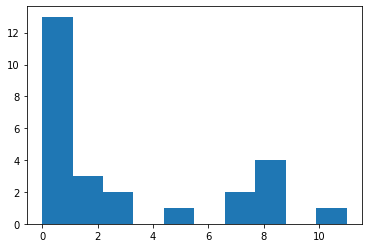


Summary Statistics
               0
count  26.000000
mean    3.230769
std     3.277898
min     0.000000
25%     1.000000
50%     1.500000
75%     6.500000
max    11.000000


ACCUMULATE
Number of Attempts


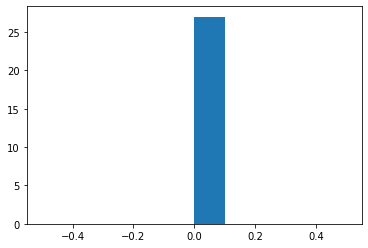


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


FALSE_FUNC
Number of Attempts


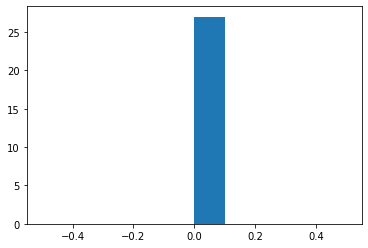


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PRODUCT
Number of Attempts


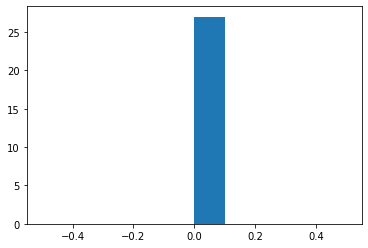


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


WITH_IF_FUNCTION
Number of Attempts


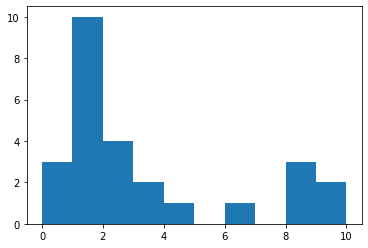


Summary Statistics
               0
count  26.000000
mean    2.961538
std     3.104587
min     0.000000
25%     1.000000
50%     1.500000
75%     3.750000
max    10.000000


TWO_OF_THREE
Number of Attempts


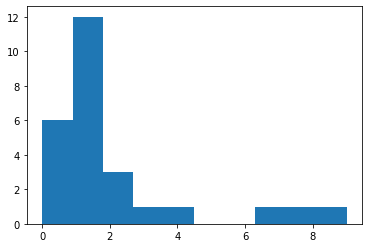


Summary Statistics
               0
count  26.000000
mean    1.884615
std     2.454823
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     9.000000


COND
Number of Attempts


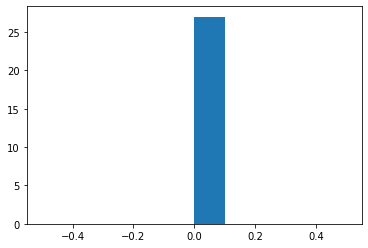


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


LARGEST_FACTOR
Number of Attempts


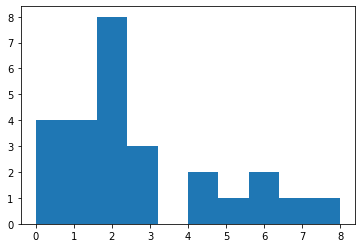


Summary Statistics
               0
count  26.000000
mean    2.653846
std     2.208027
min     0.000000
25%     1.000000
50%     2.000000
75%     3.750000
max     8.000000



In [158]:
num_attempts_graphs_by_level('hw01.csv')


Generating num attempts for hw01.csv, for people in NO_LANGUAGES_BEFORE, using ['true_func', 'hailstone', 'largest_factor', 'cond', 'if_function', 'with_if_statement', 'product', 'two_of_three', 'summation_using_accumulate', 'a_plus_abs_b', 'accumulate', 'with_if_function', 'false_func']

TRUE_FUNC
Number of Attempts


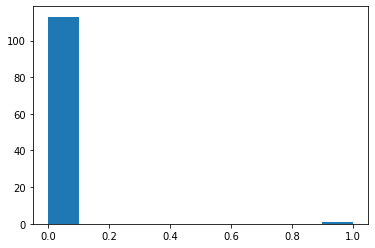


Summary Statistics
                0
count  114.000000
mean     0.008772
std      0.093659
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


HAILSTONE
Number of Attempts



Summary Statistics
                0
count  110.000000
mean     7.009091
std      6.931507
min      0.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     29.000000


LARGEST_FACTOR
Number of Attempts


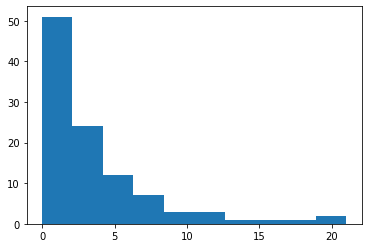


Summary Statistics
                0
count  105.000000
mean     3.857143
std      4.179687
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     21.000000


COND
Number of Attempts


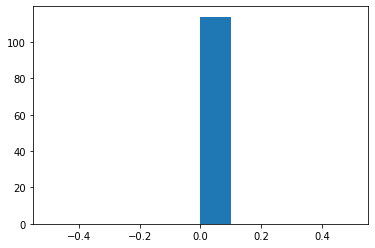


Summary Statistics
           0
count  114.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


IF_FUNCTION
Number of Attempts


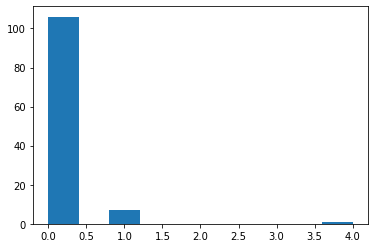


Summary Statistics
                0
count  114.000000
mean     0.096491
std      0.440621
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


WITH_IF_STATEMENT
Number of Attempts


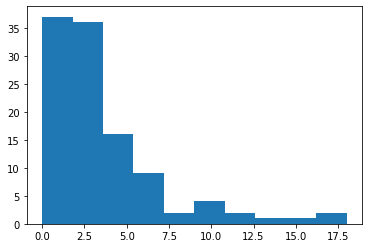


Summary Statistics
                0
count  110.000000
mean     3.363636
std      3.601038
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     18.000000


PRODUCT
Number of Attempts


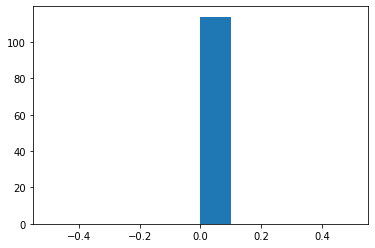


Summary Statistics
           0
count  114.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TWO_OF_THREE
Number of Attempts


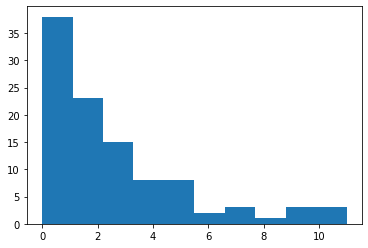


Summary Statistics
                0
count  104.000000
mean     2.798077
std      2.486389
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


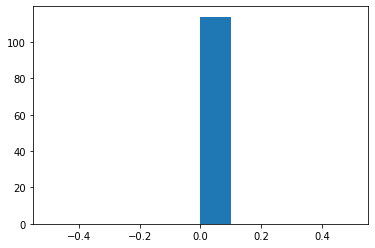


Summary Statistics
           0
count  114.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


A_PLUS_ABS_B
Number of Attempts


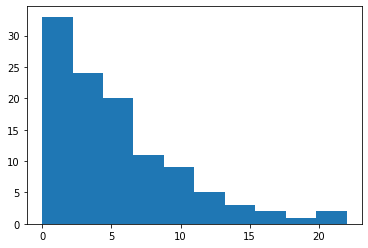


Summary Statistics
                0
count  110.000000
mean     5.481818
std      4.455142
min      0.000000
25%      2.000000
50%      4.000000
75%      7.000000
max     22.000000


ACCUMULATE
Number of Attempts


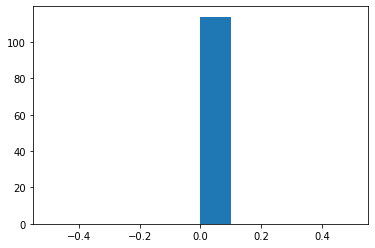


Summary Statistics
           0
count  114.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


WITH_IF_FUNCTION
Number of Attempts


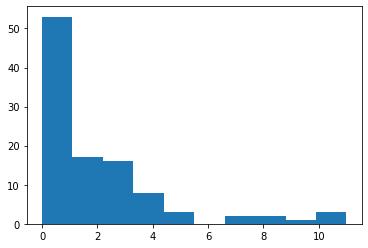


Summary Statistics
                0
count  105.000000
mean     2.190476
std      2.382207
min      0.000000
25%      1.000000
50%      1.000000
75%      3.000000
max     11.000000


FALSE_FUNC
Number of Attempts


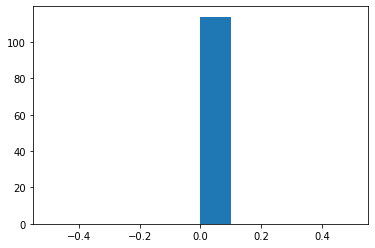


Summary Statistics
           0
count  114.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0



In [81]:
num_attempts_graphs_using_df('hw01.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 02

Generating num attempts for hw02-sp22.csv, using ['product', 'restrict_domain', 'summation_using_accumulate', 'hailstone', 'restrict_both', 'count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'restrict_range', 'again']

PRODUCT
Number of Attempts


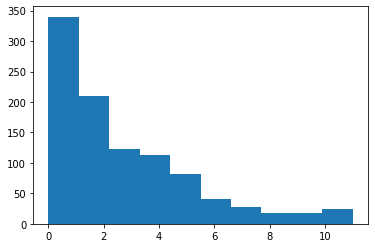


Summary Statistics
                0
count  995.000000
mean     2.939698
std      2.364301
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


RESTRICT_DOMAIN
Number of Attempts


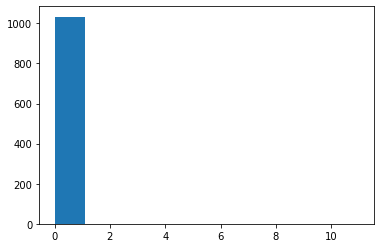


Summary Statistics
                 0
count  1034.000000
mean      0.010638
std       0.342084
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      11.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
                 0
count  1024.000000
mean      3.736328
std       3.690998
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max      22.000000


HAILSTONE
Number of Attempts


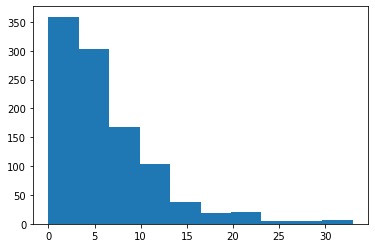


Summary Statistics
                 0
count  1025.000000
mean      6.157073
std       5.332656
min       0.000000
25%       2.000000
50%       5.000000
75%       8.000000
max      33.000000


RESTRICT_BOTH
Number of Attempts


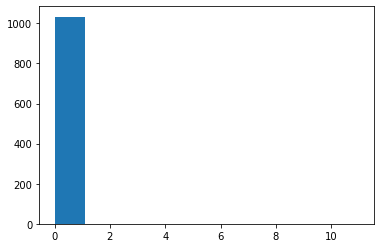


Summary Statistics
                 0
count  1034.000000
mean      0.010638
std       0.342084
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      11.000000


COUNT_UNTIL_LARGER
Number of Attempts



Summary Statistics
                0
count  985.000000
mean     6.074112
std      6.475846
min      0.000000
25%      2.000000
50%      3.000000
75%      8.000000
max     33.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


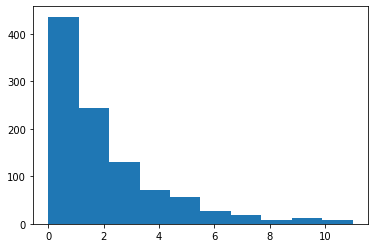


Summary Statistics
                 0
count  1012.000000
mean      2.294466
std       2.013861
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      11.000000


FILTER_SEQUENCE
Number of Attempts


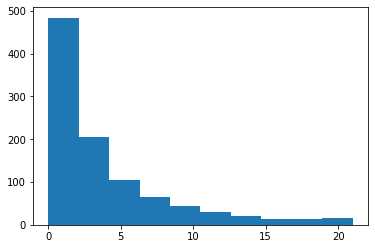


Summary Statistics
                 0
count  1001.000000
mean      4.237762
std       4.300629
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      21.000000


ACCUMULATE
Number of Attempts


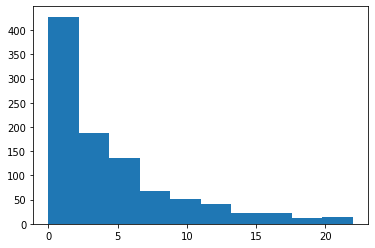


Summary Statistics
                0
count  985.000000
mean     4.703553
std      4.701176
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


RESTRICT_RANGE
Number of Attempts


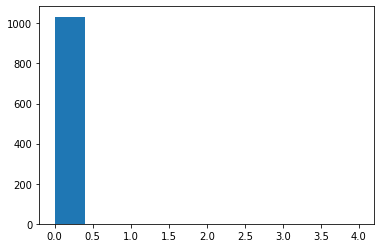


Summary Statistics
                 0
count  1034.000000
mean      0.003868
std       0.124394
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       4.000000


AGAIN
Number of Attempts


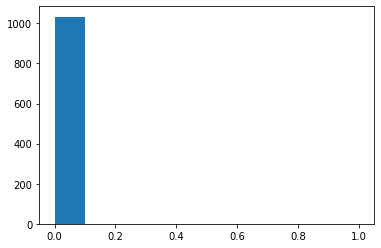


Summary Statistics
                 0
count  1034.000000
mean      0.000967
std       0.031099
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000



In [159]:
num_attempts_graphs('hw02-sp22.csv')


Generating num attempts for hw02-sp22.csv, stratified by level, using ['product', 'restrict_domain', 'summation_using_accumulate', 'hailstone', 'restrict_both', 'count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'restrict_range', 'again']
BEGINNER

PRODUCT
Number of Attempts


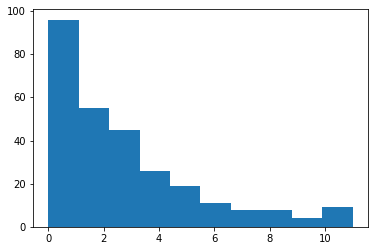


Summary Statistics
                0
count  281.000000
mean     3.003559
std      2.458946
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


RESTRICT_DOMAIN
Number of Attempts


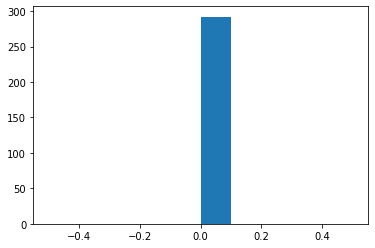


Summary Statistics
           0
count  292.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SUMMATION_USING_ACCUMULATE
Number of Attempts


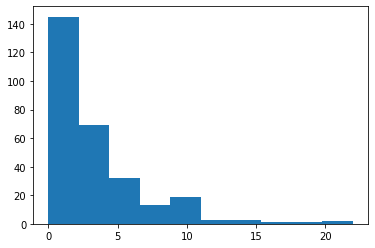


Summary Statistics
                0
count  288.000000
mean     3.531250
std      3.479016
min      0.000000
25%      1.000000
50%      2.000000
75%      5.000000
max     22.000000


HAILSTONE
Number of Attempts



Summary Statistics
                0
count  289.000000
mean     6.435986
std      5.698156
min      0.000000
25%      2.000000
50%      5.000000
75%      9.000000
max     31.000000


RESTRICT_BOTH
Number of Attempts


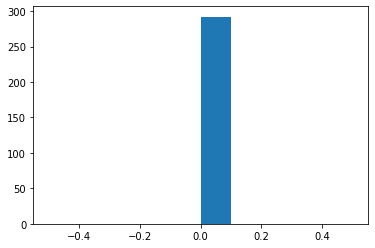


Summary Statistics
           0
count  292.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COUNT_UNTIL_LARGER
Number of Attempts


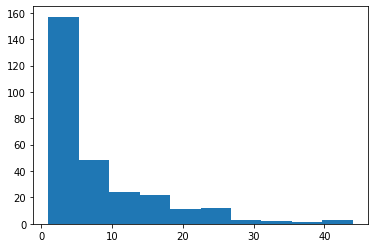


Summary Statistics
                0
count  283.000000
mean     7.706714
std      8.156418
min      1.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     44.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


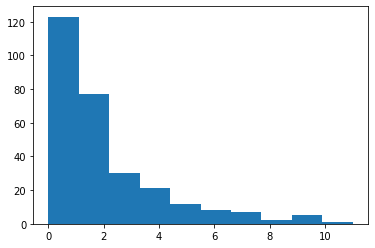


Summary Statistics
                0
count  286.000000
mean     2.255245
std      1.993293
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


FILTER_SEQUENCE
Number of Attempts


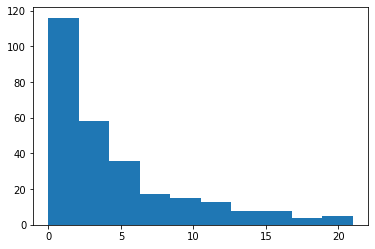


Summary Statistics
                0
count  280.000000
mean     4.878571
std      4.657391
min      0.000000
25%      1.000000
50%      3.000000
75%      6.250000
max     21.000000


ACCUMULATE
Number of Attempts


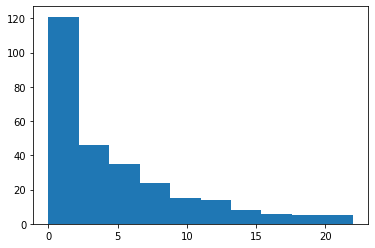


Summary Statistics
                0
count  279.000000
mean     4.956989
std      5.010594
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


RESTRICT_RANGE
Number of Attempts


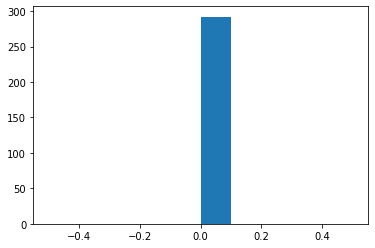


Summary Statistics
           0
count  292.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


AGAIN
Number of Attempts


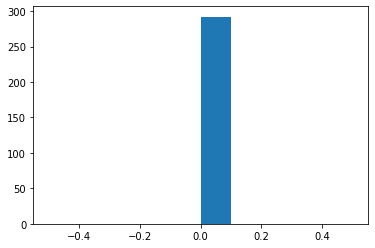


Summary Statistics
           0
count  292.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

INTERMEDIATE

PRODUCT
Number of Attempts


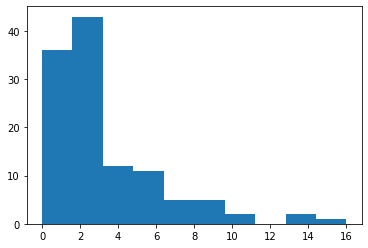


Summary Statistics
                0
count  117.000000
mean     3.316239
std      2.926247
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     16.000000


RESTRICT_DOMAIN
Number of Attempts


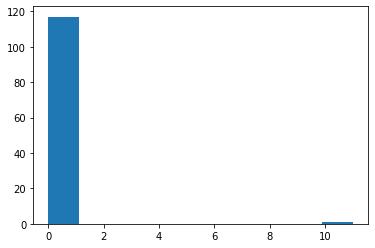


Summary Statistics
                0
count  118.000000
mean     0.093220
std      1.012632
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
                0
count  118.000000
mean     4.118644
std      3.479290
min      0.000000
25%      2.000000
50%      3.000000
75%      5.750000
max     18.000000


HAILSTONE
Number of Attempts


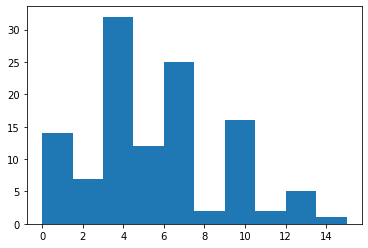


Summary Statistics
                0
count  116.000000
mean     5.500000
std      3.263767
min      0.000000
25%      3.000000
50%      5.000000
75%      7.000000
max     15.000000


RESTRICT_BOTH
Number of Attempts


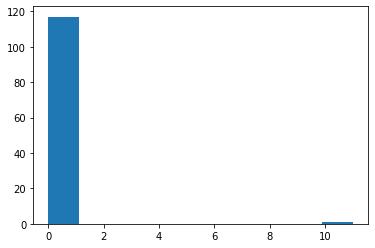


Summary Statistics
                0
count  118.000000
mean     0.093220
std      1.012632
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


COUNT_UNTIL_LARGER
Number of Attempts


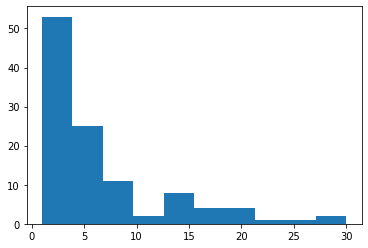


Summary Statistics
                0
count  111.000000
mean     6.270270
std      6.550428
min      1.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     30.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


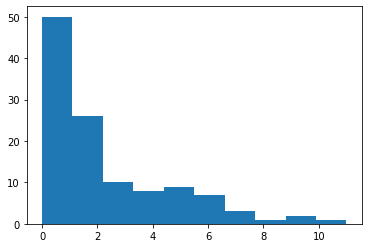


Summary Statistics
                0
count  117.000000
mean     2.572650
std      2.198417
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


FILTER_SEQUENCE
Number of Attempts


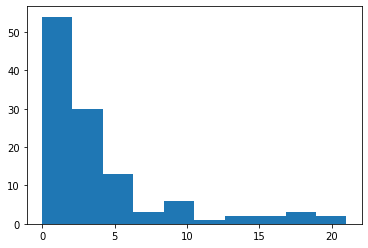


Summary Statistics
                0
count  116.000000
mean     4.275862
std      4.404713
min      0.000000
25%      1.750000
50%      3.000000
75%      5.000000
max     21.000000


ACCUMULATE
Number of Attempts


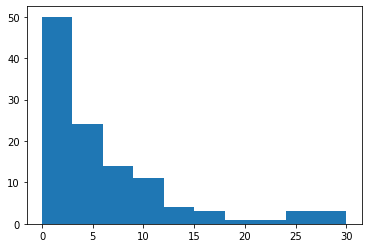


Summary Statistics
                0
count  114.000000
mean     5.964912
std      6.637157
min      0.000000
25%      2.000000
50%      3.000000
75%      8.000000
max     30.000000


RESTRICT_RANGE
Number of Attempts


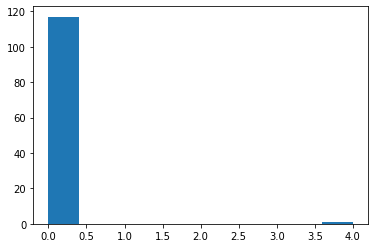


Summary Statistics
                0
count  118.000000
mean     0.033898
std      0.368230
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


AGAIN
Number of Attempts



Summary Statistics
                0
count  118.000000
mean     0.008475
std      0.092057
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

ADVANCED

PRODUCT
Number of Attempts


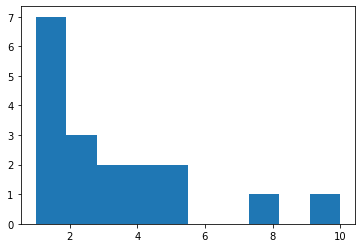


Summary Statistics
               0
count  18.000000
mean    3.055556
std     2.600277
min     1.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    10.000000


RESTRICT_DOMAIN
Number of Attempts


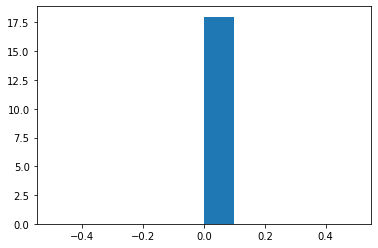


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
               0
count  16.000000
mean    2.500000
std     1.788854
min     0.000000
25%     1.750000
50%     2.000000
75%     3.000000
max     7.000000


HAILSTONE
Number of Attempts


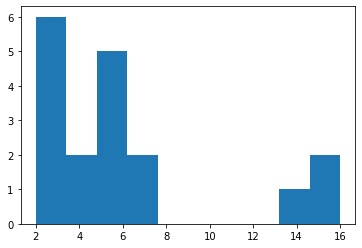


Summary Statistics
               0
count  18.000000
mean    6.222222
std     4.531661
min     2.000000
25%     3.000000
50%     5.500000
75%     6.750000
max    16.000000


RESTRICT_BOTH
Number of Attempts


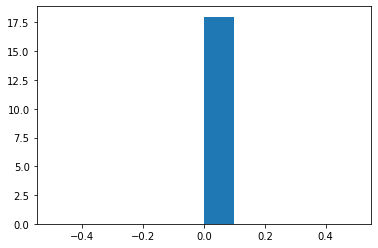


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COUNT_UNTIL_LARGER
Number of Attempts


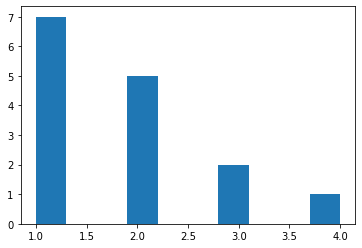


Summary Statistics
               0
count  15.000000
mean    1.800000
std     0.941124
min     1.000000
25%     1.000000
50%     2.000000
75%     2.000000
max     4.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


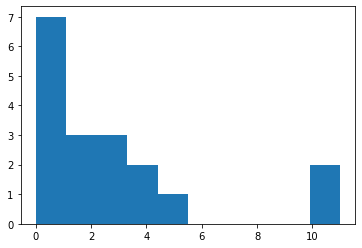


Summary Statistics
               0
count  18.000000
mean    3.055556
std     3.207935
min     0.000000
25%     1.000000
50%     2.000000
75%     3.750000
max    11.000000


FILTER_SEQUENCE
Number of Attempts


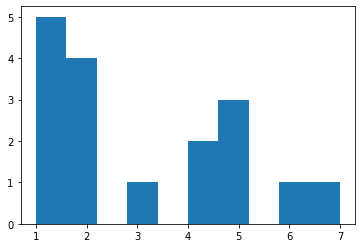


Summary Statistics
               0
count  17.000000
mean    3.058824
std     1.983387
min     1.000000
25%     1.000000
50%     2.000000
75%     5.000000
max     7.000000


ACCUMULATE
Number of Attempts


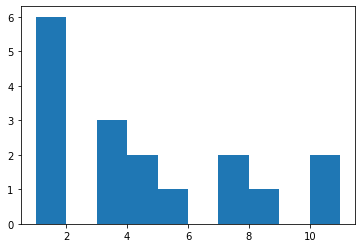


Summary Statistics
               0
count  17.000000
mean    4.235294
std     3.437467
min     1.000000
25%     1.000000
50%     3.000000
75%     7.000000
max    11.000000


RESTRICT_RANGE
Number of Attempts


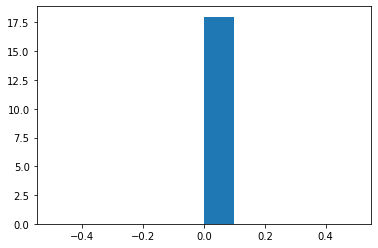


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


AGAIN
Number of Attempts


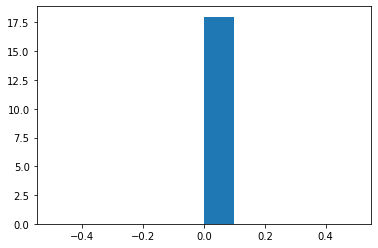


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [160]:
num_attempts_graphs_by_level('hw02-sp22.csv')


Generating num attempts for hw02-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['summation_using_accumulate', 'count_until_larger', 'product_using_accumulate', 'again', 'restrict_range', 'product', 'hailstone', 'filter_sequence', 'restrict_both', 'restrict_domain', 'accumulate']

SUMMATION_USING_ACCUMULATE
Number of Attempts


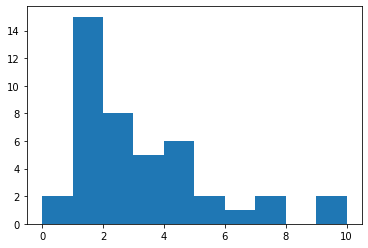


Summary Statistics
               0
count  43.000000
mean    2.767442
std     2.307722
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    10.000000


COUNT_UNTIL_LARGER
Number of Attempts


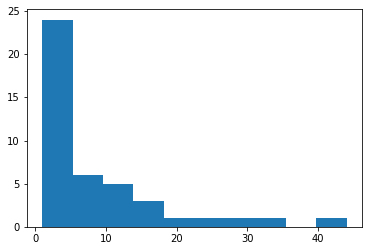


Summary Statistics
               0
count  43.000000
mean    8.069767
std     9.567792
min     1.000000
25%     2.000000
50%     4.000000
75%    11.000000
max    44.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


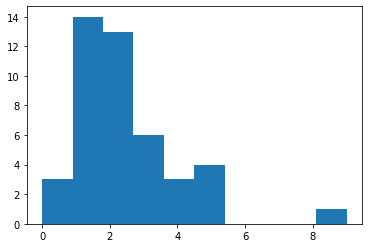


Summary Statistics
              0
count  44.00000
mean    2.25000
std     1.71349
min     0.00000
25%     1.00000
50%     2.00000
75%     3.00000
max     9.00000


AGAIN
Number of Attempts


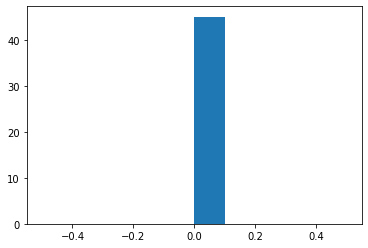


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


RESTRICT_RANGE
Number of Attempts


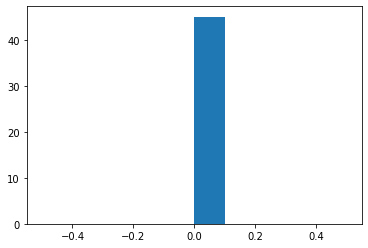


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PRODUCT
Number of Attempts


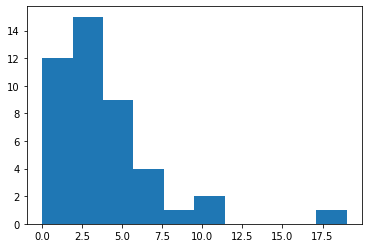


Summary Statistics
               0
count  44.000000
mean    3.704545
std     3.474690
min     0.000000
25%     1.000000
50%     3.000000
75%     5.000000
max    19.000000


HAILSTONE
Number of Attempts


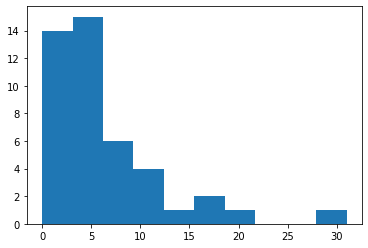


Summary Statistics
               0
count  44.000000
mean    6.477273
std     6.032812
min     0.000000
25%     3.000000
50%     5.000000
75%     8.250000
max    31.000000


FILTER_SEQUENCE
Number of Attempts


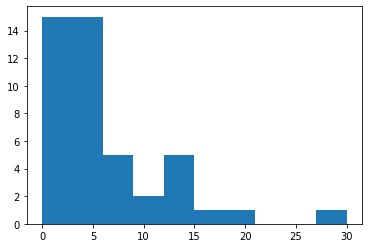


Summary Statistics
               0
count  45.000000
mean    5.755556
std     5.962594
min     0.000000
25%     1.000000
50%     4.000000
75%     8.000000
max    30.000000


RESTRICT_BOTH
Number of Attempts


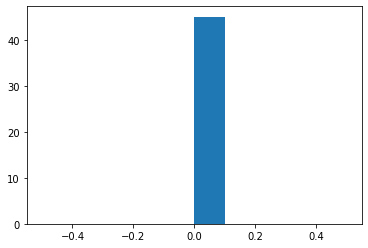


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


RESTRICT_DOMAIN
Number of Attempts


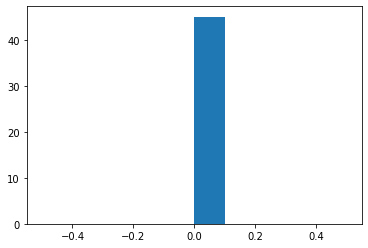


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ACCUMULATE
Number of Attempts


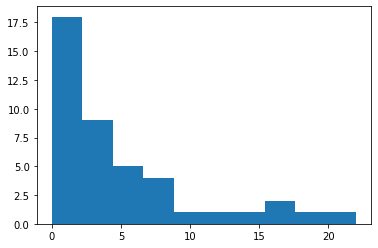


Summary Statistics
               0
count  43.000000
mean    5.162791
std     5.358261
min     0.000000
25%     2.000000
50%     3.000000
75%     6.500000
max    22.000000



In [71]:
num_attempts_graphs_using_df('hw02-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

Generating num attempts for hw02.csv, using ['mul_church', 'make_repeater', 'product_using_accumulate', 'make_repeater_extra', 'add_church', 'church_to_int', 'pow_church', 'summation_using_accumulate', 'compose1', 'make_repeater2', 'successor', 'accumulate', 'product', 'zero', 'two', 'one']

MUL_CHURCH
Number of Attempts


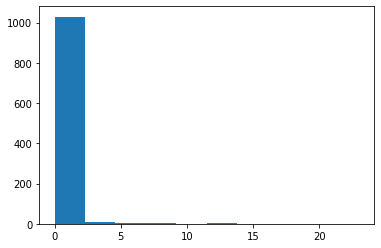


Summary Statistics
                 0
count  1048.000000
mean      0.153626
std       1.148175
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      23.000000


MAKE_REPEATER
Number of Attempts


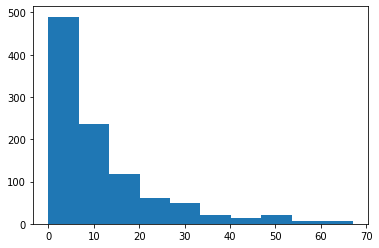


Summary Statistics
                 0
count  1023.000000
mean     11.501466
std      12.641827
min       0.000000
25%       3.000000
50%       7.000000
75%      15.000000
max      67.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


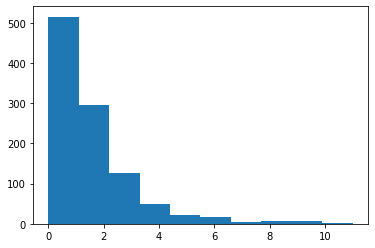


Summary Statistics
                 0
count  1045.000000
mean      1.898565
std       1.529796
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max      11.000000


MAKE_REPEATER_EXTRA
Number of Attempts


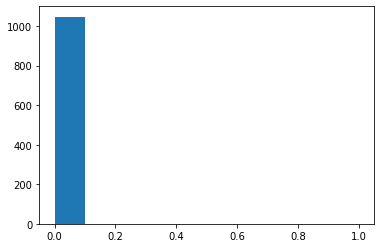


Summary Statistics
                 0
count  1048.000000
mean      0.000954
std       0.030890
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


ADD_CHURCH
Number of Attempts


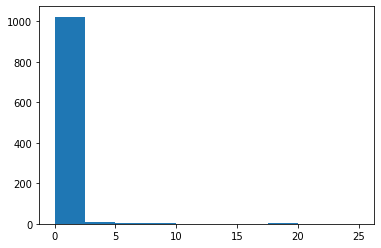


Summary Statistics
                 0
count  1048.000000
mean      0.208969
std       1.463741
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      25.000000


CHURCH_TO_INT
Number of Attempts


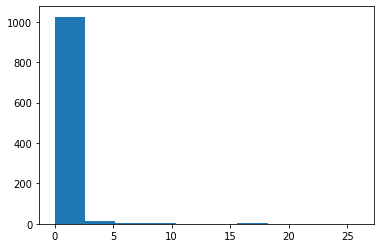


Summary Statistics
                 0
count  1048.000000
mean      0.229962
std       1.506300
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      26.000000


POW_CHURCH
Number of Attempts


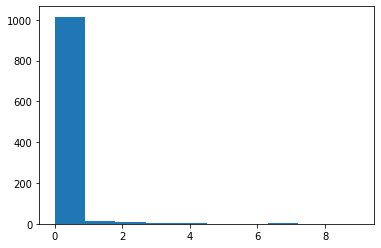


Summary Statistics
                 0
count  1048.000000
mean      0.080153
std       0.585781
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       9.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


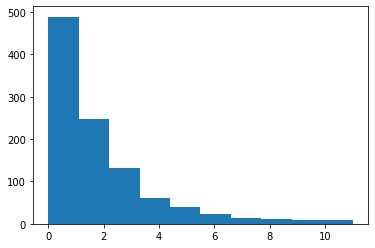


Summary Statistics
                0
count  1033.00000
mean      2.17425
std       1.83913
min       0.00000
25%       1.00000
50%       2.00000
75%       3.00000
max      11.00000


COMPOSE1
Number of Attempts


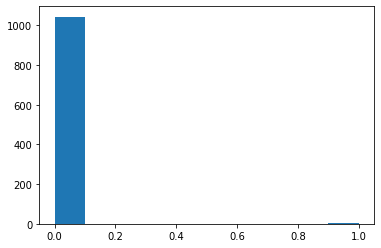


Summary Statistics
                 0
count  1048.000000
mean      0.003817
std       0.061692
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


MAKE_REPEATER2
Number of Attempts


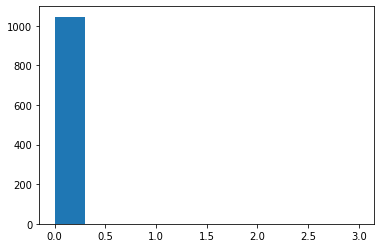


Summary Statistics
                 0
count  1048.000000
mean      0.003817
std       0.097655
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000


SUCCESSOR
Number of Attempts


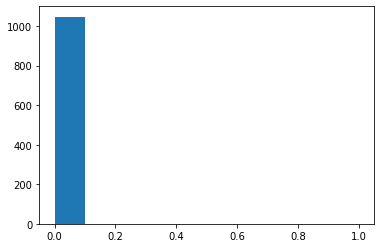


Summary Statistics
                 0
count  1048.000000
mean      0.000954
std       0.030890
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


ACCUMULATE
Number of Attempts


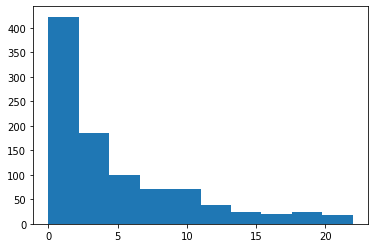


Summary Statistics
                0
count  976.000000
mean     5.025615
std      4.996035
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


PRODUCT
Number of Attempts


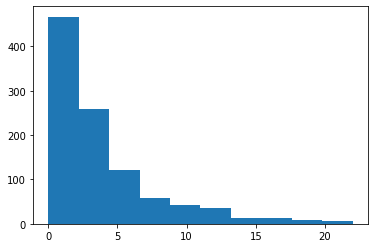


Summary Statistics
                 0
count  1023.000000
mean      4.031281
std       3.815331
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max      22.000000


ZERO
Number of Attempts



Summary Statistics
                 0
count  1048.000000
mean      0.002863
std       0.069046
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


TWO
Number of Attempts


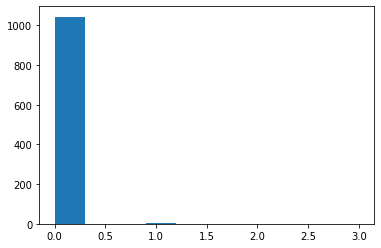


Summary Statistics
                 0
count  1048.000000
mean      0.006679
std       0.111228
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000


ONE
Number of Attempts



Summary Statistics
                 0
count  1048.000000
mean      0.012405
std       0.154025
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000



In [161]:
num_attempts_graphs('hw02.csv')


Generating num attempts for hw02.csv, stratified by level, using ['mul_church', 'make_repeater', 'product_using_accumulate', 'make_repeater_extra', 'add_church', 'church_to_int', 'pow_church', 'summation_using_accumulate', 'compose1', 'make_repeater2', 'successor', 'accumulate', 'product', 'zero', 'two', 'one']
BEGINNER

MUL_CHURCH
Number of Attempts



Summary Statistics
                0
count  580.000000
mean     0.137931
std      1.218004
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     23.000000


MAKE_REPEATER
Number of Attempts



Summary Statistics
                0
count  564.000000
mean    12.180851
std     13.304305
min      0.000000
25%      3.000000
50%      7.500000
75%     17.000000
max     67.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


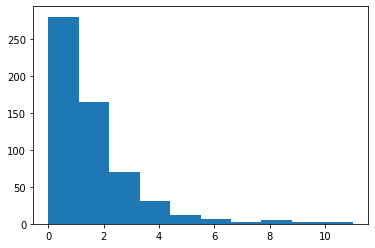


Summary Statistics
                0
count  577.000000
mean     1.909879
std      1.513432
min      0.000000
25%      1.000000
50%      2.000000
75%      2.000000
max     11.000000


MAKE_REPEATER_EXTRA
Number of Attempts



Summary Statistics
           0
count  580.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ADD_CHURCH
Number of Attempts



Summary Statistics
                0
count  580.000000
mean     0.189655
std      1.503673
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     25.000000


CHURCH_TO_INT
Number of Attempts


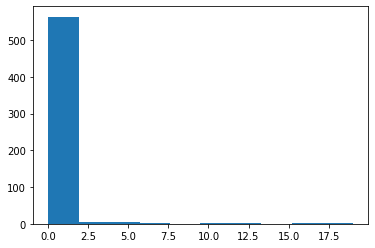


Summary Statistics
                0
count  580.000000
mean     0.198276
std      1.377213
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     19.000000


POW_CHURCH
Number of Attempts



Summary Statistics
                0
count  580.000000
mean     0.051724
std      0.432785
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
                0
count  572.000000
mean     2.325175
std      1.975116
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


COMPOSE1
Number of Attempts


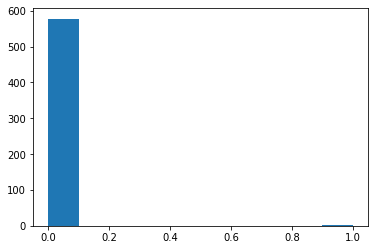


Summary Statistics
                0
count  580.000000
mean     0.003448
std      0.058671
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


MAKE_REPEATER2
Number of Attempts


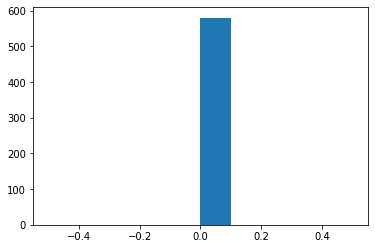


Summary Statistics
           0
count  580.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SUCCESSOR
Number of Attempts


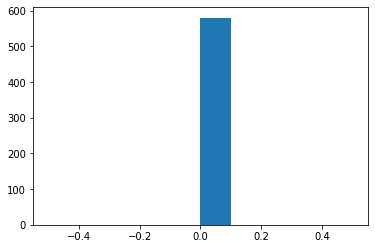


Summary Statistics
           0
count  580.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ACCUMULATE
Number of Attempts



Summary Statistics
                0
count  562.000000
mean     6.516014
std      7.075649
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     33.000000


PRODUCT
Number of Attempts


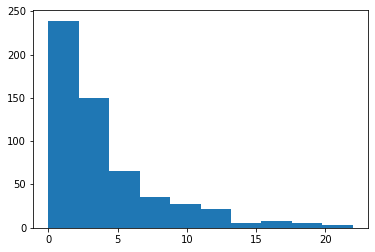


Summary Statistics
                0
count  562.000000
mean     4.249110
std      3.882206
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max     22.000000


ZERO
Number of Attempts


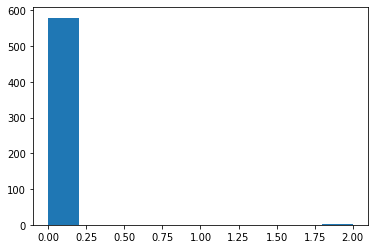


Summary Statistics
                0
count  580.000000
mean     0.003448
std      0.083045
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


TWO
Number of Attempts


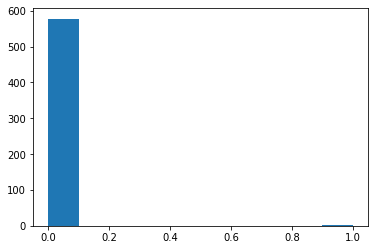


Summary Statistics
                0
count  580.000000
mean     0.003448
std      0.058671
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


ONE
Number of Attempts


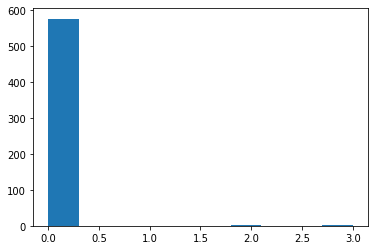


Summary Statistics
                0
count  580.000000
mean     0.012069
std      0.170924
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000

INTERMEDIATE

MUL_CHURCH
Number of Attempts



Summary Statistics
                0
count  241.000000
mean     0.099585
std      0.825656
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      9.000000


MAKE_REPEATER
Number of Attempts


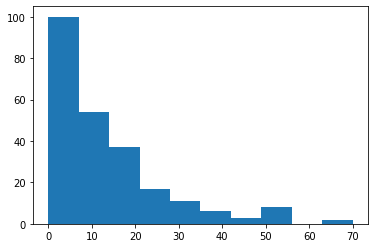


Summary Statistics
                0
count  238.000000
mean    13.029412
std     13.391350
min      0.000000
25%      3.000000
50%      9.000000
75%     18.000000
max     70.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


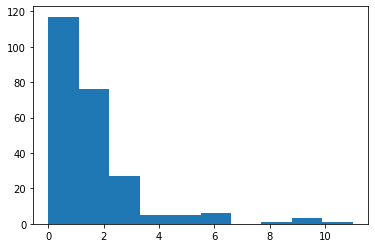


Summary Statistics
                0
count  241.000000
mean     1.925311
std      1.589884
min      0.000000
25%      1.000000
50%      2.000000
75%      2.000000
max     11.000000


MAKE_REPEATER_EXTRA
Number of Attempts


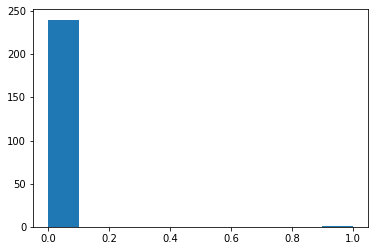


Summary Statistics
                0
count  241.000000
mean     0.004149
std      0.064416
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


ADD_CHURCH
Number of Attempts


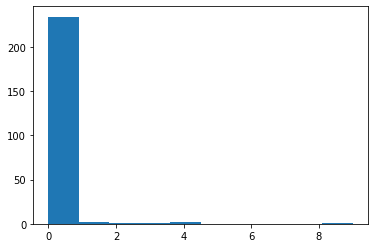


Summary Statistics
                0
count  241.000000
mean     0.099585
std      0.723446
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      9.000000


CHURCH_TO_INT
Number of Attempts



Summary Statistics
                0
count  241.000000
mean     0.215768
std      1.773391
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     26.000000


POW_CHURCH
Number of Attempts


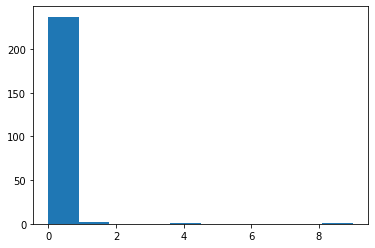


Summary Statistics
                0
count  241.000000
mean     0.062241
std      0.639226
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      9.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts



Summary Statistics
                0
count  237.000000
mean     2.025316
std      1.553902
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


COMPOSE1
Number of Attempts


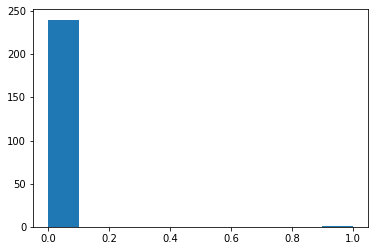


Summary Statistics
                0
count  241.000000
mean     0.004149
std      0.064416
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


MAKE_REPEATER2
Number of Attempts



Summary Statistics
           0
count  241.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SUCCESSOR
Number of Attempts


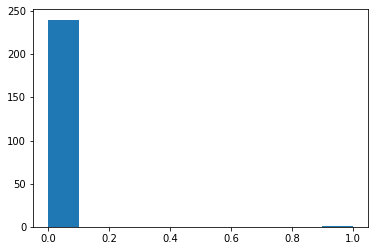


Summary Statistics
                0
count  241.000000
mean     0.004149
std      0.064416
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


ACCUMULATE
Number of Attempts


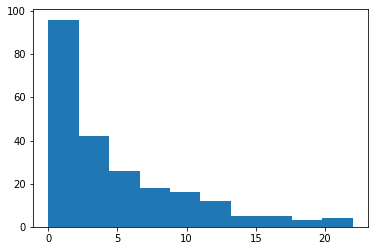


Summary Statistics
                0
count  227.000000
mean     4.973568
std      4.805897
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


PRODUCT
Number of Attempts


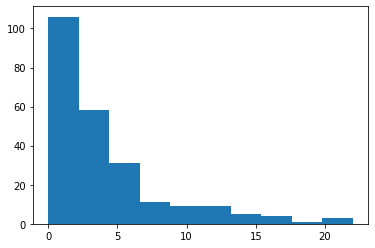


Summary Statistics
                0
count  237.000000
mean     4.257384
std      4.159581
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max     22.000000


ZERO
Number of Attempts


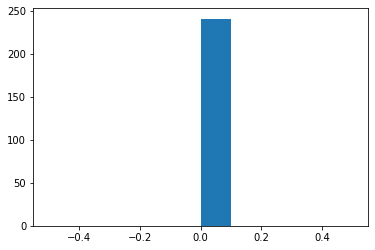


Summary Statistics
           0
count  241.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TWO
Number of Attempts


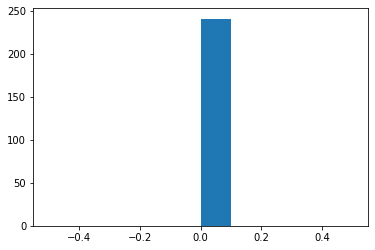


Summary Statistics
           0
count  241.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ONE
Number of Attempts


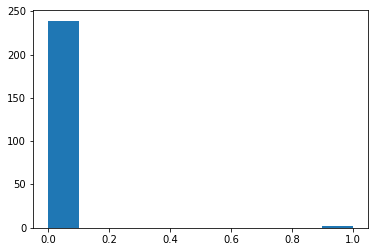


Summary Statistics
                0
count  241.000000
mean     0.008299
std      0.090908
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

ADVANCED

MUL_CHURCH
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.407407
std     1.759791
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     9.000000


MAKE_REPEATER
Number of Attempts



Summary Statistics
               0
count  25.000000
mean    8.560000
std     7.427875
min     0.000000
25%     3.000000
50%     8.000000
75%    11.000000
max    31.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    1.888889
std     1.219500
min     0.000000
25%     1.000000
50%     2.000000
75%     3.000000
max     5.000000


MAKE_REPEATER_EXTRA
Number of Attempts


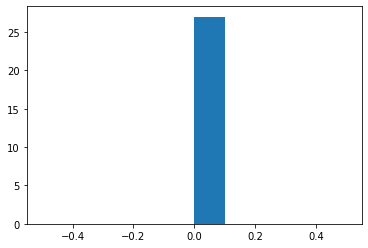


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ADD_CHURCH
Number of Attempts


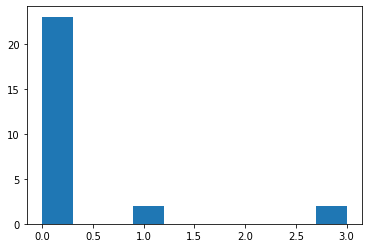


Summary Statistics
               0
count  27.000000
mean    0.296296
std     0.823446
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


CHURCH_TO_INT
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    1.037037
std     3.491545
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    18.000000


POW_CHURCH
Number of Attempts


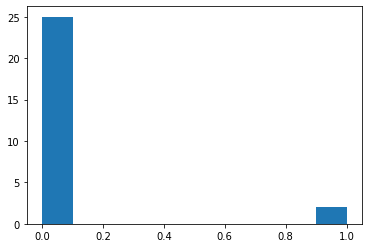


Summary Statistics
               0
count  27.000000
mean    0.074074
std     0.266880
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


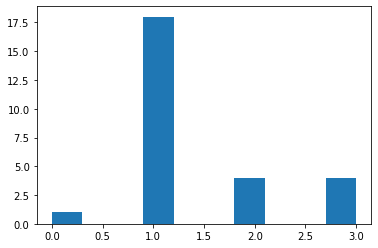


Summary Statistics
               0
count  27.000000
mean    1.407407
std     0.797074
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     3.000000


COMPOSE1
Number of Attempts


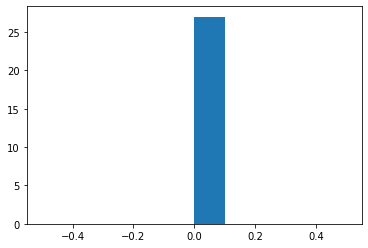


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MAKE_REPEATER2
Number of Attempts


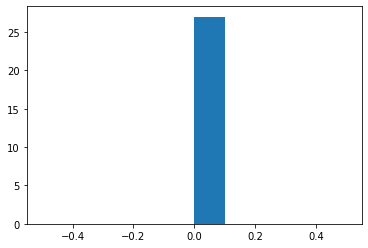


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SUCCESSOR
Number of Attempts


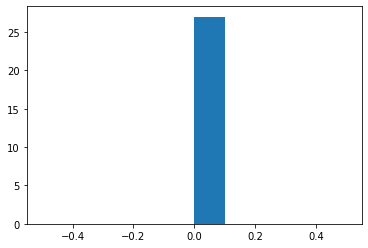


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ACCUMULATE
Number of Attempts


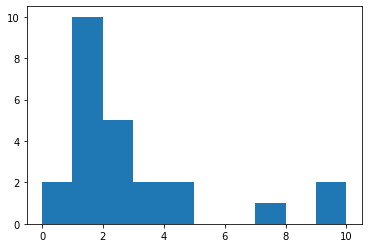


Summary Statistics
               0
count  24.000000
mean    2.500000
std     2.637522
min     0.000000
25%     1.000000
50%     1.500000
75%     3.000000
max    10.000000


PRODUCT
Number of Attempts


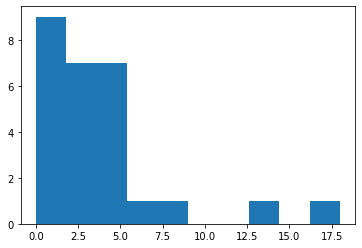


Summary Statistics
               0
count  27.000000
mean    3.740741
std     3.967101
min     0.000000
25%     1.000000
50%     3.000000
75%     4.000000
max    18.000000


ZERO
Number of Attempts


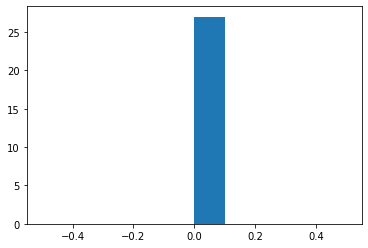


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


TWO
Number of Attempts


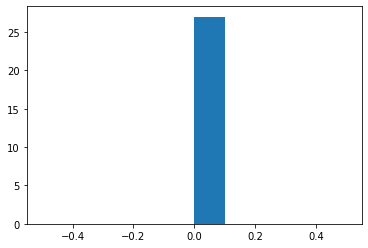


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ONE
Number of Attempts


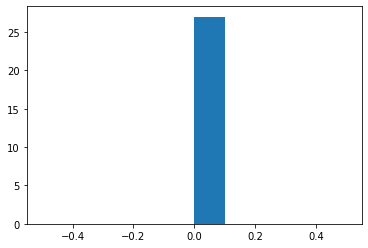


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [162]:
num_attempts_graphs_by_level('hw02.csv')


Generating num attempts for hw02.csv, for people in NO_LANGUAGES_BEFORE, using ['pow_church', 'compose1', 'make_repeater', 'add_church', 'make_repeater_extra', 'one', 'product_using_accumulate', 'zero', 'mul_church', 'product', 'church_to_int', 'summation_using_accumulate', 'two', 'successor', 'make_repeater2', 'accumulate']

POW_CHURCH
Number of Attempts


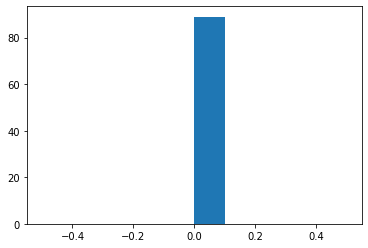


Summary Statistics
          0
count  89.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COMPOSE1
Number of Attempts


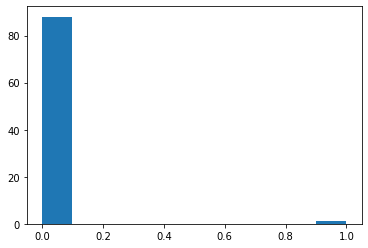


Summary Statistics
               0
count  89.000000
mean    0.011236
std     0.106000
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


MAKE_REPEATER
Number of Attempts


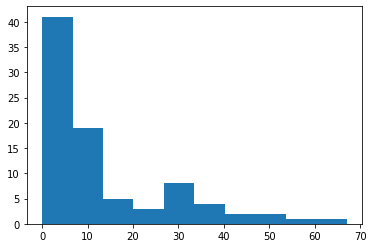


Summary Statistics
               0
count  86.000000
mean   13.465116
std    15.120456
min     0.000000
25%     3.000000
50%     7.000000
75%    20.000000
max    67.000000


ADD_CHURCH
Number of Attempts


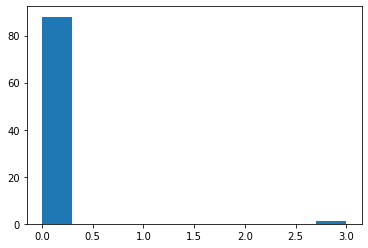


Summary Statistics
               0
count  89.000000
mean    0.033708
std     0.317999
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


MAKE_REPEATER_EXTRA
Number of Attempts


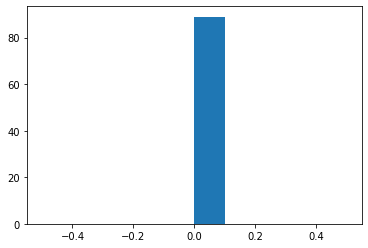


Summary Statistics
          0
count  89.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ONE
Number of Attempts


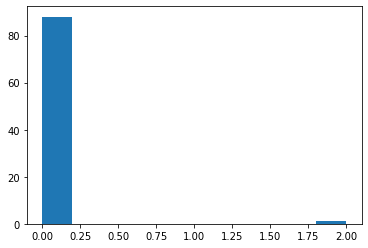


Summary Statistics
               0
count  89.000000
mean    0.022472
std     0.212000
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


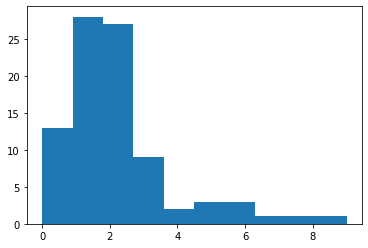


Summary Statistics
               0
count  88.000000
mean    1.977273
std     1.800238
min     0.000000
25%     1.000000
50%     2.000000
75%     2.000000
max     9.000000


ZERO
Number of Attempts


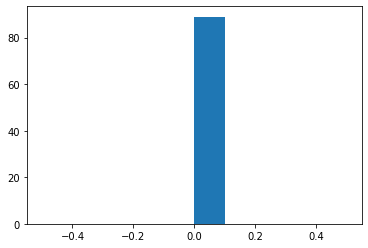


Summary Statistics
          0
count  89.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MUL_CHURCH
Number of Attempts


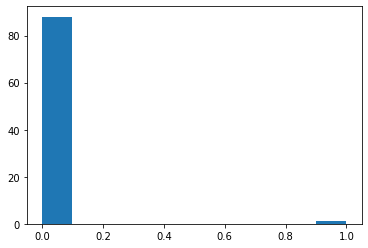


Summary Statistics
               0
count  89.000000
mean    0.011236
std     0.106000
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


PRODUCT
Number of Attempts


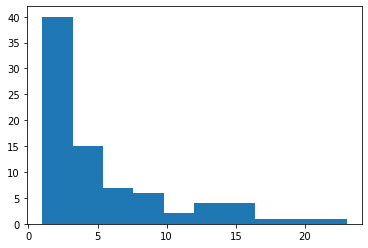


Summary Statistics
               0
count  81.000000
mean    5.382716
std     4.849144
min     1.000000
25%     2.000000
50%     4.000000
75%     7.000000
max    23.000000


CHURCH_TO_INT
Number of Attempts


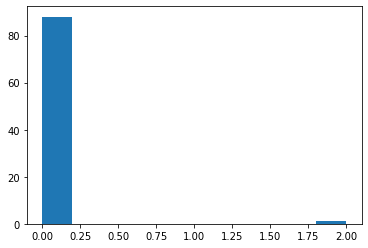


Summary Statistics
               0
count  89.000000
mean    0.022472
std     0.212000
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000


SUMMATION_USING_ACCUMULATE
Number of Attempts


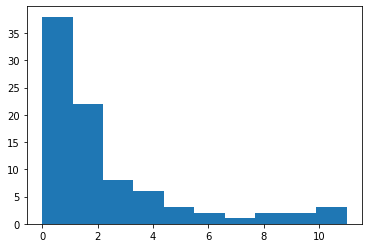


Summary Statistics
               0
count  87.000000
mean    2.551724
std     2.476675
min     0.000000
25%     1.000000
50%     2.000000
75%     3.000000
max    11.000000


TWO
Number of Attempts


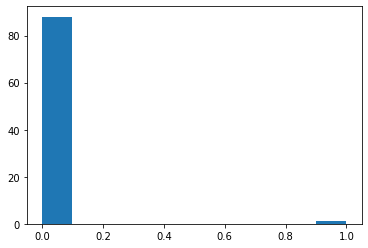


Summary Statistics
               0
count  89.000000
mean    0.011236
std     0.106000
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


SUCCESSOR
Number of Attempts


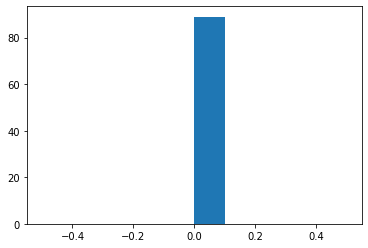


Summary Statistics
          0
count  89.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MAKE_REPEATER2
Number of Attempts


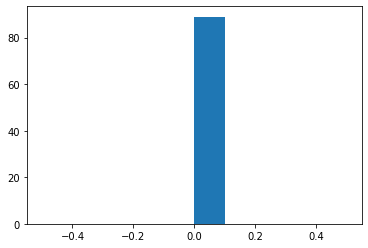


Summary Statistics
          0
count  89.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ACCUMULATE
Number of Attempts


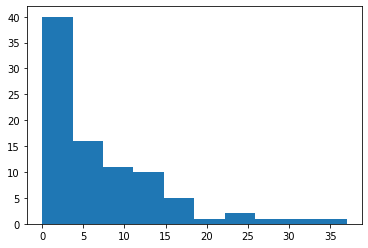


Summary Statistics
               0
count  88.000000
mean    7.250000
std     7.422008
min     0.000000
25%     2.000000
50%     5.000000
75%    10.250000
max    37.000000



In [72]:
num_attempts_graphs_using_df('hw02.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 03

Generating num attempts for hw03-sp22.csv, using ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'get_larger_coin', 'neighbor_digits', 'strictly_increasing', 'missing_digits']

HAS_SUBSEQ
Number of Attempts


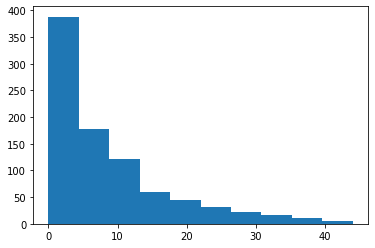


Summary Statistics
                0
count  878.000000
mean     8.658314
std      8.915510
min      0.000000
25%      2.000000
50%      5.000000
75%     12.000000
max     44.000000


COUNT_COINS
Number of Attempts


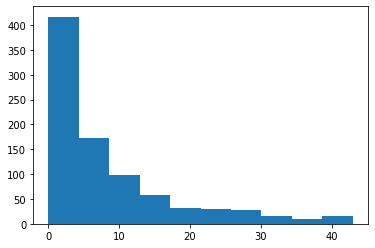


Summary Statistics
                0
count  876.000000
mean     8.234018
std      9.371387
min      0.000000
25%      2.000000
50%      5.000000
75%     11.000000
max     43.000000


PINGPONG
Number of Attempts


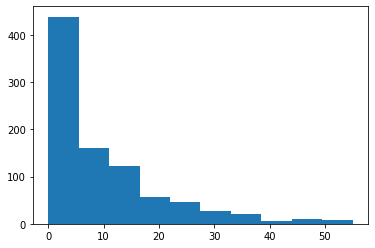


Summary Statistics
                0
count  894.000000
mean     9.665548
std     10.575437
min      0.000000
25%      2.000000
50%      6.000000
75%     13.000000
max     55.000000


NUM_EIGHTS
Number of Attempts


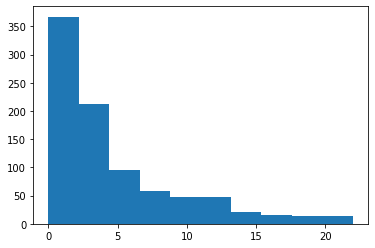


Summary Statistics
                0
count  889.000000
mean     4.779528
std      4.621579
min      0.000000
25%      2.000000
50%      3.000000
75%      6.000000
max     22.000000


GET_LARGER_COIN
Number of Attempts


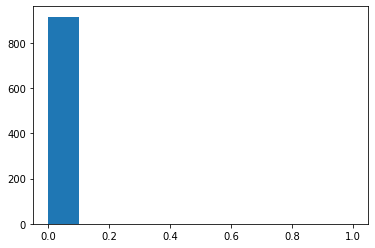


Summary Statistics
                0
count  918.000000
mean     0.001089
std      0.033005
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


NEIGHBOR_DIGITS
Number of Attempts



Summary Statistics
                0
count  887.000000
mean     8.990981
std      9.770500
min      0.000000
25%      2.000000
50%      5.000000
75%     13.000000
max     50.000000


STRICTLY_INCREASING
Number of Attempts



Summary Statistics
                0
count  918.000000
mean     0.002179
std      0.046651
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


MISSING_DIGITS
Number of Attempts



Summary Statistics
                0
count  918.000000
mean     0.007625
std      0.231034
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000



In [163]:
num_attempts_graphs('hw03-sp22.csv')


Generating num attempts for hw03-sp22.csv, stratified by level, using ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'get_larger_coin', 'neighbor_digits', 'strictly_increasing', 'missing_digits']
BEGINNER

HAS_SUBSEQ
Number of Attempts


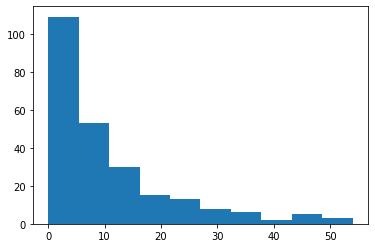


Summary Statistics
                0
count  244.000000
mean    10.512295
std     11.265038
min      0.000000
25%      2.000000
50%      7.000000
75%     14.000000
max     54.000000


COUNT_COINS
Number of Attempts


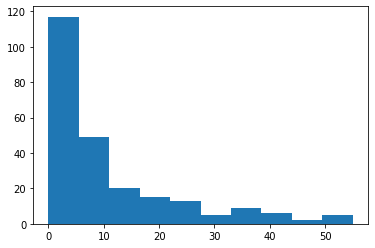


Summary Statistics
                0
count  241.000000
mean    10.597510
std     12.491323
min      0.000000
25%      2.000000
50%      6.000000
75%     14.000000
max     55.000000


PINGPONG
Number of Attempts


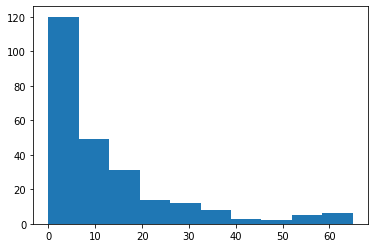


Summary Statistics
               0
count  250.00000
mean    12.35600
std     14.36575
min      0.00000
25%      3.00000
50%      7.00000
75%     16.00000
max     65.00000


NUM_EIGHTS
Number of Attempts



Summary Statistics
                0
count  243.000000
mean     5.127572
std      4.930528
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


GET_LARGER_COIN
Number of Attempts


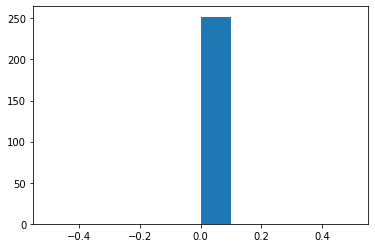


Summary Statistics
           0
count  252.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


NEIGHBOR_DIGITS
Number of Attempts


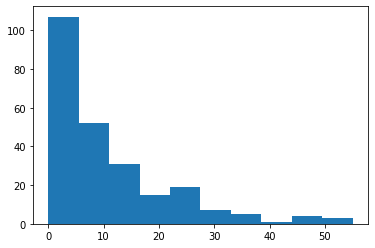


Summary Statistics
                0
count  244.000000
mean    10.737705
std     11.043724
min      0.000000
25%      3.000000
50%      6.500000
75%     15.000000
max     55.000000


STRICTLY_INCREASING
Number of Attempts


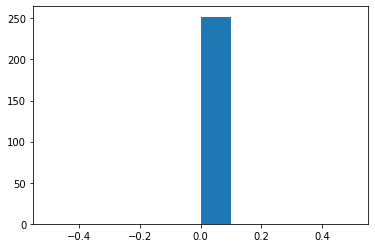


Summary Statistics
           0
count  252.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MISSING_DIGITS
Number of Attempts


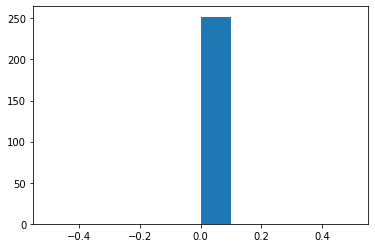


Summary Statistics
           0
count  252.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

INTERMEDIATE

HAS_SUBSEQ
Number of Attempts


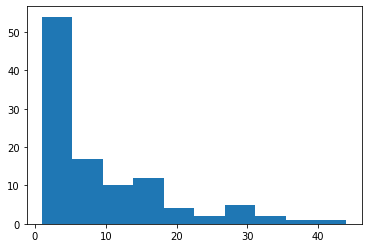


Summary Statistics
                0
count  108.000000
mean     9.138889
std      9.113468
min      1.000000
25%      2.750000
50%      5.500000
75%     13.250000
max     44.000000


COUNT_COINS
Number of Attempts


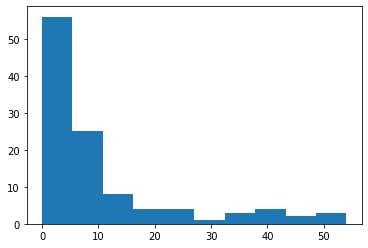


Summary Statistics
                0
count  110.000000
mean    10.290909
std     13.219631
min      0.000000
25%      1.250000
50%      5.000000
75%     11.000000
max     54.000000


PINGPONG
Number of Attempts


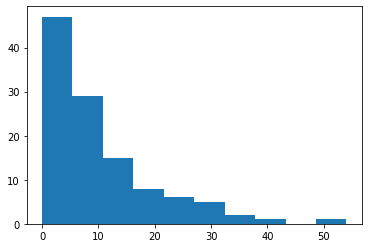


Summary Statistics
                0
count  114.000000
mean    10.052632
std      9.853657
min      0.000000
25%      3.000000
50%      7.000000
75%     13.000000
max     54.000000


NUM_EIGHTS
Number of Attempts


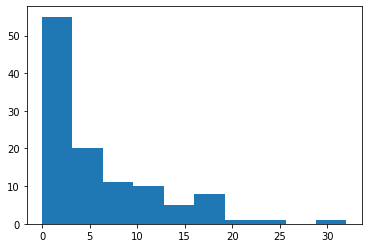


Summary Statistics
                0
count  112.000000
mean     5.955357
std      5.909815
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     32.000000


GET_LARGER_COIN
Number of Attempts


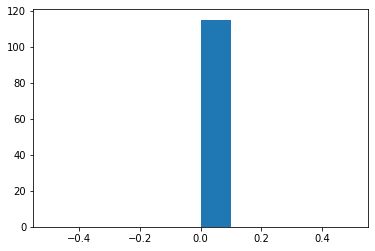


Summary Statistics
           0
count  115.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


NEIGHBOR_DIGITS
Number of Attempts


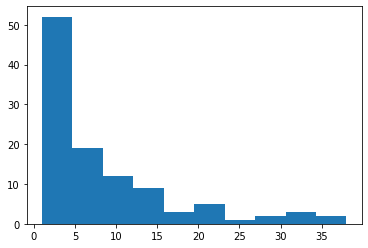


Summary Statistics
                0
count  108.000000
mean     8.277778
std      8.867491
min      1.000000
25%      2.000000
50%      5.000000
75%     12.000000
max     38.000000


STRICTLY_INCREASING
Number of Attempts


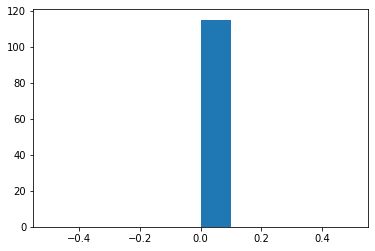


Summary Statistics
           0
count  115.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MISSING_DIGITS
Number of Attempts


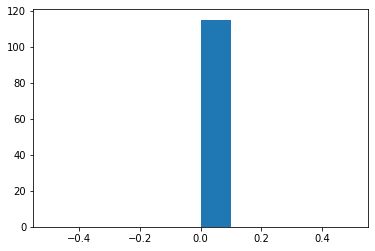


Summary Statistics
           0
count  115.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

ADVANCED

HAS_SUBSEQ
Number of Attempts


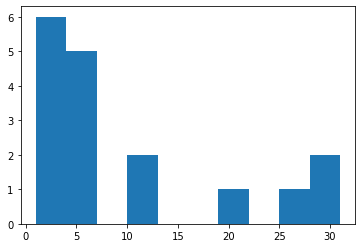


Summary Statistics
               0
count  17.000000
mean    9.647059
std    10.301342
min     1.000000
25%     3.000000
50%     5.000000
75%    11.000000
max    31.000000


COUNT_COINS
Number of Attempts


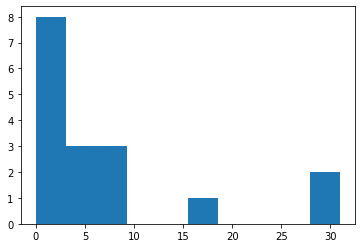


Summary Statistics
               0
count  17.000000
mean    7.705882
std     9.635642
min     0.000000
25%     2.000000
50%     5.000000
75%     8.000000
max    31.000000


PINGPONG
Number of Attempts


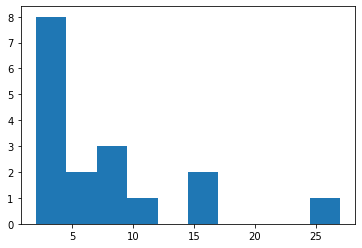


Summary Statistics
               0
count  17.000000
mean    7.588235
std     6.792080
min     2.000000
25%     2.000000
50%     5.000000
75%     9.000000
max    27.000000


NUM_EIGHTS
Number of Attempts



Summary Statistics
               0
count  18.000000
mean    6.833333
std     7.382412
min     1.000000
25%     2.000000
50%     4.500000
75%     8.000000
max    27.000000


GET_LARGER_COIN
Number of Attempts


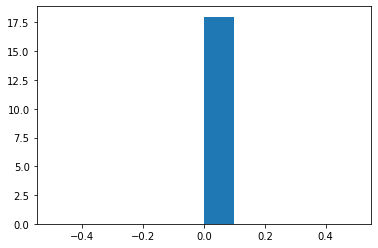


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


NEIGHBOR_DIGITS
Number of Attempts


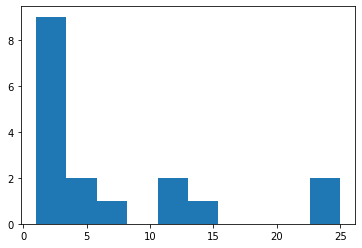


Summary Statistics
               0
count  17.000000
mean    7.117647
std     7.849223
min     1.000000
25%     2.000000
50%     3.000000
75%    12.000000
max    25.000000


STRICTLY_INCREASING
Number of Attempts


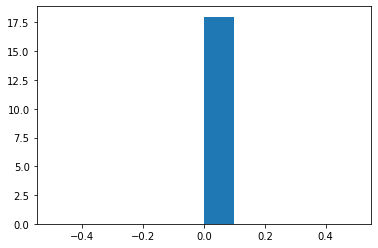


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MISSING_DIGITS
Number of Attempts


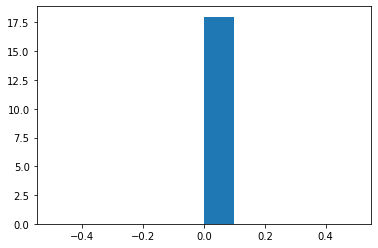


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [164]:
num_attempts_graphs_by_level('hw03-sp22.csv')


Generating num attempts for hw03-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['get_larger_coin', 'num_eights', 'count_coins', 'has_subseq', 'missing_digits', 'strictly_increasing', 'neighbor_digits', 'pingpong']

GET_LARGER_COIN
Number of Attempts



Summary Statistics
          0
count  32.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


NUM_EIGHTS
Number of Attempts


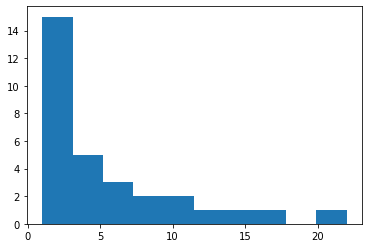


Summary Statistics
               0
count  31.000000
mean    5.548387
std     5.258889
min     1.000000
25%     2.000000
50%     4.000000
75%     7.000000
max    22.000000


COUNT_COINS
Number of Attempts



Summary Statistics
               0
count  31.000000
mean   16.419355
std    15.800367
min     0.000000
25%     5.000000
50%     9.000000
75%    31.000000
max    50.000000


HAS_SUBSEQ
Number of Attempts


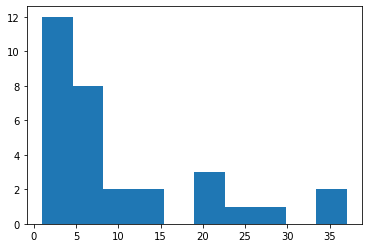


Summary Statistics
               0
count  31.000000
mean    9.870968
std    10.323894
min     1.000000
25%     2.000000
50%     5.000000
75%    13.000000
max    37.000000


MISSING_DIGITS
Number of Attempts


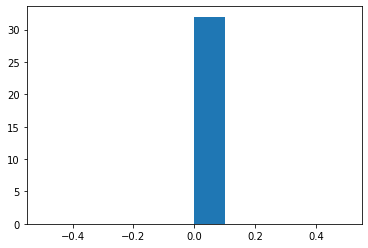


Summary Statistics
          0
count  32.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


STRICTLY_INCREASING
Number of Attempts


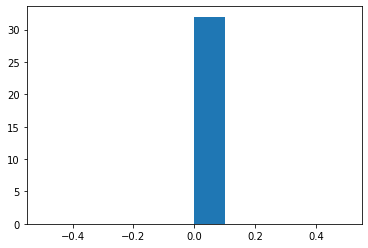


Summary Statistics
          0
count  32.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


NEIGHBOR_DIGITS
Number of Attempts


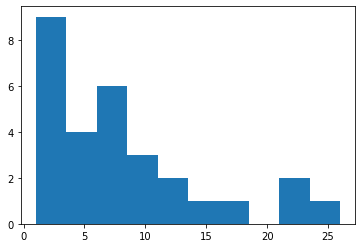


Summary Statistics
               0
count  29.000000
mean    8.103448
std     6.449501
min     1.000000
25%     3.000000
50%     7.000000
75%    10.000000
max    26.000000


PINGPONG
Number of Attempts


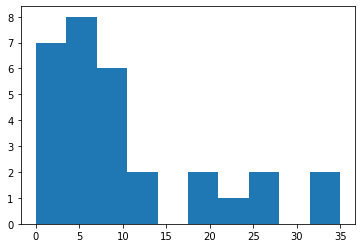


Summary Statistics
               0
count  30.000000
mean   10.166667
std     9.716972
min     0.000000
25%     4.000000
50%     6.500000
75%    12.750000
max    35.000000



In [73]:
num_attempts_graphs_using_df('hw03-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

Generating num attempts for hw03.csv, using ['move_stack', 'get_next_coin', 'count_coins', 'pingpong', 'make_anonymous_factorial', 'mario_number', 'has_sum', 'num_eights', 'is_palindrome', 'missing_digits']

MOVE_STACK
Number of Attempts


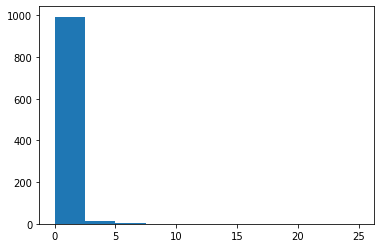


Summary Statistics
                 0
count  1016.000000
mean      0.154528
std       1.084935
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      25.000000


GET_NEXT_COIN
Number of Attempts


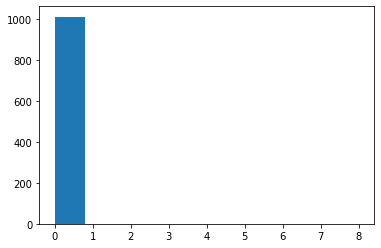


Summary Statistics
                 0
count  1016.000000
mean      0.010827
std       0.260505
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       8.000000


COUNT_COINS
Number of Attempts


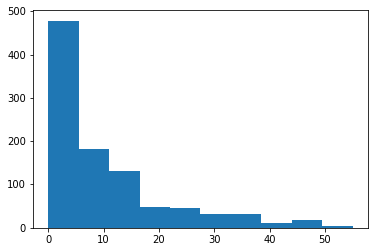


Summary Statistics
                0
count  983.000000
mean     9.949135
std     11.486974
min      0.000000
25%      2.000000
50%      6.000000
75%     14.000000
max     55.000000


PINGPONG
Number of Attempts


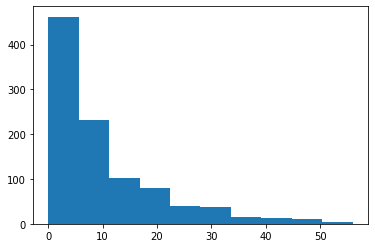


Summary Statistics
                0
count  996.000000
mean     9.964859
std     10.518124
min      0.000000
25%      3.000000
50%      6.000000
75%     14.000000
max     56.000000


MAKE_ANONYMOUS_FACTORIAL
Number of Attempts


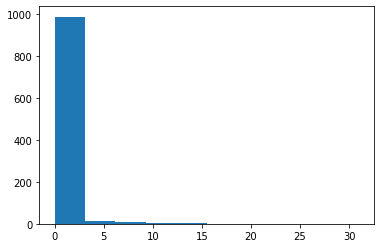


Summary Statistics
                 0
count  1016.000000
mean      0.307087
std       1.696182
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      31.000000


MARIO_NUMBER
Number of Attempts


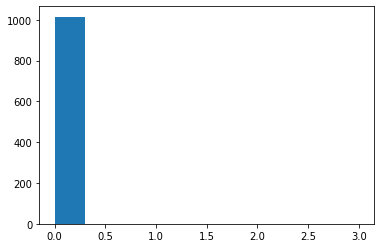


Summary Statistics
                 0
count  1016.000000
mean      0.002953
std       0.094118
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000


HAS_SUM
Number of Attempts


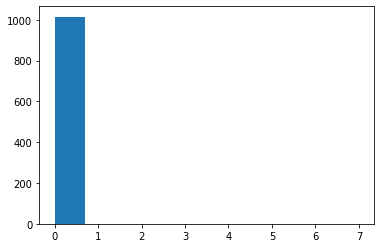


Summary Statistics
                0
count  1016.00000
mean      0.00689
std       0.21961
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       7.00000


NUM_EIGHTS
Number of Attempts


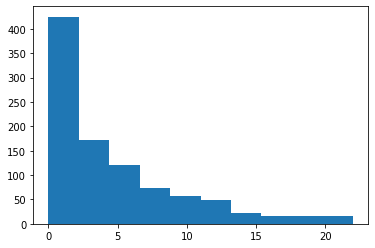


Summary Statistics
                0
count  965.000000
mean     4.833161
std      4.683570
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


IS_PALINDROME
Number of Attempts


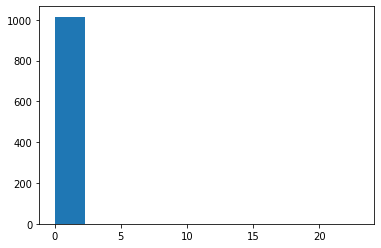


Summary Statistics
                 0
count  1016.000000
mean      0.022638
std       0.721574
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      23.000000


MISSING_DIGITS
Number of Attempts


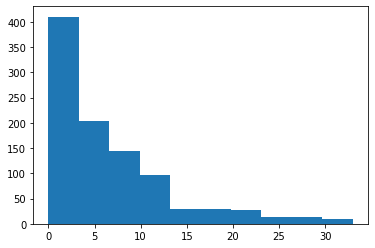


Summary Statistics
                0
count  979.000000
mean     6.555669
std      6.607280
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     33.000000



In [165]:
num_attempts_graphs('hw03.csv')


Generating num attempts for hw03.csv, stratified by level, using ['move_stack', 'get_next_coin', 'count_coins', 'pingpong', 'make_anonymous_factorial', 'mario_number', 'has_sum', 'num_eights', 'is_palindrome', 'missing_digits']
BEGINNER

MOVE_STACK
Number of Attempts


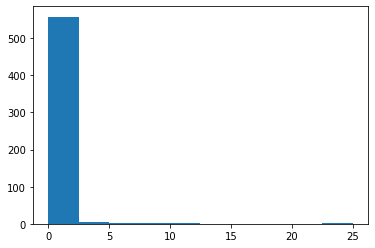


Summary Statistics
                0
count  570.000000
mean     0.171930
std      1.333067
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     25.000000


GET_NEXT_COIN
Number of Attempts


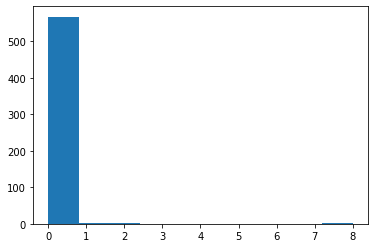


Summary Statistics
                0
count  570.000000
mean     0.019298
std      0.347696
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      8.000000


COUNT_COINS
Number of Attempts


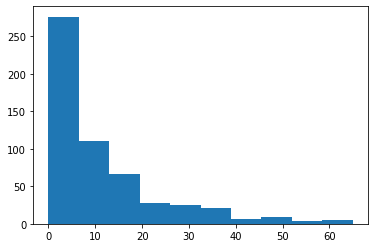


Summary Statistics
                0
count  553.000000
mean    10.842676
std     12.638745
min      0.000000
25%      2.000000
50%      7.000000
75%     15.000000
max     65.000000


PINGPONG
Number of Attempts


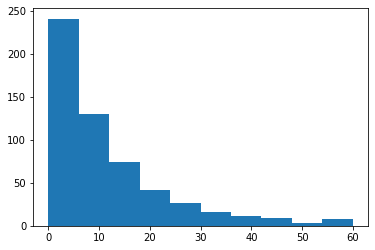


Summary Statistics
                0
count  561.000000
mean    11.149733
std     11.731172
min      0.000000
25%      3.000000
50%      7.000000
75%     15.000000
max     60.000000


MAKE_ANONYMOUS_FACTORIAL
Number of Attempts


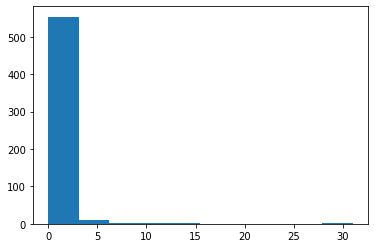


Summary Statistics
                0
count  570.000000
mean     0.282456
std      1.753492
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     31.000000


MARIO_NUMBER
Number of Attempts


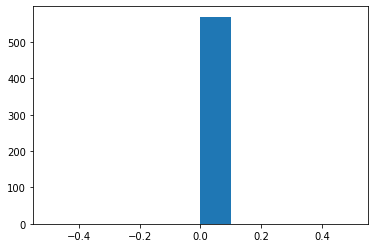


Summary Statistics
           0
count  570.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


HAS_SUM
Number of Attempts


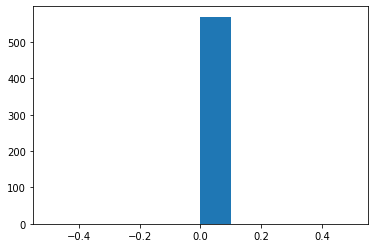


Summary Statistics
           0
count  570.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


NUM_EIGHTS
Number of Attempts


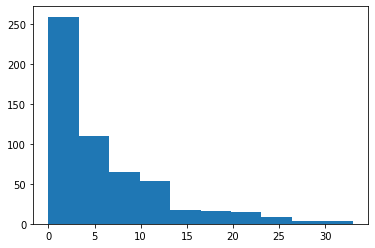


Summary Statistics
                0
count  552.000000
mean     6.132246
std      6.241560
min      0.000000
25%      2.000000
50%      4.000000
75%      8.250000
max     33.000000


IS_PALINDROME
Number of Attempts


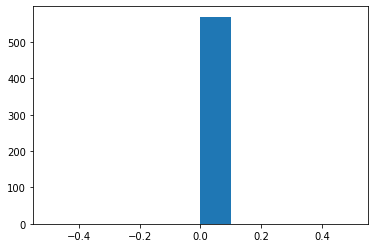


Summary Statistics
           0
count  570.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MISSING_DIGITS
Number of Attempts


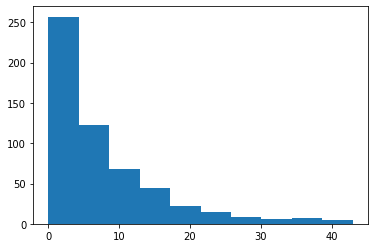


Summary Statistics
                0
count  557.000000
mean     7.895871
std      8.238570
min      0.000000
25%      2.000000
50%      5.000000
75%     11.000000
max     43.000000

INTERMEDIATE

MOVE_STACK
Number of Attempts


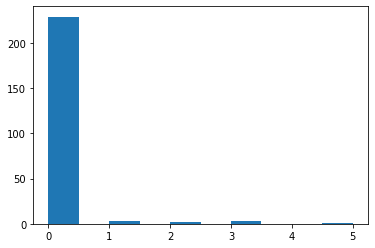


Summary Statistics
                0
count  238.000000
mean     0.088235
std      0.507941
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


GET_NEXT_COIN
Number of Attempts


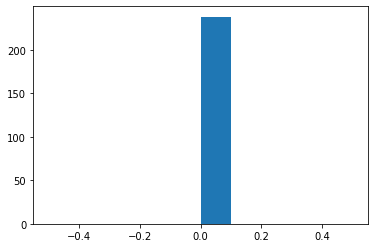


Summary Statistics
           0
count  238.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COUNT_COINS
Number of Attempts


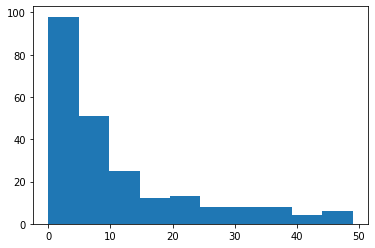


Summary Statistics
                0
count  233.000000
mean    10.815451
std     12.212745
min      0.000000
25%      2.000000
50%      6.000000
75%     15.000000
max     49.000000


PINGPONG
Number of Attempts


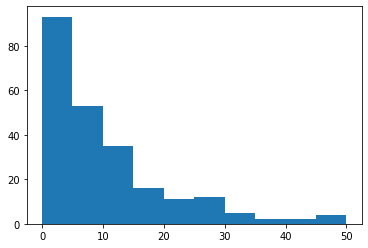


Summary Statistics
                0
count  233.000000
mean     9.901288
std     10.190583
min      0.000000
25%      3.000000
50%      7.000000
75%     13.000000
max     50.000000


MAKE_ANONYMOUS_FACTORIAL
Number of Attempts


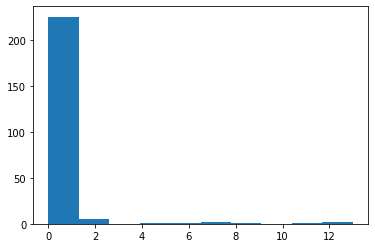


Summary Statistics
                0
count  238.000000
mean     0.344538
std      1.658310
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


MARIO_NUMBER
Number of Attempts


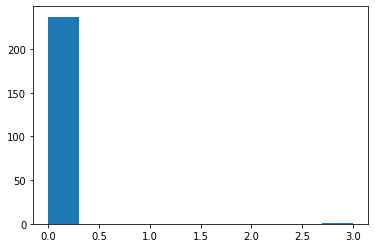


Summary Statistics
                0
count  238.000000
mean     0.012605
std      0.194461
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


HAS_SUM
Number of Attempts


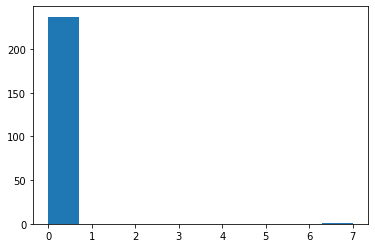


Summary Statistics
                0
count  238.000000
mean     0.029412
std      0.453743
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


NUM_EIGHTS
Number of Attempts


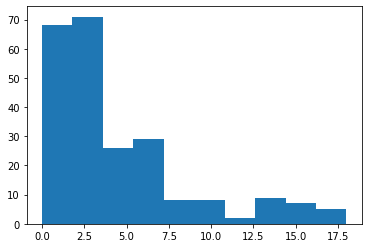


Summary Statistics
                0
count  233.000000
mean     4.330472
std      4.248506
min      0.000000
25%      1.000000
50%      2.000000
75%      6.000000
max     18.000000


IS_PALINDROME
Number of Attempts


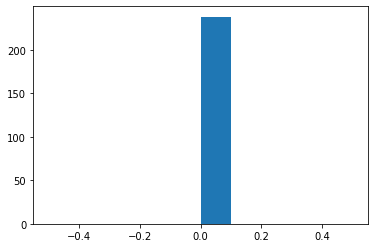


Summary Statistics
           0
count  238.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MISSING_DIGITS
Number of Attempts


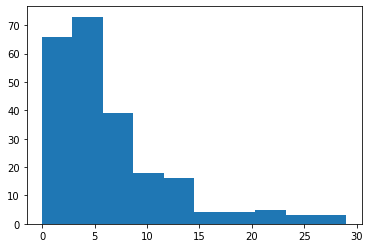


Summary Statistics
                0
count  231.000000
mean     6.168831
std      5.907407
min      0.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     29.000000

ADVANCED

MOVE_STACK
Number of Attempts


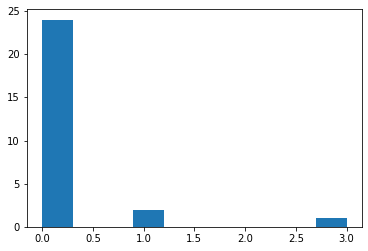


Summary Statistics
               0
count  27.000000
mean    0.185185
std     0.622466
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


GET_NEXT_COIN
Number of Attempts


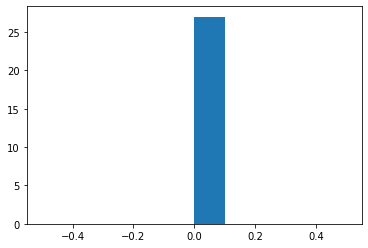


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COUNT_COINS
Number of Attempts


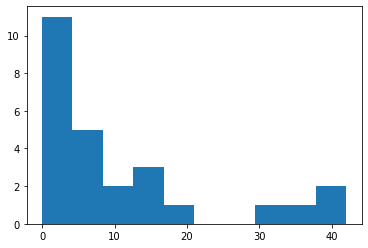


Summary Statistics
               0
count  26.000000
mean   10.576923
std    12.390878
min     0.000000
25%     1.000000
50%     5.500000
75%    14.750000
max    42.000000


PINGPONG
Number of Attempts


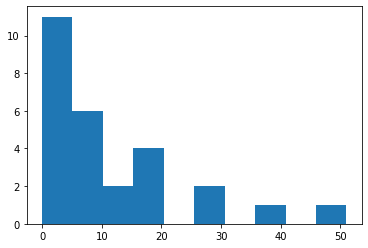


Summary Statistics
               0
count  27.000000
mean   11.629630
std    12.425619
min     0.000000
25%     3.500000
50%     8.000000
75%    17.500000
max    51.000000


MAKE_ANONYMOUS_FACTORIAL
Number of Attempts


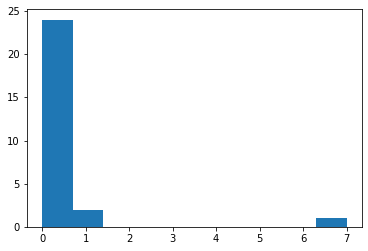


Summary Statistics
               0
count  27.000000
mean    0.333333
std     1.358732
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     7.000000


MARIO_NUMBER
Number of Attempts


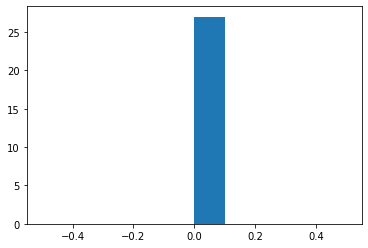


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


HAS_SUM
Number of Attempts


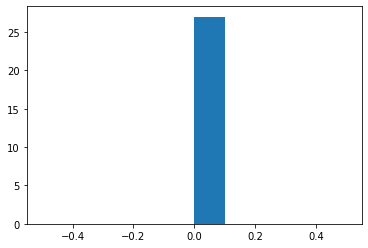


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


NUM_EIGHTS
Number of Attempts


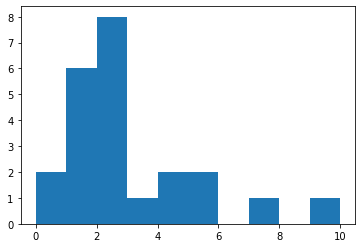


Summary Statistics
               0
count  23.000000
mean    2.608696
std     2.349838
min     0.000000
25%     1.000000
50%     2.000000
75%     3.500000
max    10.000000


IS_PALINDROME
Number of Attempts


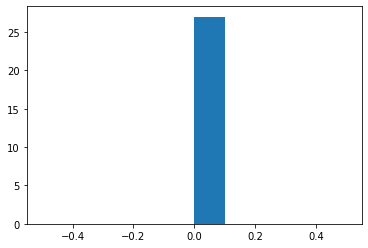


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MISSING_DIGITS
Number of Attempts


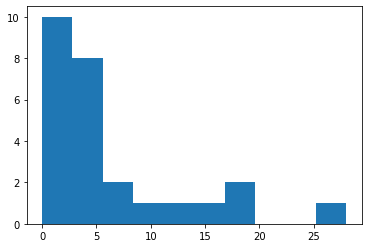


Summary Statistics
               0
count  26.000000
mean    6.192308
std     6.847009
min     0.000000
25%     2.000000
50%     4.000000
75%     7.750000
max    28.000000



In [166]:
num_attempts_graphs_by_level('hw03.csv')


Generating num attempts for hw03.csv, for people in NO_LANGUAGES_BEFORE, using ['num_eights', 'count_coins', 'has_sum', 'is_palindrome', 'get_next_coin', 'move_stack', 'missing_digits', 'mario_number', 'make_anonymous_factorial', 'pingpong']

NUM_EIGHTS
Number of Attempts


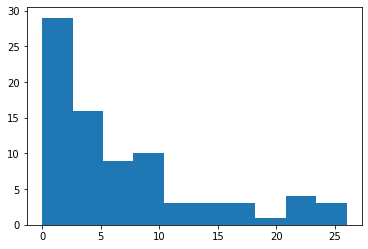


Summary Statistics
               0
count  81.000000
mean    6.851852
std     6.802777
min     0.000000
25%     2.000000
50%     4.000000
75%    10.000000
max    26.000000


COUNT_COINS
Number of Attempts


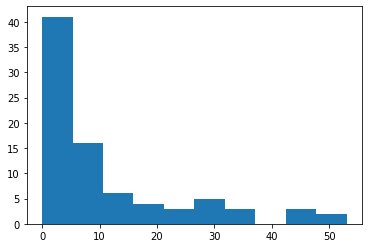


Summary Statistics
               0
count  83.000000
mean   11.144578
std    13.080550
min     0.000000
25%     2.000000
50%     6.000000
75%    15.000000
max    53.000000


HAS_SUM
Number of Attempts


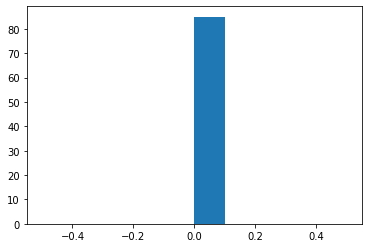


Summary Statistics
          0
count  85.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


IS_PALINDROME
Number of Attempts


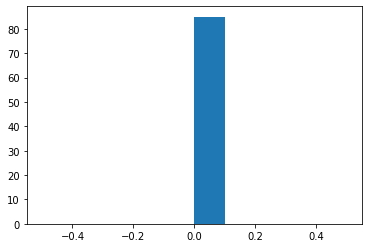


Summary Statistics
          0
count  85.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


GET_NEXT_COIN
Number of Attempts


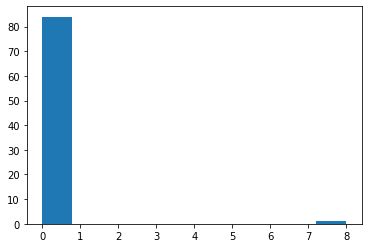


Summary Statistics
               0
count  85.000000
mean    0.094118
std     0.867722
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     8.000000


MOVE_STACK
Number of Attempts


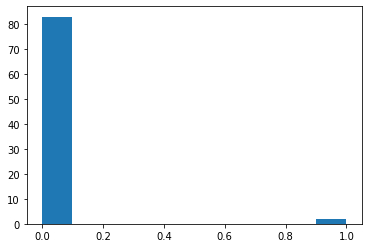


Summary Statistics
               0
count  85.000000
mean    0.023529
std     0.152477
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


MISSING_DIGITS
Number of Attempts


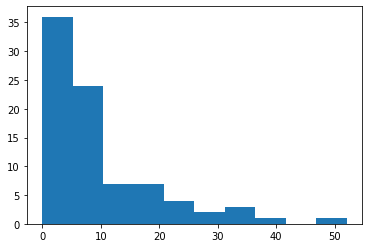


Summary Statistics
               0
count  85.000000
mean    9.800000
std    10.364546
min     0.000000
25%     2.000000
50%     7.000000
75%    13.000000
max    52.000000


MARIO_NUMBER
Number of Attempts


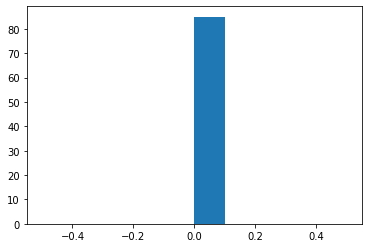


Summary Statistics
          0
count  85.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MAKE_ANONYMOUS_FACTORIAL
Number of Attempts


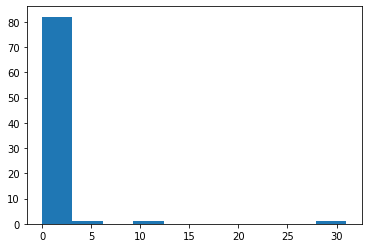


Summary Statistics
               0
count  85.000000
mean    0.564706
std     3.623492
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    31.000000


PINGPONG
Number of Attempts


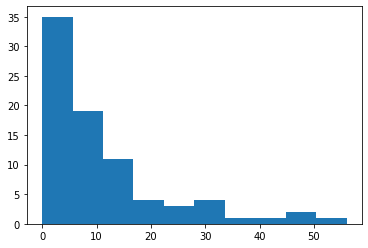


Summary Statistics
               0
count  81.000000
mean   11.185185
std    11.933264
min     0.000000
25%     3.000000
50%     6.000000
75%    14.000000
max    56.000000



In [75]:
num_attempts_graphs_using_df('hw03.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 04

Generating num attempts for hw04-sp22.csv, using ['Food', 'remove_odd_indices', 'Soup', 'SmartFridge', 'merge', 'VendingMachine.vend', 'VendingMachine', 'Boss', 'Mint', 'Coin.worth', 'Coin']

FOOD
Number of Attempts


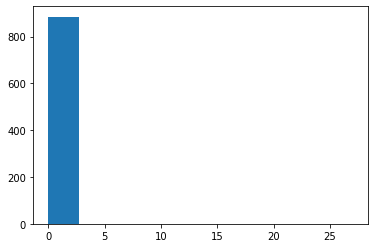


Summary Statistics
                0
count  886.000000
mean     0.031603
std      0.907667
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     27.000000


REMOVE_ODD_INDICES
Number of Attempts


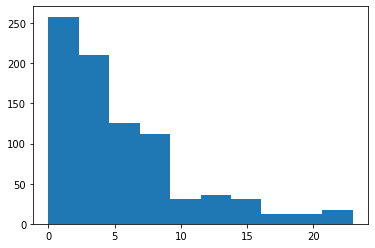


Summary Statistics
                0
count  845.000000
mean     5.621302
std      4.861935
min      0.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     23.000000


SOUP
Number of Attempts


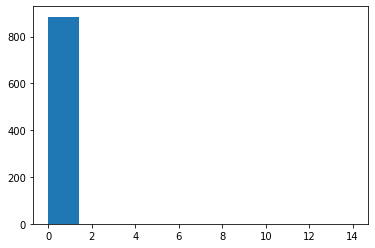


Summary Statistics
               0
count  886.00000
mean     0.01693
std      0.47150
min      0.00000
25%      0.00000
50%      0.00000
75%      0.00000
max     14.00000


SMARTFRIDGE
Number of Attempts


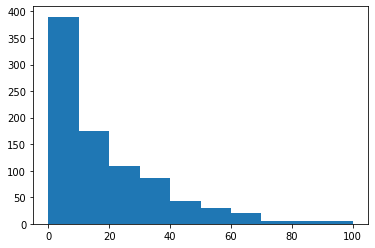


Summary Statistics
                0
count  869.000000
mean    18.246260
std     18.748803
min      0.000000
25%      4.000000
50%     12.000000
75%     27.000000
max    100.000000


MERGE
Number of Attempts


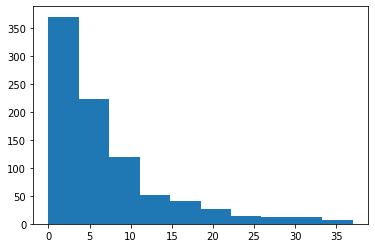


Summary Statistics
                0
count  878.000000
mean     6.917995
std      7.209212
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     37.000000


VENDINGMACHINE.VEND
Number of Attempts


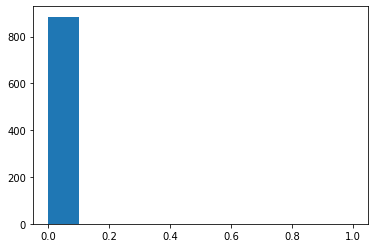


Summary Statistics
                0
count  886.000000
mean     0.001129
std      0.033596
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


VENDINGMACHINE
Number of Attempts



Summary Statistics
                0
count  881.000000
mean    10.499432
std      9.501809
min      0.000000
25%      4.000000
50%      8.000000
75%     14.000000
max     56.000000


BOSS
Number of Attempts



Summary Statistics
                0
count  886.000000
mean     0.006772
std      0.201574
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


MINT
Number of Attempts



Summary Statistics
                0
count  864.000000
mean     9.568287
std     10.465192
min      0.000000
25%      2.000000
50%      6.000000
75%     13.000000
max     55.000000


COIN.WORTH
Number of Attempts


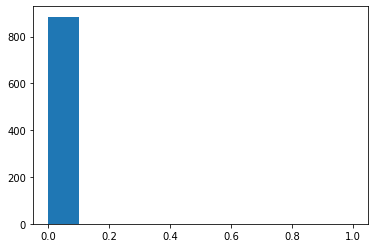


Summary Statistics
                0
count  886.000000
mean     0.001129
std      0.033596
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


COIN
Number of Attempts


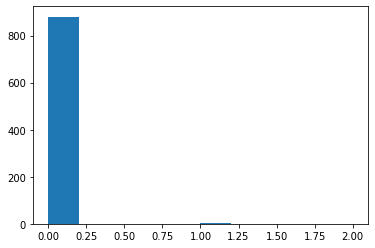


Summary Statistics
                0
count  886.000000
mean     0.007901
std      0.100534
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000



In [167]:
num_attempts_graphs('hw04-sp22.csv')


Generating num attempts for hw04-sp22.csv, stratified by level, using ['Food', 'remove_odd_indices', 'Soup', 'SmartFridge', 'merge', 'VendingMachine.vend', 'VendingMachine', 'Boss', 'Mint', 'Coin.worth', 'Coin']
BEGINNER

FOOD
Number of Attempts


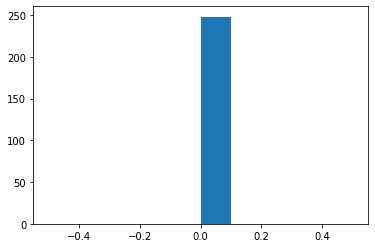


Summary Statistics
           0
count  248.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


REMOVE_ODD_INDICES
Number of Attempts


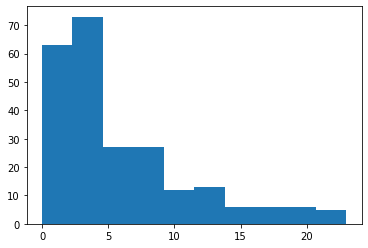


Summary Statistics
                0
count  238.000000
mean     5.962185
std      5.244511
min      0.000000
25%      2.000000
50%      4.000000
75%      8.000000
max     23.000000


SOUP
Number of Attempts


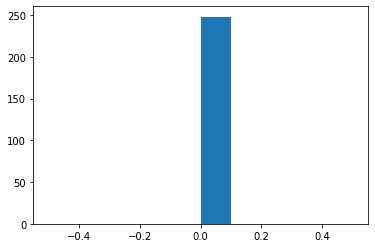


Summary Statistics
           0
count  248.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SMARTFRIDGE
Number of Attempts


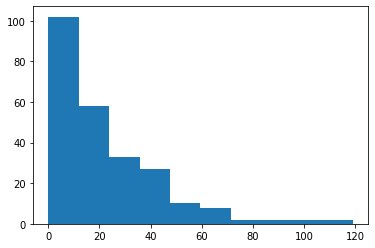


Summary Statistics
                0
count  246.000000
mean    21.967480
std     21.784261
min      0.000000
25%      6.000000
50%     15.500000
75%     31.750000
max    119.000000


MERGE
Number of Attempts


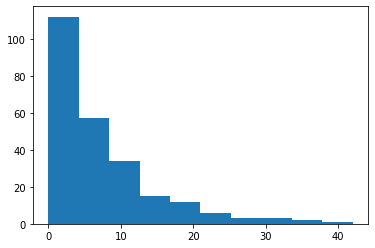


Summary Statistics
                0
count  245.000000
mean     7.106122
std      7.401052
min      0.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     42.000000


VENDINGMACHINE.VEND
Number of Attempts


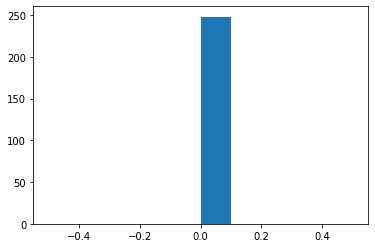


Summary Statistics
           0
count  248.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


VENDINGMACHINE
Number of Attempts


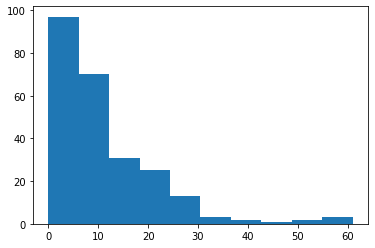


Summary Statistics
                0
count  247.000000
mean    11.012146
std     10.792380
min      0.000000
25%      3.000000
50%      8.000000
75%     14.000000
max     61.000000


BOSS
Number of Attempts


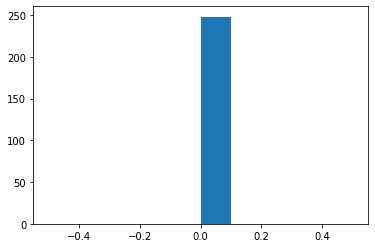


Summary Statistics
           0
count  248.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MINT
Number of Attempts


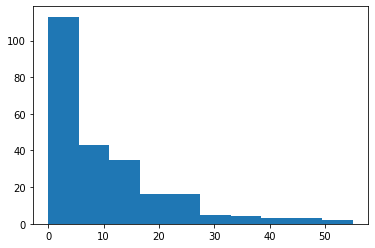


Summary Statistics
                0
count  240.000000
mean     9.841667
std     10.817231
min      0.000000
25%      2.000000
50%      6.000000
75%     14.250000
max     55.000000


COIN.WORTH
Number of Attempts


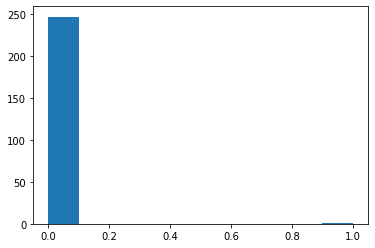


Summary Statistics
                0
count  248.000000
mean     0.004032
std      0.063500
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


COIN
Number of Attempts


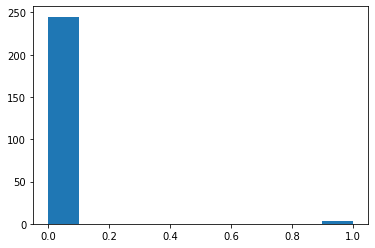


Summary Statistics
                0
count  248.000000
mean     0.012097
std      0.109539
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

INTERMEDIATE

FOOD
Number of Attempts


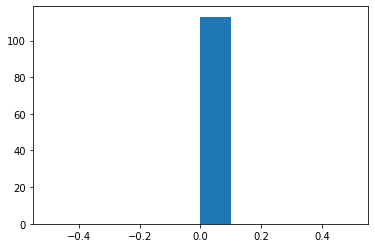


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


REMOVE_ODD_INDICES
Number of Attempts


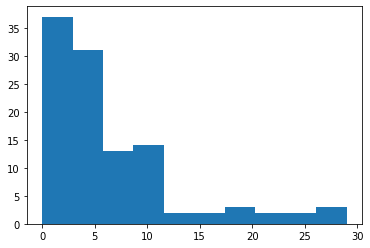


Summary Statistics
                0
count  109.000000
mean     6.376147
std      6.543004
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     29.000000


SOUP
Number of Attempts


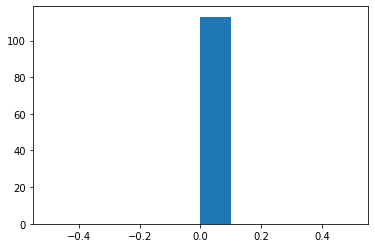


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


SMARTFRIDGE
Number of Attempts


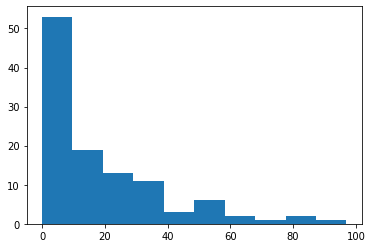


Summary Statistics
                0
count  111.000000
mean    18.981982
std     20.191799
min      0.000000
25%      4.000000
50%     12.000000
75%     28.000000
max     97.000000


MERGE
Number of Attempts


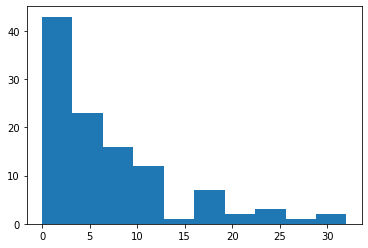


Summary Statistics
                0
count  110.000000
mean     7.209091
std      6.872489
min      0.000000
25%      2.250000
50%      5.000000
75%      9.750000
max     32.000000


VENDINGMACHINE.VEND
Number of Attempts


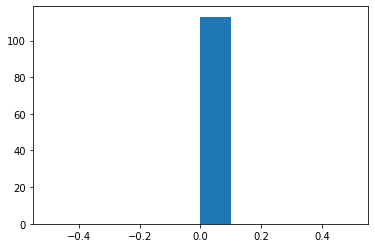


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


VENDINGMACHINE
Number of Attempts


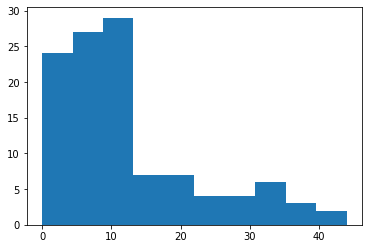


Summary Statistics
                0
count  113.000000
mean    12.150442
std     10.264555
min      0.000000
25%      5.000000
50%      9.000000
75%     17.000000
max     44.000000


BOSS
Number of Attempts


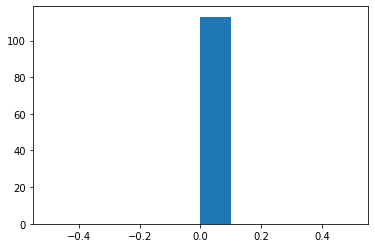


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


MINT
Number of Attempts


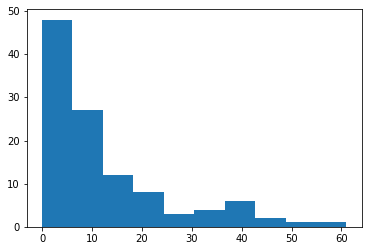


Summary Statistics
                0
count  112.000000
mean    12.285714
std     13.093172
min      0.000000
25%      3.000000
50%      8.000000
75%     16.000000
max     61.000000


COIN.WORTH
Number of Attempts


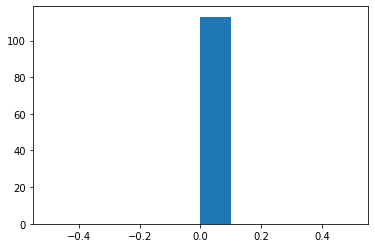


Summary Statistics
           0
count  113.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


COIN
Number of Attempts


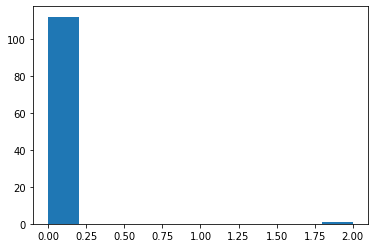


Summary Statistics
                0
count  113.000000
mean     0.017699
std      0.188144
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000

ADVANCED

FOOD
Number of Attempts


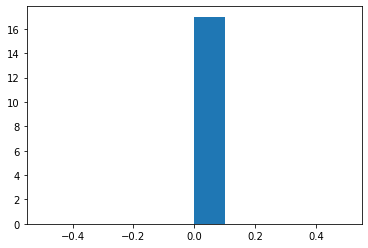


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


REMOVE_ODD_INDICES
Number of Attempts



Summary Statistics
               0
count  15.000000
mean    3.933333
std     2.963267
min     1.000000
25%     2.000000
50%     3.000000
75%     5.000000
max    10.000000


SOUP
Number of Attempts


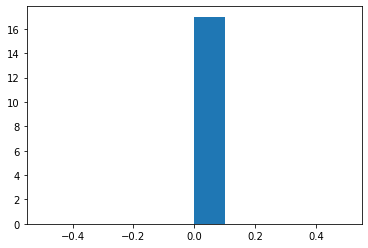


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SMARTFRIDGE
Number of Attempts


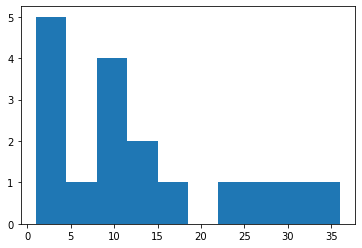


Summary Statistics
               0
count  17.000000
mean   12.529412
std    10.259859
min     1.000000
25%     4.000000
50%    10.000000
75%    15.000000
max    36.000000


MERGE
Number of Attempts


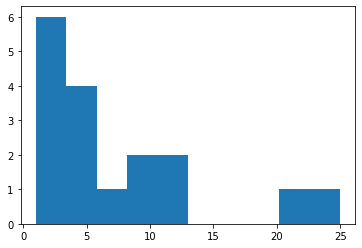


Summary Statistics
               0
count  17.000000
mean    7.117647
std     6.954157
min     1.000000
25%     2.000000
50%     5.000000
75%     9.000000
max    25.000000


VENDINGMACHINE.VEND
Number of Attempts


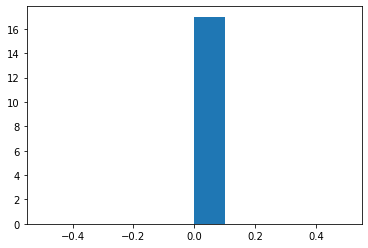


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


VENDINGMACHINE
Number of Attempts


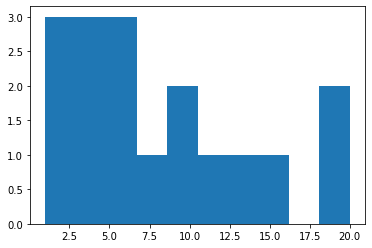


Summary Statistics
               0
count  17.000000
mean    8.117647
std     5.935932
min     1.000000
25%     4.000000
50%     6.000000
75%    11.000000
max    20.000000


BOSS
Number of Attempts


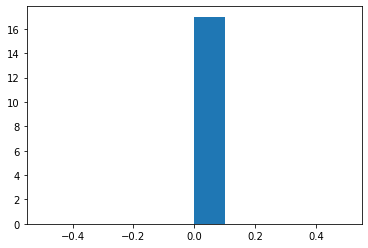


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


MINT
Number of Attempts



Summary Statistics
               0
count  17.000000
mean   11.235294
std    10.096592
min     1.000000
25%     4.000000
50%     8.000000
75%    17.000000
max    37.000000


COIN.WORTH
Number of Attempts


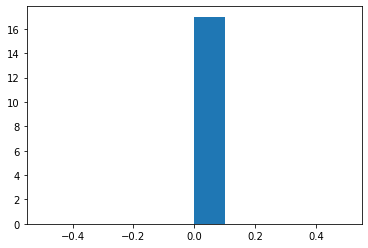


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COIN
Number of Attempts


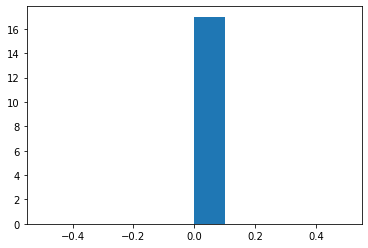


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [168]:
num_attempts_graphs_by_level('hw04-sp22.csv')

Generating num attempts for hw04.csv, using ['balanced', 'div_interval', 'quadratic', 'preorder', 'sub_interval', 'check_par', 'branches', 'planet', 'multiple_references_explanation', 'total_weight', 'mul_interval', 'print_tree', 'replace_leaf', 'interval', 'totals_tree', 'has_path', 'size', 'replace_thor_at_leaf']

BALANCED
Number of Attempts


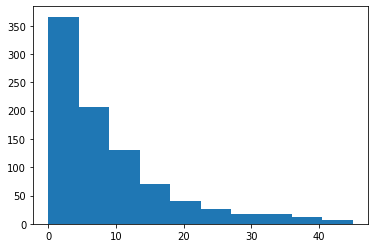


Summary Statistics
                0
count  895.000000
mean     8.832402
std      8.835741
min      0.000000
25%      3.000000
50%      6.000000
75%     12.000000
max     45.000000


DIV_INTERVAL
Number of Attempts


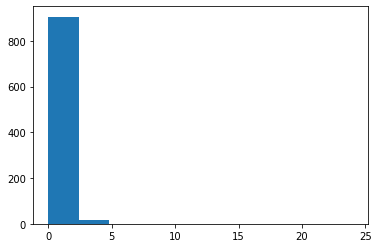


Summary Statistics
                0
count  924.000000
mean     0.151515
std      1.016008
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     24.000000


QUADRATIC
Number of Attempts


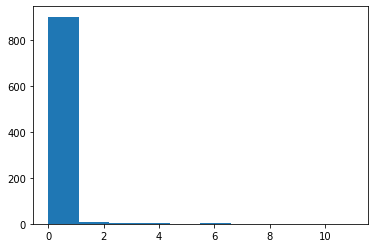


Summary Statistics
                0
count  924.000000
mean     0.104978
std      0.681609
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


PREORDER
Number of Attempts


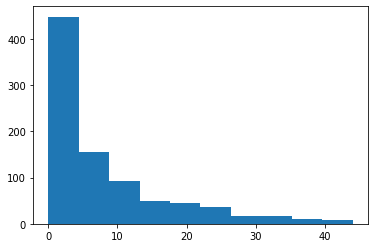


Summary Statistics
                0
count  882.000000
mean     7.938776
std      9.238220
min      0.000000
25%      1.000000
50%      4.000000
75%     11.000000
max     44.000000


SUB_INTERVAL
Number of Attempts



Summary Statistics
                0
count  924.000000
mean     0.150433
std      0.702950
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     10.000000


CHECK_PAR
Number of Attempts



Summary Statistics
                0
count  924.000000
mean     0.147186
std      0.878282
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     13.000000


BRANCHES
Number of Attempts



Summary Statistics
                0
count  924.000000
mean     0.002165
std      0.046499
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


PLANET
Number of Attempts


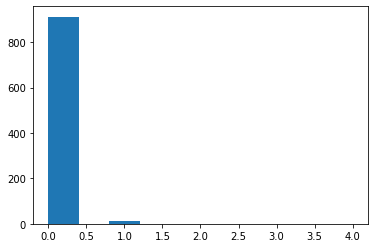


Summary Statistics
                0
count  924.000000
mean     0.016234
std      0.170260
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


MULTIPLE_REFERENCES_EXPLANATION
Number of Attempts


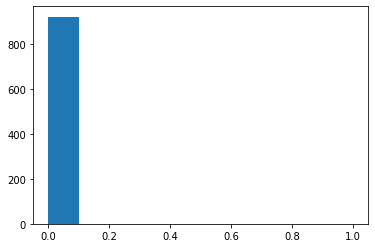


Summary Statistics
                0
count  924.000000
mean     0.001082
std      0.032898
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


TOTAL_WEIGHT
Number of Attempts



Summary Statistics
                0
count  883.000000
mean     2.551529
std      2.121696
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


MUL_INTERVAL
Number of Attempts


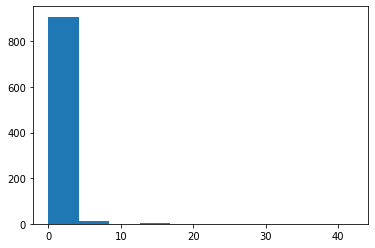


Summary Statistics
                0
count  924.000000
mean     0.334416
std      1.868269
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     42.000000


PRINT_TREE
Number of Attempts


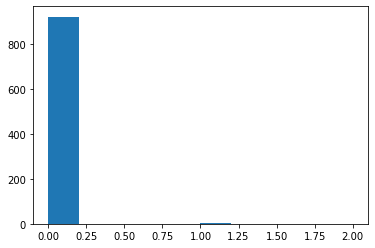


Summary Statistics
                0
count  924.000000
mean     0.005411
std      0.086918
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPLACE_LEAF
Number of Attempts



Summary Statistics
                0
count  924.000000
mean     0.004329
std      0.131590
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


INTERVAL
Number of Attempts


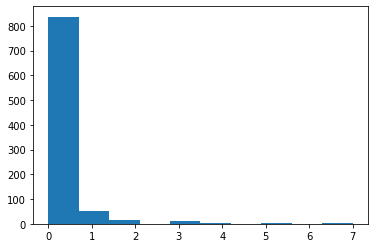


Summary Statistics
                0
count  924.000000
mean     0.176407
std      0.692199
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


TOTALS_TREE
Number of Attempts


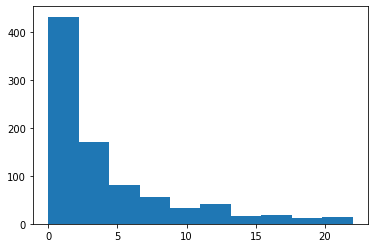


Summary Statistics
                0
count  879.000000
mean     4.416382
std      4.750207
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


HAS_PATH
Number of Attempts



Summary Statistics
                0
count  907.000000
mean    11.910695
std     13.193574
min      0.000000
25%      2.000000
50%      7.000000
75%     17.000000
max     66.000000


SIZE
Number of Attempts


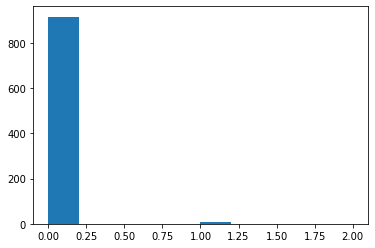


Summary Statistics
                0
count  924.000000
mean     0.010823
std      0.113507
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPLACE_THOR_AT_LEAF
Number of Attempts


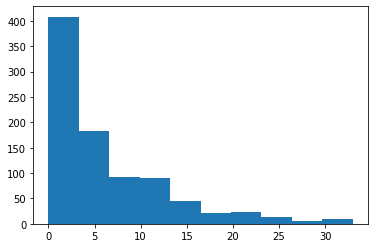


Summary Statistics
                0
count  891.000000
mean     6.295174
std      6.460195
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     33.000000



In [169]:
num_attempts_graphs('hw04.csv')


Generating num attempts for hw04.csv, stratified by level, using ['balanced', 'div_interval', 'quadratic', 'preorder', 'sub_interval', 'check_par', 'branches', 'planet', 'multiple_references_explanation', 'total_weight', 'mul_interval', 'print_tree', 'replace_leaf', 'interval', 'totals_tree', 'has_path', 'size', 'replace_thor_at_leaf']
BEGINNER

BALANCED
Number of Attempts



Summary Statistics
                0
count  524.000000
mean    10.019084
std     10.307862
min      0.000000
25%      3.000000
50%      7.000000
75%     14.000000
max     54.000000


DIV_INTERVAL
Number of Attempts


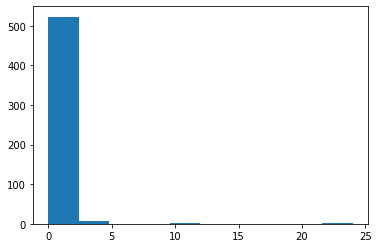


Summary Statistics
                0
count  533.000000
mean     0.150094
std      1.229335
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     24.000000


QUADRATIC
Number of Attempts



Summary Statistics
                0
count  533.000000
mean     0.067542
std      0.603200
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000


PREORDER
Number of Attempts


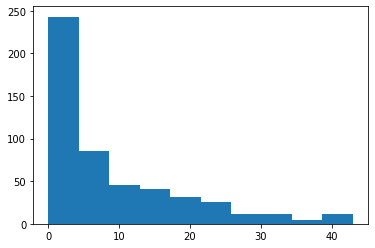


Summary Statistics
                0
count  511.000000
mean     8.812133
std      9.739546
min      0.000000
25%      2.000000
50%      5.000000
75%     14.000000
max     43.000000


SUB_INTERVAL
Number of Attempts



Summary Statistics
                0
count  533.000000
mean     0.114447
std      0.666066
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     10.000000


CHECK_PAR
Number of Attempts


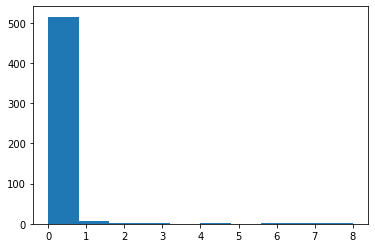


Summary Statistics
                0
count  533.000000
mean     0.101313
std      0.686236
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      8.000000


BRANCHES
Number of Attempts



Summary Statistics
                0
count  533.000000
mean     0.003752
std      0.061199
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


PLANET
Number of Attempts


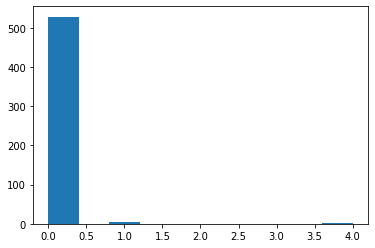


Summary Statistics
                0
count  533.000000
mean     0.015009
std      0.193309
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


MULTIPLE_REFERENCES_EXPLANATION
Number of Attempts


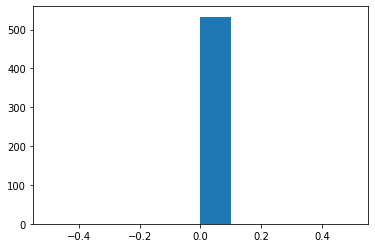


Summary Statistics
           0
count  533.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TOTAL_WEIGHT
Number of Attempts


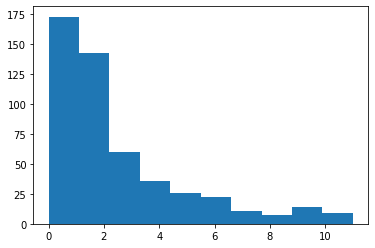


Summary Statistics
                0
count  501.000000
mean     2.758483
std      2.262643
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


MUL_INTERVAL
Number of Attempts


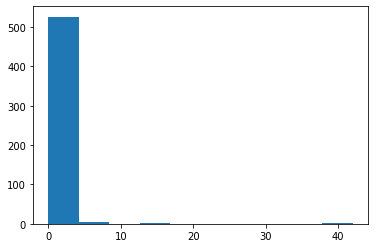


Summary Statistics
                0
count  533.000000
mean     0.290807
std      2.091841
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     42.000000


PRINT_TREE
Number of Attempts


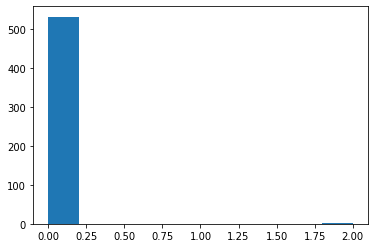


Summary Statistics
                0
count  533.000000
mean     0.003752
std      0.086630
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPLACE_LEAF
Number of Attempts


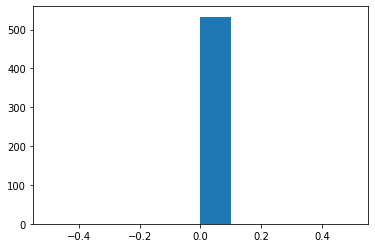


Summary Statistics
           0
count  533.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INTERVAL
Number of Attempts


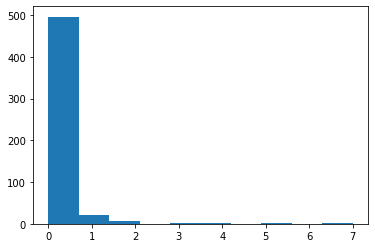


Summary Statistics
                0
count  533.000000
mean     0.136961
std      0.658949
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


TOTALS_TREE
Number of Attempts


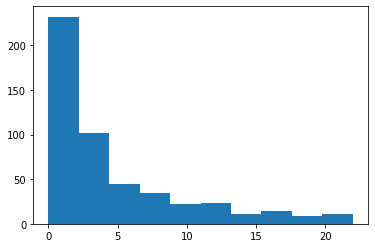


Summary Statistics
                0
count  503.000000
mean     4.781312
std      5.039277
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


HAS_PATH
Number of Attempts


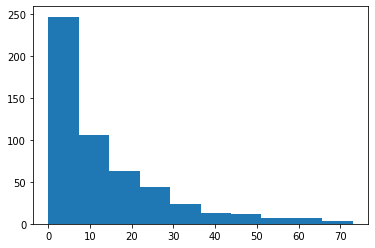


Summary Statistics
                0
count  526.000000
mean    13.260456
std     14.313318
min      0.000000
25%      3.000000
50%      8.500000
75%     19.000000
max     73.000000


SIZE
Number of Attempts



Summary Statistics
                0
count  533.000000
mean     0.007505
std      0.105933
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


REPLACE_THOR_AT_LEAF
Number of Attempts


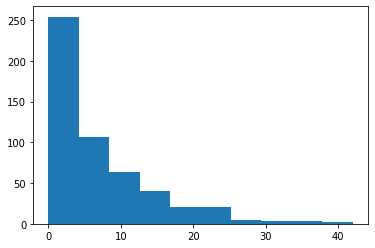


Summary Statistics
                0
count  520.000000
mean     7.053846
std      7.311734
min      0.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     42.000000

INTERMEDIATE

BALANCED
Number of Attempts



Summary Statistics
                0
count  221.000000
mean     8.135747
std      7.556432
min      0.000000
25%      3.000000
50%      6.000000
75%     11.000000
max     39.000000


DIV_INTERVAL
Number of Attempts


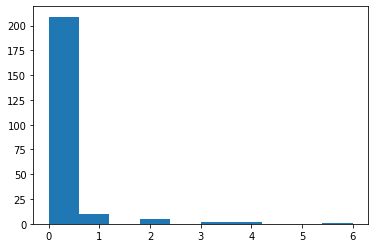


Summary Statistics
                0
count  229.000000
mean     0.174672
std      0.691468
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


QUADRATIC
Number of Attempts


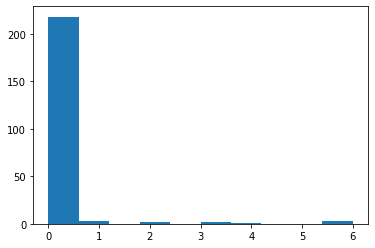


Summary Statistics
                0
count  229.000000
mean     0.152838
std      0.804730
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


PREORDER
Number of Attempts


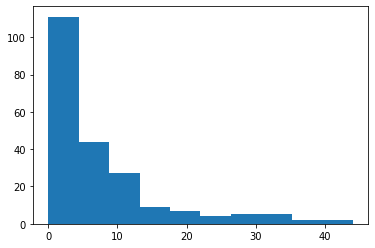


Summary Statistics
                0
count  216.000000
mean     7.296296
std      9.013436
min      0.000000
25%      1.000000
50%      4.000000
75%     10.000000
max     44.000000


SUB_INTERVAL
Number of Attempts


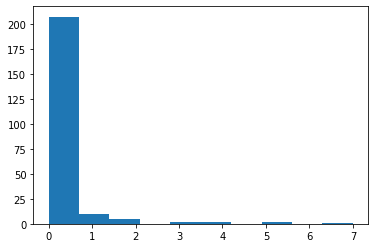


Summary Statistics
                0
count  229.000000
mean     0.222707
std      0.857480
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      7.000000


CHECK_PAR
Number of Attempts


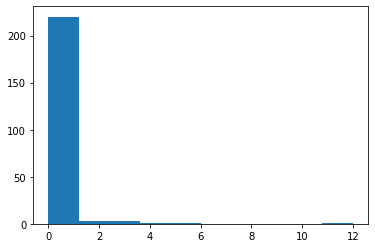


Summary Statistics
                0
count  229.000000
mean     0.179039
std      0.985997
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     12.000000


BRANCHES
Number of Attempts


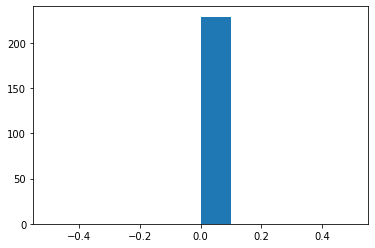


Summary Statistics
           0
count  229.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


PLANET
Number of Attempts


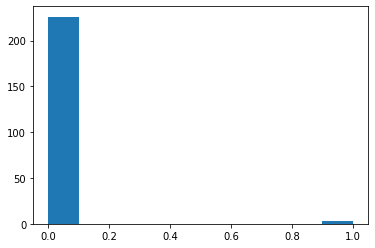


Summary Statistics
                0
count  229.000000
mean     0.013100
std      0.113954
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


MULTIPLE_REFERENCES_EXPLANATION
Number of Attempts


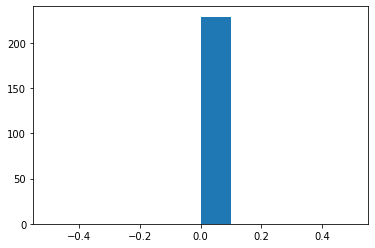


Summary Statistics
           0
count  229.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


TOTAL_WEIGHT
Number of Attempts



Summary Statistics
                0
count  225.000000
mean     2.288889
std      1.918219
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     11.000000


MUL_INTERVAL
Number of Attempts


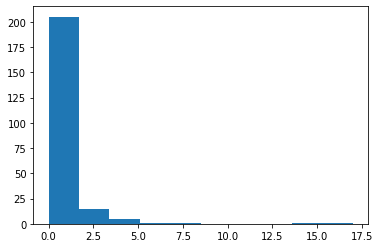


Summary Statistics
                0
count  229.000000
mean     0.449782
std      1.763012
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     17.000000


PRINT_TREE
Number of Attempts



Summary Statistics
                0
count  229.000000
mean     0.004367
std      0.066082
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


REPLACE_LEAF
Number of Attempts


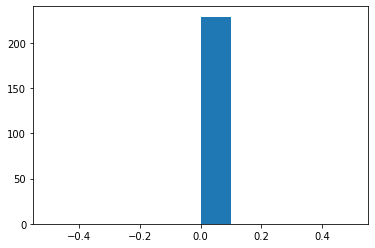


Summary Statistics
           0
count  229.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INTERVAL
Number of Attempts


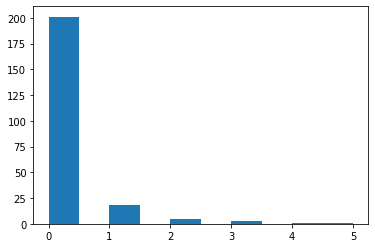


Summary Statistics
                0
count  229.000000
mean     0.200873
std      0.651449
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      5.000000


TOTALS_TREE
Number of Attempts



Summary Statistics
                0
count  203.000000
mean     2.827586
std      2.597567
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


HAS_PATH
Number of Attempts



Summary Statistics
                0
count  224.000000
mean    11.607143
std     13.002488
min      0.000000
25%      2.000000
50%      7.000000
75%     17.000000
max     66.000000


SIZE
Number of Attempts


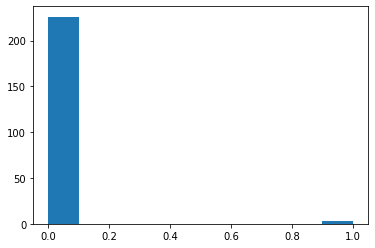


Summary Statistics
                0
count  229.000000
mean     0.013100
std      0.113954
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


REPLACE_THOR_AT_LEAF
Number of Attempts



Summary Statistics
                0
count  217.000000
mean     5.488479
std      5.591918
min      0.000000
25%      2.000000
50%      4.000000
75%      7.000000
max     32.000000

ADVANCED

BALANCED
Number of Attempts


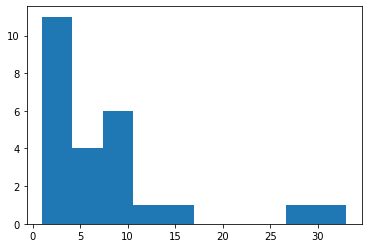


Summary Statistics
               0
count  25.000000
mean    7.480000
std     7.885218
min     1.000000
25%     2.000000
50%     6.000000
75%     9.000000
max    33.000000


DIV_INTERVAL
Number of Attempts


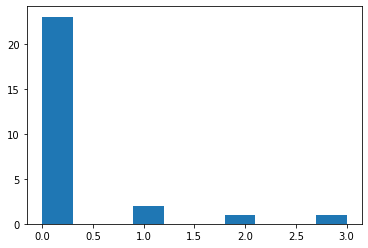


Summary Statistics
               0
count  27.000000
mean    0.259259
std     0.712125
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


QUADRATIC
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.296296
std     0.775332
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


PREORDER
Number of Attempts



Summary Statistics
               0
count  24.000000
mean    5.125000
std     5.914702
min     0.000000
25%     2.000000
50%     3.000000
75%     6.000000
max    22.000000


SUB_INTERVAL
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.148148
std     0.362014
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


CHECK_PAR
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.777778
std     2.591901
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max    13.000000


BRANCHES
Number of Attempts


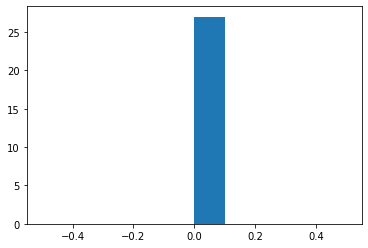


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


PLANET
Number of Attempts


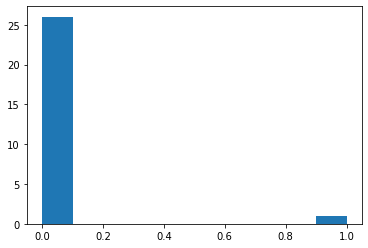


Summary Statistics
               0
count  27.000000
mean    0.037037
std     0.192450
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


MULTIPLE_REFERENCES_EXPLANATION
Number of Attempts


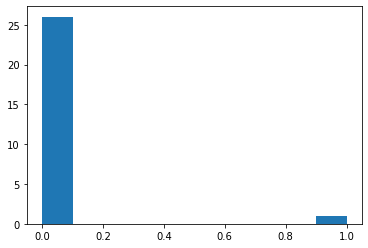


Summary Statistics
               0
count  27.000000
mean    0.037037
std     0.192450
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


TOTAL_WEIGHT
Number of Attempts



Summary Statistics
               0
count  26.000000
mean    2.538462
std     2.370329
min     1.000000
25%     1.000000
50%     2.000000
75%     3.000000
max    10.000000


MUL_INTERVAL
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.296296
std     0.775332
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000


PRINT_TREE
Number of Attempts


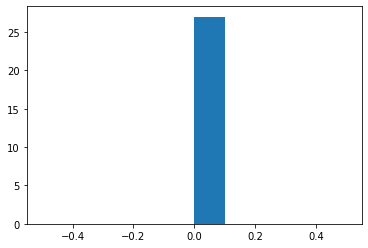


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


REPLACE_LEAF
Number of Attempts


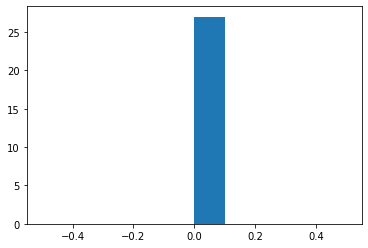


Summary Statistics
          0
count  27.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


INTERVAL
Number of Attempts



Summary Statistics
               0
count  27.000000
mean    0.407407
std     1.083416
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     4.000000


TOTALS_TREE
Number of Attempts


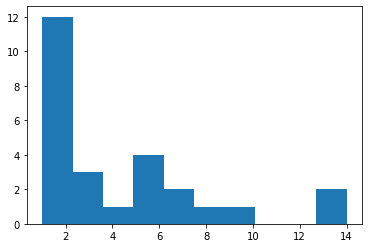


Summary Statistics
               0
count  26.000000
mean    4.230769
std     3.744945
min     1.000000
25%     1.000000
50%     3.000000
75%     6.000000
max    14.000000


HAS_PATH
Number of Attempts


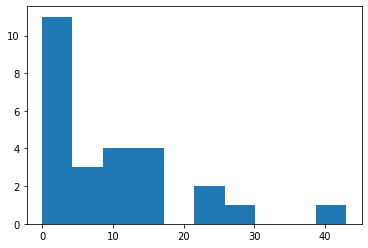


Summary Statistics
               0
count  26.000000
mean    9.846154
std    10.410350
min     0.000000
25%     2.000000
50%     6.500000
75%    13.000000
max    43.000000


SIZE
Number of Attempts


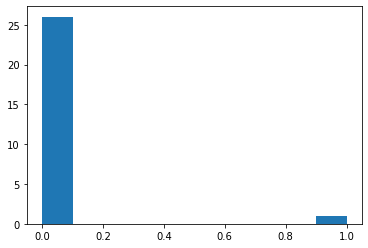


Summary Statistics
               0
count  27.000000
mean    0.037037
std     0.192450
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


REPLACE_THOR_AT_LEAF
Number of Attempts


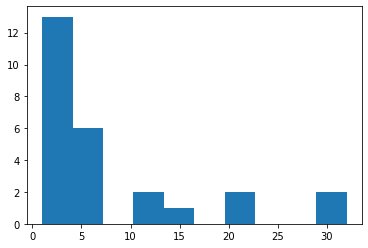


Summary Statistics
               0
count  26.000000
mean    7.961538
std     8.604561
min     1.000000
25%     3.000000
50%     4.500000
75%     9.750000
max    32.000000



In [170]:
num_attempts_graphs_by_level('hw04.csv')

# HW 05

Generating num attempts for hw05-sp22.csv, using ['reverse_lnk', 'duplicate_link', 'flatten_link', 'midsem_survey', 'has_path', 'deep_map_mut', 'chain', 'none_touching']

REVERSE_LNK
Number of Attempts



Summary Statistics
                0
count  844.000000
mean     0.001185
std      0.034421
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


DUPLICATE_LINK
Number of Attempts



Summary Statistics
                0
count  835.000000
mean    11.226347
std     12.859517
min      0.000000
25%      2.000000
50%      7.000000
75%     15.000000
max     66.000000


FLATTEN_LINK
Number of Attempts


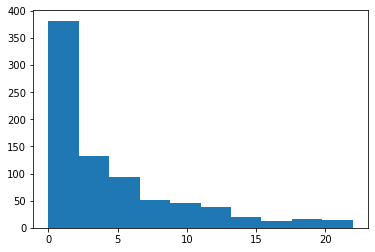


Summary Statistics
                0
count  807.000000
mean     4.690211
std      4.855806
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


MIDSEM_SURVEY
Number of Attempts


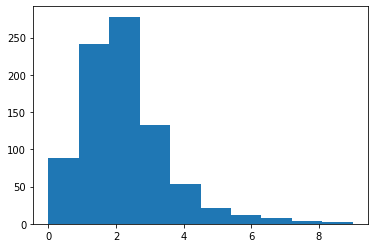


Summary Statistics
               0
count  843.00000
mean     2.01898
std      1.46928
min      0.00000
25%      1.00000
50%      2.00000
75%      3.00000
max      9.00000


HAS_PATH
Number of Attempts



Summary Statistics
                0
count  829.000000
mean    15.125452
std     16.434064
min      0.000000
25%      3.000000
50%      9.000000
75%     21.000000
max     87.000000


DEEP_MAP_MUT
Number of Attempts



Summary Statistics
                0
count  818.000000
mean     6.798289
std      7.033207
min      0.000000
25%      2.000000
50%      4.000000
75%     10.000000
max     33.000000


CHAIN
Number of Attempts


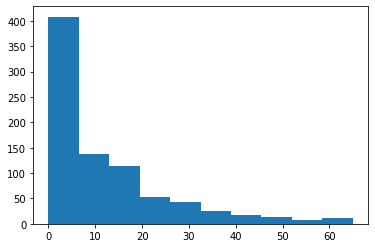


Summary Statistics
                0
count  829.000000
mean    11.969843
std     13.462519
min      0.000000
25%      2.000000
50%      7.000000
75%     17.000000
max     65.000000


NONE_TOUCHING
Number of Attempts



Summary Statistics
                0
count  844.000000
mean     0.014218
std      0.380156
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     11.000000



In [76]:
num_attempts_graphs('hw05-sp22.csv')


Generating num attempts for hw05-sp22.csv, stratified by level, using ['reverse_lnk', 'duplicate_link', 'flatten_link', 'midsem_survey', 'has_path', 'deep_map_mut', 'chain', 'none_touching']
BEGINNER

REVERSE_LNK
Number of Attempts


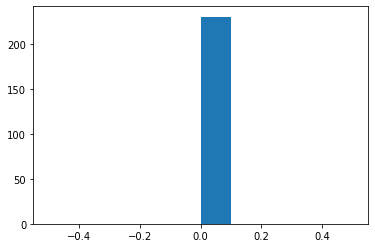


Summary Statistics
           0
count  230.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


DUPLICATE_LINK
Number of Attempts



Summary Statistics
                0
count  228.000000
mean    12.732456
std     14.353725
min      0.000000
25%      2.750000
50%      8.000000
75%     17.000000
max     63.000000


FLATTEN_LINK
Number of Attempts



Summary Statistics
                0
count  216.000000
mean     4.972222
std      4.845441
min      0.000000
25%      1.000000
50%      3.000000
75%      8.000000
max     21.000000


MIDSEM_SURVEY
Number of Attempts



Summary Statistics
                0
count  230.000000
mean     2.034783
std      1.410692
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max      8.000000


HAS_PATH
Number of Attempts


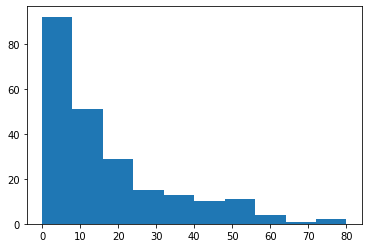


Summary Statistics
                0
count  228.000000
mean    16.491228
std     16.753852
min      0.000000
25%      4.000000
50%     11.000000
75%     23.000000
max     80.000000


DEEP_MAP_MUT
Number of Attempts


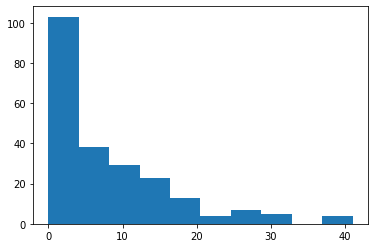


Summary Statistics
                0
count  226.000000
mean     8.194690
std      8.641871
min      0.000000
25%      1.000000
50%      5.000000
75%     12.000000
max     41.000000


CHAIN
Number of Attempts



Summary Statistics
                0
count  226.000000
mean    14.508850
std     15.988396
min      0.000000
25%      2.000000
50%      9.000000
75%     21.000000
max     73.000000


NONE_TOUCHING
Number of Attempts


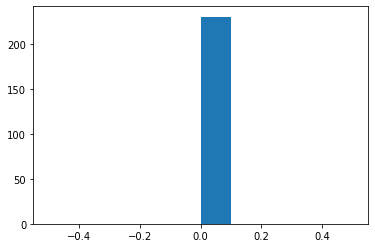


Summary Statistics
           0
count  230.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

INTERMEDIATE

REVERSE_LNK
Number of Attempts



Summary Statistics
           0
count  112.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


DUPLICATE_LINK
Number of Attempts


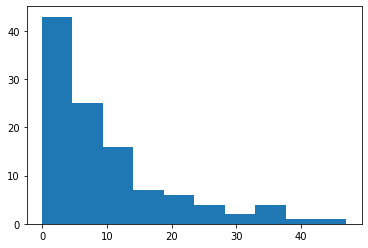


Summary Statistics
                0
count  109.000000
mean     9.853211
std      9.964591
min      0.000000
25%      3.000000
50%      6.000000
75%     14.000000
max     47.000000


FLATTEN_LINK
Number of Attempts


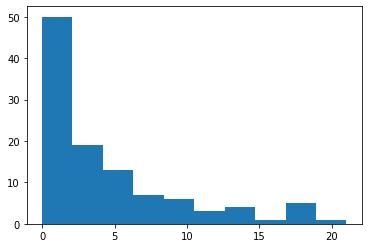


Summary Statistics
                0
count  109.000000
mean     4.825688
std      4.805175
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     21.000000


MIDSEM_SURVEY
Number of Attempts


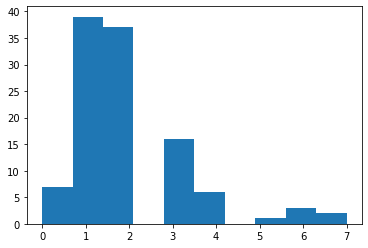


Summary Statistics
                0
count  111.000000
mean     2.000000
std      1.394796
min      0.000000
25%      1.000000
50%      2.000000
75%      2.500000
max      7.000000


HAS_PATH
Number of Attempts


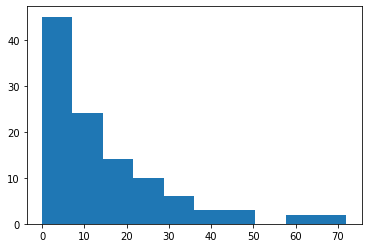


Summary Statistics
                0
count  109.000000
mean    14.605505
std     15.343003
min      0.000000
25%      3.000000
50%     10.000000
75%     21.000000
max     72.000000


DEEP_MAP_MUT
Number of Attempts


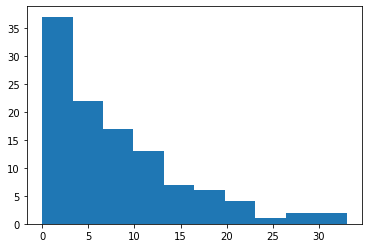


Summary Statistics
                0
count  111.000000
mean     8.081081
std      7.269032
min      0.000000
25%      3.000000
50%      6.000000
75%     11.000000
max     33.000000


CHAIN
Number of Attempts


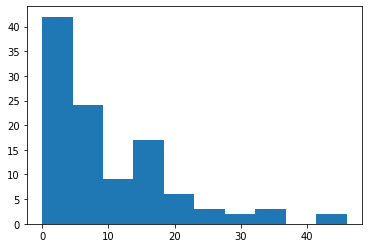


Summary Statistics
                0
count  108.000000
mean     9.981481
std      9.557481
min      0.000000
25%      3.000000
50%      7.000000
75%     15.000000
max     46.000000


NONE_TOUCHING
Number of Attempts


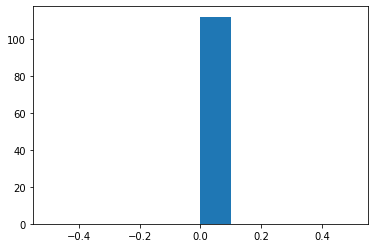


Summary Statistics
           0
count  112.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0

ADVANCED

REVERSE_LNK
Number of Attempts


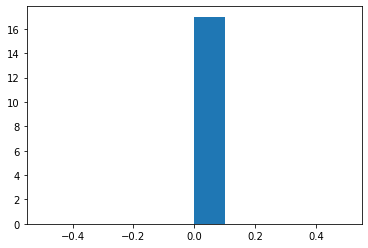


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


DUPLICATE_LINK
Number of Attempts


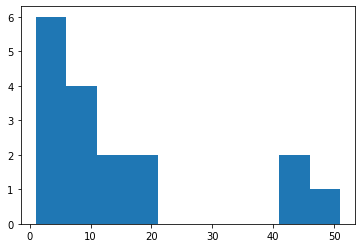


Summary Statistics
               0
count  17.000000
mean   14.647059
std    15.854578
min     1.000000
25%     3.000000
50%     9.000000
75%    17.000000
max    51.000000


FLATTEN_LINK
Number of Attempts



Summary Statistics
               0
count  14.000000
mean    2.642857
std     2.619664
min     1.000000
25%     1.000000
50%     2.000000
75%     2.000000
max    10.000000


MIDSEM_SURVEY
Number of Attempts


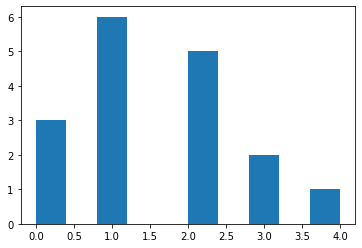


Summary Statistics
               0
count  17.000000
mean    1.529412
std     1.124591
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     4.000000


HAS_PATH
Number of Attempts


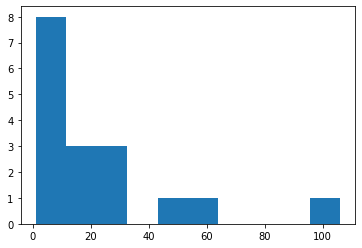


Summary Statistics
                0
count   17.000000
mean    21.941176
std     28.218944
min      1.000000
25%      2.000000
50%     12.000000
75%     26.000000
max    106.000000


DEEP_MAP_MUT
Number of Attempts


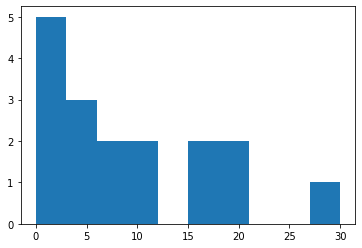


Summary Statistics
               0
count  17.000000
mean    8.882353
std     8.425277
min     0.000000
25%     2.000000
50%     6.000000
75%    15.000000
max    30.000000


CHAIN
Number of Attempts


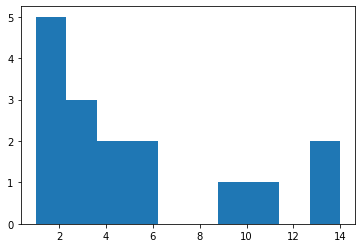


Summary Statistics
               0
count  16.000000
mean    5.125000
std     4.364631
min     1.000000
25%     2.000000
50%     3.500000
75%     6.250000
max    14.000000


NONE_TOUCHING
Number of Attempts


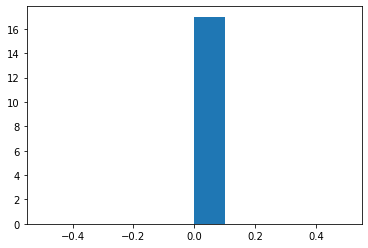


Summary Statistics
          0
count  17.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0



In [95]:
num_attempts_graphs_by_level('hw05-sp22.csv')

Generating num attempts for hw05.csv, using ['Coin', 'VendingMachine.__init__', 'most_significant', 'VendingMachine.add_funds', 'hailstone_tree', 'VendingMachine', 'range_link', 'preorder', 'filter_link', 'generate_preorder', 'Mint', 'Mint.__init__', 'Disc09.scm', 'insert_front', 'map_link', 'store_digits', 'is_bst', 'path_yielder', 'Link', 'add']

COIN
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.001100
std      0.033168
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


VENDINGMACHINE.__INIT__
Number of Attempts


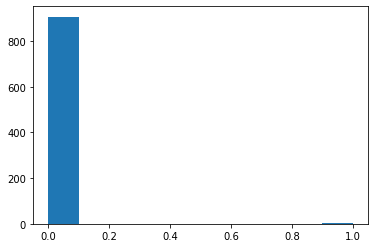


Summary Statistics
                0
count  909.000000
mean     0.002200
std      0.046881
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


MOST_SIGNIFICANT
Number of Attempts


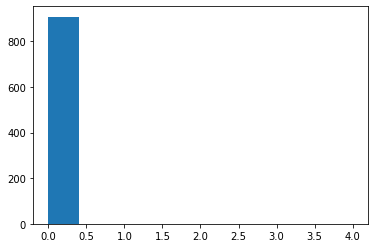


Summary Statistics
                0
count  909.000000
mean     0.004400
std      0.132672
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


VENDINGMACHINE.ADD_FUNDS
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.001100
std      0.033168
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


HAILSTONE_TREE
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.003300
std      0.099504
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


VENDINGMACHINE
Number of Attempts


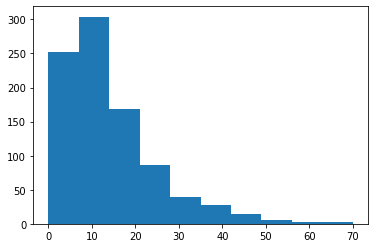


Summary Statistics
                0
count  905.000000
mean    13.517127
std     11.036343
min      0.000000
25%      6.000000
50%     11.000000
75%     18.000000
max     70.000000


RANGE_LINK
Number of Attempts


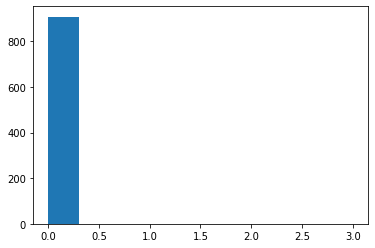


Summary Statistics
                0
count  909.000000
mean     0.003300
std      0.099504
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


PREORDER
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.353135
std      1.558564
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     16.000000


FILTER_LINK
Number of Attempts


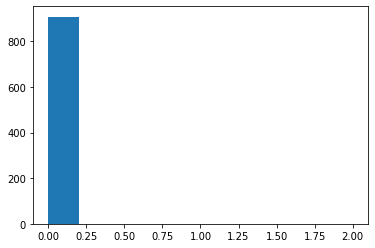


Summary Statistics
                0
count  909.000000
mean     0.002200
std      0.066336
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


GENERATE_PREORDER
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.316832
std      1.593196
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     18.000000


MINT
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.801980
std      3.363505
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     47.000000


MINT.__INIT__
Number of Attempts



Summary Statistics
                0
count  909.000000
mean     0.001100
std      0.033168
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


DISC09.SCM
Number of Attempts


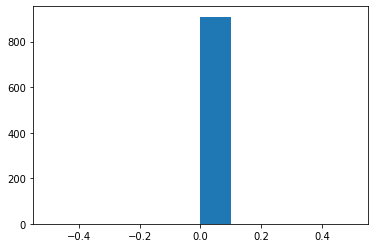


Summary Statistics
           0
count  909.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


INSERT_FRONT
Number of Attempts


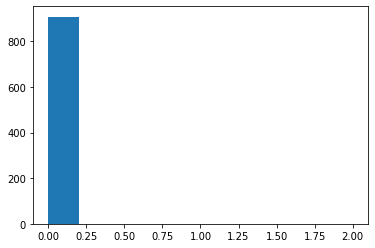


Summary Statistics
                0
count  909.000000
mean     0.002200
std      0.066336
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


MAP_LINK
Number of Attempts


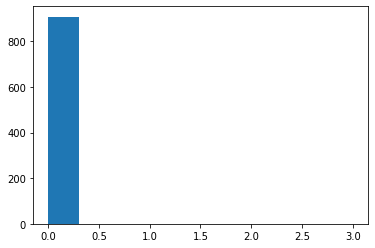


Summary Statistics
                0
count  909.000000
mean     0.003300
std      0.099504
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


STORE_DIGITS
Number of Attempts



Summary Statistics
                0
count  879.000000
mean     7.946530
std      8.382953
min      0.000000
25%      2.000000
50%      5.000000
75%     11.000000
max     43.000000


IS_BST
Number of Attempts


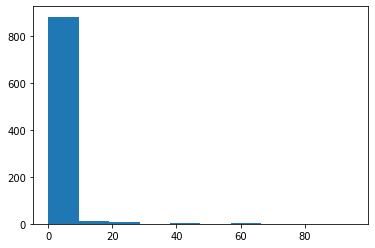


Summary Statistics
                0
count  909.000000
mean     1.067107
std      5.768564
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     95.000000


PATH_YIELDER
Number of Attempts


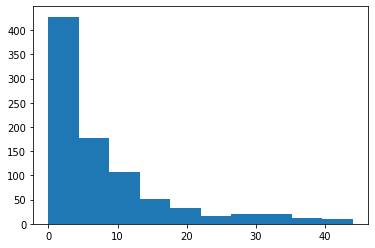


Summary Statistics
                0
count  872.000000
mean     7.824541
std      8.951339
min      0.000000
25%      2.000000
50%      5.000000
75%     10.000000
max     44.000000


LINK
Number of Attempts


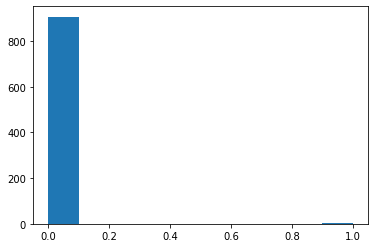


Summary Statistics
                0
count  909.000000
mean     0.002200
std      0.046881
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


ADD
Number of Attempts


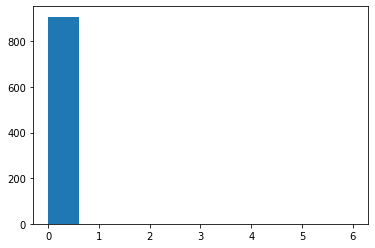


Summary Statistics
                0
count  909.000000
mean     0.006601
std      0.199007
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000



In [37]:
num_attempts_graphs('hw05.csv')

In [ ]:
num_attempts_graphs_by_level('hw05.csv')

# Summary Statistics for spreadsheet

In [30]:
print_comma_separated_summary_statisticsma_separated_summary_statistics('hw01-sp22.csv', ['k_in_num', 'two_of_three', 'a_plus_abs_b', 'largest_factor', 'with_if_statement','hailstone'], use_iqr=True)

Q1, Q3, range = 2.0, 12.0, (-13.0, 27.0)
Q1, Q3, range = 1.0, 3.0, (-2.0, 6.0)
Q1, Q3, range = 2.0, 7.0, (-5.5, 14.5)
Q1, Q3, range = 1.0, 4.0, (-3.5, 8.5)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
k_in_num
981.0,5.6707441386340465,5.935422062325269,0.0,1.0,3.0,8.0,27.0
two_of_three
1026.0,1.9298245614035088,1.5041235575937053,0.0,1.0,2.0,3.0,6.0
a_plus_abs_b
1024.0,4.34375,3.4285045145450965,0.0,2.0,3.0,6.0,14.0
largest_factor
1004.0,2.264940239043825,1.9314074898216391,0.0,1.0,2.0,3.0,8.0
with_if_statement
1109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hailstone
1109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print_comma_separated_summary_statistics('hw01.csv', ['k_in_num', 'two_of_three', 'a_plus_abs_b', 'largest_factor', 'with_if_statement','hailstone'], use_iqr=True)

Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 1.0, 3.0, (-2.0, 6.0)
Q1, Q3, range = 2.0, 6.0, (-4.0, 12.0)
Q1, Q3, range = 1.0, 4.0, (-3.5, 8.5)
Q1, Q3, range = 1.0, 5.0, (-5.0, 11.0)
Q1, Q3, range = 2.0, 8.0, (-7.0, 17.0)
k_in_num
1173.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
two_of_three
1060.0,1.929245283018868,1.4927250072715086,0.0,1.0,1.0,3.0,6.0
a_plus_abs_b
1087.0,4.02391904323827,2.9946819199894037,0.0,2.0,3.0,6.0,12.0
largest_factor
1050.0,2.3133333333333335,1.8586651558103675,0.0,1.0,2.0,3.0,8.0
with_if_statement
1097.0,2.932543299908842,2.6576236923156276,0.0,1.0,2.0,4.0,11.0
hailstone
1092.0,4.737179487179487,4.027810120345174,0.0,2.0,4.0,7.0,17.0


In [32]:
print_comma_separated_summary_statistics('hw02-sp22.csv', ['product', 'summation_using_accumulate', 'hailstone','count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'make_repeater'], use_iqr=True)

Q1, Q3, range = 1.0, 4.0, (-3.5, 8.5)
Q1, Q3, range = 1.0, 5.0, (-5.0, 11.0)
Q1, Q3, range = 2.25, 8.0, (-6.375, 16.625)
Q1, Q3, range = 2.0, 9.0, (-8.5, 19.5)
Q1, Q3, range = 1.0, 3.0, (-2.0, 6.0)
Q1, Q3, range = 1.0, 6.0, (-6.5, 13.5)
Q1, Q3, range = 1.0, 7.0, (-8.0, 16.0)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
product
952.0,2.6281512605042017,1.8881348337970405,0.0,1.0,2.0,4.0,8.0
summation_using_accumulate
977.0,3.158648925281474,2.551600553739078,0.0,1.0,3.0,4.0,11.0
hailstone
972.0,5.292181069958848,3.7839463290246225,0.0,2.0,5.0,7.0,16.0
count_until_larger
920.0,4.810869565217391,4.478347290599592,0.0,2.0,3.0,6.0,19.0
product_using_accumulate
964.0,1.991701244813278,1.4927772141093862,0.0,1.0,2.0,3.0,6.0
filter_sequence
945.0,3.4814814814814814,3.0052788876771723,0.0,1.0,2.0,5.0,13.0
accumulate
945.0,4.0962962962962965,3.715838329150865,0.0,1.0,3.0,6.0,16.0
make_repeater
1034.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print_comma_separated_summary_statistics('hw02.csv', ['product', 'summation_using_accumulate', 'hailstone','count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'make_repeater'], use_iqr=True)

Q1, Q3, range = 1.0, 5.0, (-5.0, 11.0)
Q1, Q3, range = 1.0, 3.0, (-2.0, 6.0)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 1.0, 2.0, (-0.5, 3.5)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 2.0, 9.0, (-8.5, 19.5)
Q1, Q3, range = 3.0, 16.0, (-16.5, 35.5)
product
963.0,3.3219106957424716,2.5222930539119988,0.0,1.0,3.0,4.0,11.0
summation_using_accumulate
991.0,1.912209889001009,1.3292977793576348,0.0,1.0,2.0,3.0,6.0
hailstone
1048.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count_until_larger
1048.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_using_accumulate
937.0,1.4973319103521878,0.8360489916429675,0.0,1.0,1.0,2.0,3.0
filter_sequence
1048.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accumulate
958.0,4.724425887265136,4.526855708580658,0.0,1.0,3.0,7.0,19.0
make_repeater
961.0,9.115504682622268,8.470056263355346,0.0,2.0,6.0,13.0,35.0


In [35]:
print_comma_separated_summary_statistics('hw03-sp22.csv', ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'neighbor_digits', 'missing_digits'], use_iqr=True)

Q1, Q3, range = 2.0, 14.0, (-16.0, 32.0)
Q1, Q3, range = 2.0, 12.0, (-13.0, 27.0)
Q1, Q3, range = 2.0, 14.0, (-16.0, 32.0)
Q1, Q3, range = 2.0, 7.0, (-5.5, 14.5)
Q1, Q3, range = 2.0, 14.0, (-16.0, 32.0)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
has_subseq
850.0,7.727058823529412,7.388326644716041,0.0,2.0,5.0,11.0,32.0
count_coins
822.0,6.5036496350364965,6.585101947785027,0.0,2.0,4.0,9.0,27.0
pingpong
851.0,8.045828437132785,7.779098139997209,0.0,2.0,5.0,12.0,32.0
num_eights
837.0,3.971326164874552,3.3495182521490534,0.0,1.0,3.0,5.0,14.0
neighbor_digits
848.0,7.630896226415095,7.51523211335962,0.0,2.0,5.0,11.0,32.0
missing_digits
917.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
print_comma_separated_summary_statistics('hw03.csv', ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'neighbor_digits', 'missing_digits'], use_iqr=True)

Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 2.0, 15.0, (-17.5, 34.5)
Q1, Q3, range = 3.0, 14.0, (-13.5, 30.5)
Q1, Q3, range = 1.0, 8.0, (-9.5, 18.5)
Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 2.0, 10.0, (-10.0, 22.0)
has_subseq
1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count_coins
925.0,7.926486486486486,8.29834653907363,0.0,1.0,5.0,12.0,34.0
pingpong
937.0,8.076840981856991,7.357076035200425,0.0,2.0,6.0,12.0,30.0
num_eights
943.0,4.471898197242842,4.085472852833413,0.0,1.0,3.0,6.0,18.0
neighbor_digits
1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
missing_digits
939.0,5.667731629392971,5.086284524560873,0.0,2.0,4.0,8.0,22.0


In [41]:
print_comma_separated_summary_statistics('hw04-sp22.csv', [
     'remove_odd_indices', 'SmartFridge', 'merge', 'VendingMachine', 'Mint'
], use_iqr=True)

Q1, Q3, range = 2.0, 8.0, (-7.0, 17.0)
Q1, Q3, range = 4.0, 28.0, (-32.0, 64.0)
Q1, Q3, range = 2.0, 10.0, (-10.0, 22.0)
Q1, Q3, range = 4.0, 15.0, (-12.5, 31.5)
Q1, Q3, range = 2.0, 13.75, (-15.625, 31.375)
remove_odd_indices
808.0,4.945544554455446,3.7581145514610643,0.0,2.0,4.0,7.0,17.0
SmartFridge
841.0,16.22473246135553,15.252108580408676,0.0,4.0,11.0,25.0,64.0
merge
831.0,5.696750902527076,5.112891953624871,0.0,2.0,4.0,8.0,22.0
VendingMachine
844.0,9.244075829383887,7.393347686322512,0.0,3.0,8.0,13.0,31.0
Mint
814.0,7.703931203931204,7.299231405742146,0.0,2.0,5.0,11.0,31.0


In [39]:
print_comma_separated_summary_statistics('hw04.csv', [
     'balanced', 'preorder', 'total_weight', 'totals_tree', 'has_path', 'replace_thor_at_leaf'
], use_iqr=True)

Q1, Q3, range = 3.0, 13.0, (-12.0, 28.0)
Q1, Q3, range = 1.0, 13.0, (-17.0, 31.0)
Q1, Q3, range = 1.0, 3.0, (-2.0, 6.0)
Q1, Q3, range = 1.0, 7.0, (-8.0, 16.0)
Q1, Q3, range = 2.0, 18.0, (-22.0, 42.0)
Q1, Q3, range = 2.0, 10.0, (-10.0, 22.0)
balanced
851.0,7.438307873090482,6.4382598273078555,0.0,3.0,6.0,11.0,28.0
preorder
852.0,6.906103286384977,7.51875744970133,0.0,1.0,4.0,10.0,31.0
total_weight
824.0,2.125,1.4073772820728545,0.0,1.0,2.0,3.0,6.0
totals_tree
844.0,3.800947867298578,3.722357070591163,0.0,1.0,2.0,5.0,16.0
has_path
866.0,10.0,9.97094043604668,0.0,2.0,7.0,15.0,42.0
replace_thor_at_leaf
856.0,5.464953271028038,5.039371143136977,0.0,2.0,4.0,8.0,22.0


In [44]:
print_comma_separated_summary_statistics('hw05-sp22.csv', [
     'duplicate_link', 'flatten_link', 'has_path', 'deep_map_mut', 'chain'
], use_iqr=True)

Q1, Q3, range = 0.0, 0.0, (0.0, 0.0)
Q1, Q3, range = 2.0, 15.0, (-17.5, 34.5)
Q1, Q3, range = 1.0, 7.0, (-8.0, 16.0)
Q1, Q3, range = 3.0, 22.0, (-25.5, 50.5)
Q1, Q3, range = 2.0, 11.0, (-11.5, 24.5)
Q1, Q3, range = 2.0, 17.0, (-20.5, 39.5)
reverse_link
844.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
duplicate_link
783.0,8.77905491698595,8.651447294074357,0.0,2.0,6.0,13.0,34.0
flatten_link
770.0,3.994805194805195,3.7475573701927303,0.0,1.0,3.0,6.0,16.0
has_path
789.0,12.655259822560202,12.345298056393304,0.0,3.0,9.0,19.0,50.0
deep_map_mut
791.0,6.054361567635904,5.84901403057497,0.0,1.0,4.0,9.0,24.0
chain
782.0,9.634271099744245,9.574654544540053,0.0,2.0,6.0,14.0,39.0


In [45]:
print_comma_separated_summary_statistics('hw05.csv', [
     'VendingMachine', 'store_digits', 'path_yielder'
], use_iqr=True)

Q1, Q3, range = 6.0, 18.0, (-12.0, 36.0)
Q1, Q3, range = 2.0, 13.0, (-14.5, 29.5)
Q1, Q3, range = 2.0, 12.0, (-13.0, 27.0)
VendingMachine
862.0,11.909512761020881,8.337045073172016,0.0,6.0,10.0,17.0,36.0
store_digits
853.0,7.0762016412661195,6.804276383630589,0.0,2.0,5.0,11.0,29.0
path_yielder
818.0,6.091687041564792,5.958251683462135,0.0,2.0,4.0,9.0,27.0


# Time Spent

In [61]:
def bucket_diffs(timestamps):
    num_buckets = 0

    if len(timestamps) <= 1:
        return None
    
    result, timestamps = [], list(timestamps)
    
    initial_timestamp = parser.parse(timestamps[0])
    
    for i in range(len(timestamps) - 1):
        current_timestamp = parser.parse(timestamps[i])
        next_timestamp = parser.parse(timestamps[i + 1])
        time_temp = (next_timestamp - current_timestamp).total_seconds() / 3600
        
        
        if time_temp >= 1.2:
            num_buckets += 1
            temp_time_to_add = (current_timestamp - initial_timestamp).total_seconds() / 3600
            
            initial_timestamp = next_timestamp
            result.append(temp_time_to_add)
    
    if parser.parse(timestamps[-1]) != initial_timestamp:
        time_temp = (parser.parse(timestamps[-1]) - initial_timestamp).total_seconds() / 3600
        result.append(time_temp)
    
    return result
            

In [67]:
def generate_total_time_spent(name):
    load_assignment_df(name)
    buckets_all_students = assignment_dfs[name].groupby('student_id')['timestamp'].agg(bucket_diffs)
    
    bucket_times = [sum(bucket_list) for bucket_list in list(buckets_all_students) if bucket_list != None]
    
    plt.hist(bucket_times)
    
    print(pd.DataFrame(bucket_times).describe())


# Lab 01

In [66]:
generate_total_time_spent('lab01-sp22.csv')

                 0
count  1093.000000
mean      2.514274
std       1.884002
min       0.000000
25%       1.116389
50%       2.058333
75%       3.395278
max      11.573611


                 0
count  1183.000000
mean      1.423799
std       1.080703
min       0.000000
25%       0.692361
50%       1.202778
75%       1.899028
max      12.784722


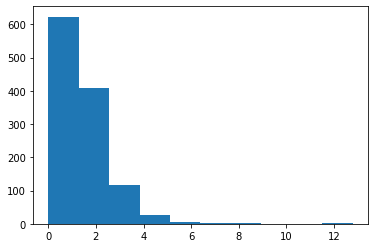

In [178]:
generate_total_time_spent('lab01.csv')

# Lab 02

                 0
count  1062.000000
mean      2.200535
std       1.505438
min       0.000000
25%       1.086806
50%       1.871944
75%       2.995764
max       9.090000


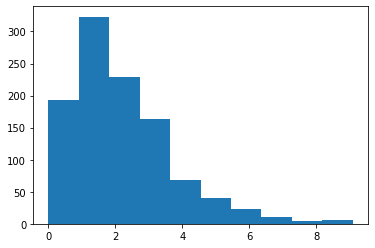

In [180]:
generate_total_time_spent('lab02-sp22.csv')

                 0
count  1055.000000
mean      1.369650
std       1.001230
min       0.000000
25%       0.655833
50%       1.176944
75%       1.836528
max       9.301944


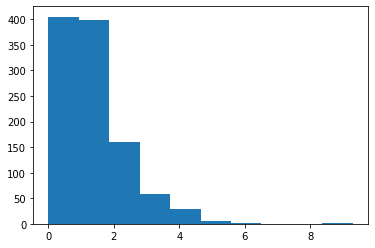

In [181]:
generate_total_time_spent('lab02.csv')

# Lab 04

                0
count  942.000000
mean     1.319485
std      1.084594
min      0.000000
25%      0.617639
50%      0.975000
75%      1.740972
max     11.558611


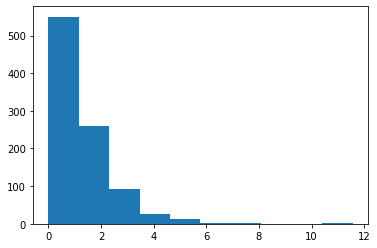

In [182]:
generate_total_time_spent('lab04-sp22.csv')

              0
count  3.000000
mean   0.235185
std    0.324917
min    0.022222
25%    0.048194
50%    0.074167
75%    0.341667
max    0.609167


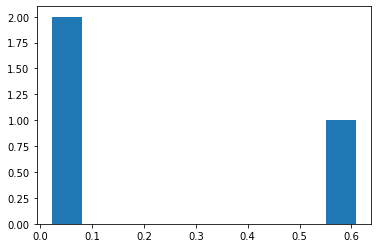

In [183]:
generate_total_time_spent('lab04.csv')

# Lab 05

                0
count  881.000000
mean     1.733588
std      1.223134
min      0.000000
25%      0.850833
50%      1.411667
75%      2.276111
max      7.755278


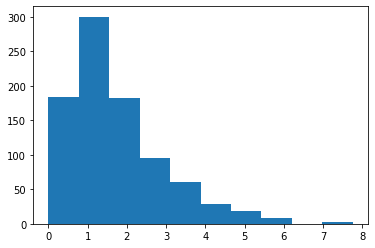

In [193]:
generate_total_time_spent('lab05-sp22.csv')

                0
count  958.000000
mean     2.146969
std      1.507667
min      0.000000
25%      1.108194
50%      1.894444
75%      2.795764
max     12.150000


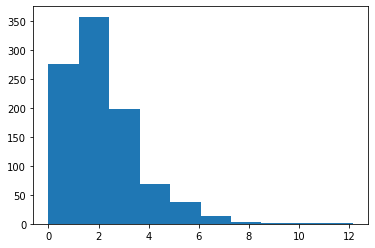

In [69]:
generate_total_time_spent('lab05.csv')

# Lab 06

                0
count  911.000000
mean     1.873883
std      1.419728
min      0.000000
25%      0.862917
50%      1.450556
75%      2.479583
max      8.527500


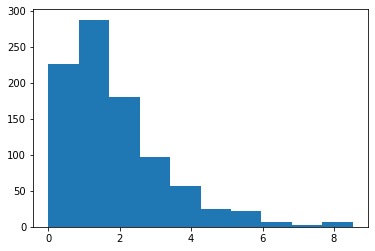

In [68]:
generate_total_time_spent('lab06-sp22.csv')

                0
count  944.000000
mean     1.283752
std      0.899629
min      0.000000
25%      0.642292
50%      1.068472
75%      1.713403
max      6.497500


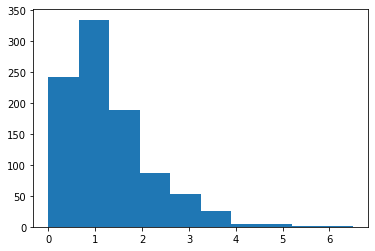

In [70]:
generate_total_time_spent('lab06.csv')

# Lab 07

                0
count  911.000000
mean     1.873883
std      1.419728
min      0.000000
25%      0.862917
50%      1.450556
75%      2.479583
max      8.527500


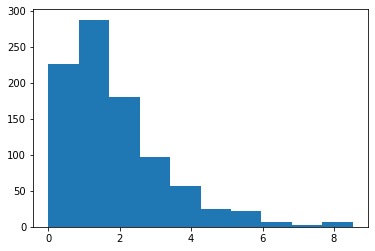

In [78]:
generate_total_time_spent('lab07-sp22.csv') # RERUN then remove this comment

                0
count  944.000000
mean     1.283752
std      0.899629
min      0.000000
25%      0.642292
50%      1.068472
75%      1.713403
max      6.497500


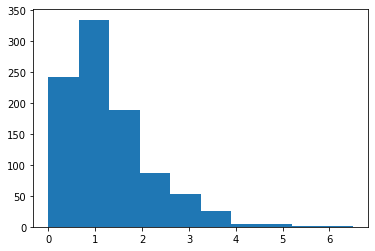

In [79]:
generate_total_time_spent('lab07.csv')

# HW 01

                 0
count  1127.000000
mean      1.715253
std       1.650789
min       0.000000
25%       0.579444
50%       1.246389
75%       2.220417
max      12.254444


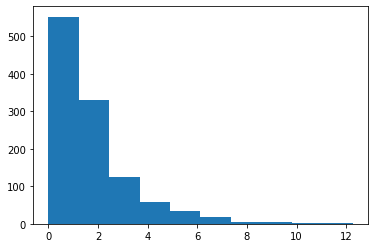

In [82]:
generate_total_time_spent('hw01-sp22.csv')

In [83]:
generate_total_time_spent('hw01.csv')

                 0
count  1219.000000
mean      1.579860
std       1.339900
min       0.000000
25%       0.659306
50%       1.312778
75%       2.139028
max      12.970000


# HW 02

                 0
count  1044.000000
mean      2.441376
std       1.931117
min       0.000000
25%       1.119306
50%       1.873472
75%       3.312083
max      19.005000


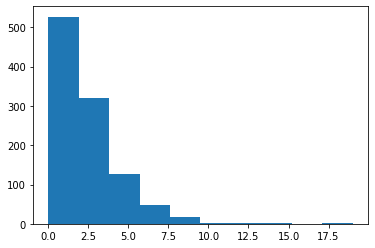

In [84]:
generate_total_time_spent('hw02-sp22.csv')

                 0
count  1059.000000
mean      1.657710
std       1.384448
min       0.000000
25%       0.695000
50%       1.294167
75%       2.262639
max      12.305278


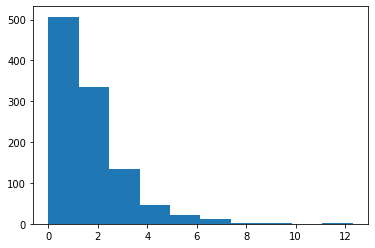

In [85]:
generate_total_time_spent('hw02.csv')

# HW 03

                0
count  930.000000
mean     3.997636
std      2.509279
min      0.000000
25%      2.171528
50%      3.501944
75%      5.364653
max     14.677500


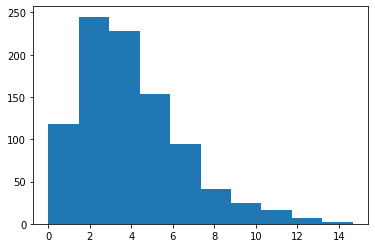

In [88]:
generate_total_time_spent('hw03-sp22.csv')

                 0
count  1022.000000
mean      2.487432
std       1.756146
min       0.000000
25%       1.236806
50%       2.221806
75%       3.323889
max      12.780833


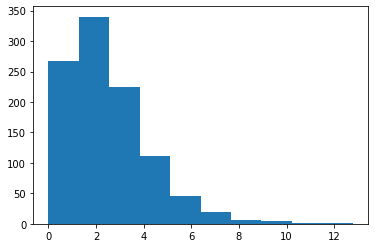

In [89]:
generate_total_time_spent('hw03.csv')

# HW 04

                0
count  894.000000
mean     3.518240
std      2.255007
min      0.000000
25%      1.866458
50%      3.084583
75%      4.678681
max     17.456111


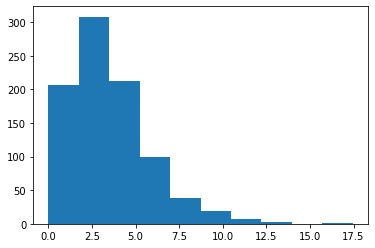

In [90]:
generate_total_time_spent('hw04-sp22.csv')

In [91]:
generate_total_time_spent('hw04.csv')

                0
count  925.000000
mean     3.256213
std      2.329936
min      0.000000
25%      1.528056
50%      2.807778
75%      4.390000
max     16.516111


# HW 05

                0
count  849.000000
mean     3.187054
std      2.115317
min      0.000000
25%      1.663056
50%      2.766389
75%      4.263611
max     14.441667


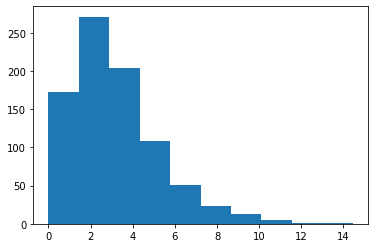

In [86]:
generate_total_time_spent('hw05-sp22.csv')

                0
count  910.000000
mean     1.748748
std      1.480762
min      0.000000
25%      0.735486
50%      1.420139
75%      2.311181
max     12.342222


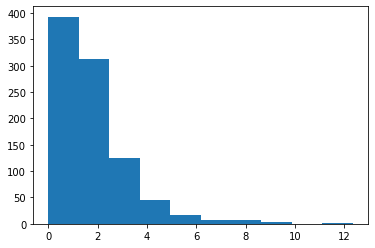

In [87]:
generate_total_time_spent('hw05.csv')